<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/EURJPY/EURJPY_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "EURJPY"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-24 11:02:29,332 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-24 11:02:29,333 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURJPY
2019-08-24 11:07:14,036 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-24 11:18:09,072 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-24 11:23:35,134 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-24 11:28:54,948 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-24 11:34:21,253 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-24 11:40:09,030 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-24 11:45:49,824 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-24 11:51:34,571 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-24 12:10:11,756 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_EURJPY__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-EURJPY__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-EURJPY to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open        High         Low       Close        Volume
Date                                                                             
2018-01-01 22:00:00  135.212997  135.296997  135.132996  135.279007   3494.590088
2018-01-01 23:00:00  135.279999  135.485992  135.169998  135.453003  11702.520508
2018-01-02 00:00:00  135.453003  135.539993  135.416000  135.470001   4992.649902
2018-01-02 01:00:00  135.468994  135.514008  135.417007  135.447998   5474.770020
2018-01-02 02:00:00  135.447006  135.459000  135.343002  135.369995   6819.540039
...                         ...         ...         ...         ...           ...
2018-12-31 17:00:00  125.702003  125.728996  125.570000  125.612000  12911.500000
2018-12-31 18:00:00  125.612999  125.636002  125.547997  125.581001   6734.790039
2018-12-31 19:00:00  125.582001  125.638000  125.568001  125.579002   4857.250000
2018-12-31 20:00:00  125.580002  125.647003  125.579002  125.615997   4612.370117
2018-12-31 21:00:00  125.614998  125.721001  125.569000  125.656998   3358.070068

[6217 rows x 5 columns]

Open         High          Low        Close         Volume
count  6217.000000  6217.000000  6217.000000  6217.000000    6217.000000
mean    130.382767   130.481796   130.282944   130.381165   10815.972656
std       2.431428     2.429240     2.432935     2.430932    4680.130859
min     124.828003   125.196999   124.617996   124.824997     410.700012
25%     128.656006   128.748001   128.563995   128.654999    8318.809570
50%     130.039993   130.134995   129.951004   130.039001   10508.259766
75%     131.701004   131.783997   131.591995   131.699005   12738.480469
max     137.404999   137.501007   137.298004   137.404999  149660.625000

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open        High         Low       Close        Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08       SMA_8      TEMA_8     TRIMA_8       WMA_8      MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2018-01-04 00:00:00  135.257004  135.354996  135.246002  135.337997   8470.860352    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  135.166672  134.033124  134.855427  135.258385  135.197970  135.127248  135.210495  135.201500  134.956185  135.179121  135.307741  135.166695  135.213386  135.179121  135.257665  135.126496              135.345382               135.179121              135.012860              135.428512               135.179121              134.929730              135.511643               135.179121              134.846599              135.594773               135.179121              134.763469  135.197970  135.273294  135.120276              135.364230               135.197970              135.031709              135.447361               135.197970              134.948578              135.530491               135.197970              134.865448   
2018-01-04 01:00:00  135.339005  135.434998  135.326996  135.367996   7761.879883    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  135.176738  134.061714  134.885401  135.312130  135.235753  135.157437  135.225494  135.241501  134.988090  135.212246  135.362933  135.198896  135.255358  135.212246  135.352997  135.133803              135.407677               135.212246              135.016815              135.505392               135.212246              134.919100              135.603107               135.212246              134.821385              135.700823               135.212246              134.723669  135.235753  135.345711  135.130923              135.431184               135.235753              135.040323              135.528899               135.235753              134.942607              135.626614               135.235753              134.844892   
2018-01-04 02:00:00  135.367996  135.432007  135.345993

Open         High          Low        Close         Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6167.000000  6167.000000  6167.000000  6167.000000    6167.000000  6167.000000  6167.000000  6167.000000    6167.000000  6167.000000   6167.000000     6167.000000     6167.000000       6167.000000  6167.000000  6167.000000  6167.000000  6167.000000   6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000  6167.000000             6167.000000              6167.000000             6167.000000             6167.000000              6167.000000             6167.000000             6167.000000              6167.000000             6167.000000             6167.000000              6167.000000             6167.000000  6167.000000  6167.000000  6167.000000             6167.000000              6167.000000             6167.000000             6167.000000              6167.000000             6167.000000             6167.000000   
mean    130.343140   130.442352   130.243103   130.341507   10839.380859    15.897519     2.049781   183.861359      30.441057    11.492946      0.034214        0.972272        0.004054          0.995135     6.548889     2.520188    26.644722     2.049781      2.027566    26.644722   130.347495   130.363380     3.573414   130.341712   130.347005   130.342446   130.344928   130.343580   130.345234   130.347053   130.341639   130.347056   130.345248   130.347053   130.342797   130.357521              130.608363               130.347053              130.085742              130.739018               130.347053              129.955087              130.869673               130.347053              129.824432              131.000329               130.347053              129.693777   130.347005   130.342776   130.355968              130.608316               130.347005              130.085695              130.738971               130.347005              129.955040              130.869626   
std       2.400919     2.399130     2.402053     2.400373    4687.704102     8.724207     1.509174   103.993561       0.843621     6.922436      0.181794        0.164206        0.063546          0.069582     3.408957     1.112489    14.855945     1.509174      1.457324    14.855945     2.396461     2.385609   130.316821     2.402025     2.393247     2.399127     2.395871     2.395725     2.404641     2.395472     2.401443     2.396557     2.396226     2.395472     2.399143     2.387696                2.399105                 2.395472                2.403530                2.405296                 2.395472                2.411913                2.414376                 2.395472                2.423162                2.426314                 2.395472                2.437237     2.393247     2.398359     2.388781                2.396661                 2.393247                2.401534                2.402747                 2.393247                2.410034                2.411727   
min     124.828003   125.196999   

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  0.829212  0.825584  0.838170  0.835691  0.054004    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.821480  0.726414  0.991599  0.826102  0.825018  0.825092    0.826854    0.831583  0.802467  0.824025  0.831751  0.821742  0.825209  0.824025  0.828105  0.823343                0.819016                 0.824025                0.826736                0.780650                 0.824025                0.830366                0.741813                 0.824025                0.833791                0.706510                 0.824025                0.837622  0.825018  0.828684  0.822129                0.824972                 0.825018                0.830023                0.796308                 0.825018                0.833529                0.755884                 0.825018                0.836784                0.719213                 0.825018   
2018-01-04 01:00:00  0.835732  0.832086  0.844558  0.838076  0.049254    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.822321  0.728904  0.991708  0.830477  0.828157  0.827650    0.828088    0.834877  0.804943  0.826766  0.836215  0.824402  0.828678  0.826766  0.835843  0.823965                0.824177                 0.826766                0.827053                0.786734                 0.826766                0.829539                0.748706                 0.826766                0.831885                0.714139                 0.826766                0.834711  0.828157  0.834557  0.823030                0.830571                 0.828157                0.830707                0.802905                 0.828157                0.833068                0.763283                 0.828157                0.835242                0.727339                 0.828157   
2018-01-04 02:00:00  0.838037  0.831843  

139967

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwp31fgew
  JVM stdout: /tmp/tmpwp31fgew/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpwp31fgew/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_z7l50r
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_122447_mod...  0.563230  0.715110              0.466301  0.507908  0.257971
1  DeepLearning_grid_1_AutoML_20190824_122447_mod...  0.515985  0.761861              0.493326  0.529782  0.280669
2  DeepLearning_grid_1_AutoML_20190824_122447_mod...  0.506595  0.785055              0.486748  0.538391  0.289864
3  DeepLearning_grid_1_AutoML_20190824_122447_mod...  0.500000  0.696887              0.500000  0.501855  0.251859
4  DeepLearning_grid_1_AutoML_20190824_122447_mod...  0.500000  0.693047              0.500000  0.499950  0.249950
5  DeepLearning_grid_1_AutoML_20190824_122447_mod...  0.500000  0.698015              0.500000  0.502410  0.252416
6              DeepLearning_1_AutoML_20190824_122447  0.500000  0.693139              0.500000  0.499996  0.249996
7  DeepLearning_grid_1_AutoML_20190824_122447_mod...  0.500000  0.693784              0.500000  0.500318  0.250318
8  DeepLearning_grid_1_AutoML_20190824_122447_mod...  0.493053  0.816018              0.490037  0.541674  0.293410

variable  relative_importance  scaled_importance  percentage
0              CDLHOMINGPIGEON             1.000000           1.000000    0.004594
1                 CDLTHRUSTING             0.995805           0.995805    0.004575
2            CDLDARKCLOUDCOVER             0.980505           0.980505    0.004505
3            CDL3WHITESOLDIERS             0.979079           0.979079    0.004498
4              CDLLADDERBOTTOM             0.975824           0.975824    0.004483
...                        ...                  ...                ...         ...
1031               MIDPOINT_24             0.169894           0.169894    0.000781
1032   BBANDS_upperband_12_2_2             0.168987           0.168987    0.000776
1033   BBANDS_middleband_8_8_5             0.168977           0.168977    0.000776
1034   BBANDS_lowerband_14_1_4             0.165652           0.165652    0.000761
1035  BBANDS_middleband_20_2_3             0.164288           0.164288    0.000755

[1036 rows x 4 columns]

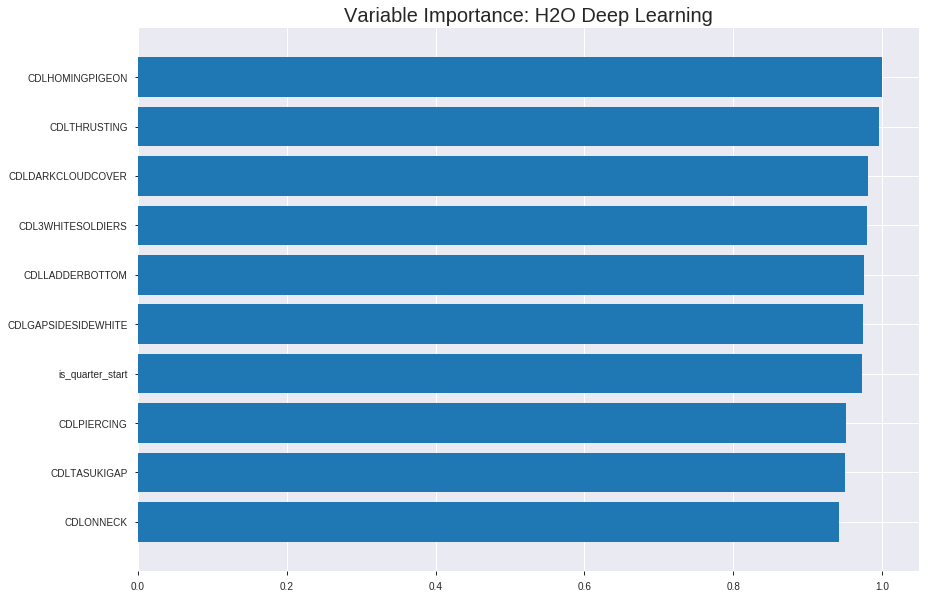

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_122447_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20819939982190722
RMSE: 0.45628872418887056
LogLoss: 0.5971561211248488
Mean Per-Class Error: 0.35090028038614174
AUC: 0.7209936572009217
pr_auc: 0.7350593893999884
Gini: 0.44198731440184336
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32156393379681486: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      629  1474  0.7009   (1474.0/2103.0)
1      142  2071  0.0642   (142.0/2213.0)
Total  771  3545  0.3744   (1616.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321564     0.719347  287
max f2                       0.210467     0.852317  329
max f0point5                 0.453546     0.655123  224
max accuracy                 0.453546     0.652688  224
max precision                0.998258     1         0
max recall                   0.018972     1         393
max specificity              0.998258     1         0
max absolute_mcc             0.389749     0.316017  257
max min_per_class_accuracy   0.510065     0.635758  187
max mean_per_class_accuracy  0.453546     0.6491    224

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 48.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.978335           1.90597   1.90597            0.977273         0.987034  0.977273                    0.987034            0.0194306       0.0194306                  90.5969   90.5969
    2        0.0201576                   0.957245           1.85958   1.88304            0.953488         0.967234  0.965517                    0.977248            0.0185269       0.0379575                  85.9582   88.3042
    3        0.0301205                   0.936132           1.85958   1.87528            0.953488         0.948042  0.961538                    0.967588            0.0185269       0.0564844                  85.9582   87.5282
    4        0.0400834                   0.909214           1.90494   1.88265            0.976744         0.924073  0.965318                    0.956772            0.0189788       0.0754632                  90.4938   88.2653
    5        0.0500463                   0.88584            1.81423   1.86903            0.930233         0.895398  0.958333                    0.944554            0.018075        0.0935382                  81.4227   86.9031
    6        0.100093                    0.767308           1.67942   1.77423            0.861111         0.828621  0.909722                    0.886587            0.0840488       0.177587                   67.942    77.4226
    7        0.150139                    0.672267           1.3634    1.63728            0.699074         0.716986  0.839506                    0.830054            0.0682332       0.24582                    36.34     63.7284
    8        0.200185                    0.609426           1.39049   1.57558            0.712963         0.639068  0.80787                     0.782307            0.0695888       0.315409                   39.0487   57.5585
    9        0.300046                    0.544725           1.09959   1.41716            0.563805         0.571544  0.726641                    0.712161            0.109806        0.425215                   9.95856   41.7163
    10       0.400139                    0.512523           1.05189   1.32579            0.539352         0.526998  0.679792                    0.665844            0.105287        0.530502                   5.18945   32.5793
    11       0.505561                    0.510049           1.05873   1.2701             0.542857         0.510199  0.651237                    0.633388            0.111613        0.642115                   5.87309   27.0104
    12       0.600093                    0.474133           1.07075   1.2387             0.54902          0.49198   0.635135                    0.611112            0.10122         0.743335                   7.07495   23.87
    13       0.699954                    0.419901           0.927634  1.19432            0.475638         0.448574  0.61238                     0.587923            0.0926344       0.835969                   -7.23661  19.4321
    14       0.800046                    0.342896           0.835195  1.14939            0.428241         0.385363  0.589343                    0.562581            0.0835969       0.919566                   -16.4805  14.9391
    15       0.899907                    0.207783           0.610881  1.08963            0.313225         0.280788  0.558702                    0.531311            0.0610032       0.980569                   -38.9119  8.96337
    16       1                           0.00127058         0.194126  1                  0.099537         0.111764  0.512743                    0.489318           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.27428133107233993
RMSE: 0.5237187518815227
LogLoss: 0.7595023257904789
Mean Per-Class Error: 0.47338225466103256
AUC: 0.5216725516094574
pr_auc: 0.5200541559544628
Gini: 0.043345103218914716
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05339506441953417: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    618   0.9984   (618.0/619.0)
1      0    614   0        (0.0/614.0)
Total  1    1232  0.5012   (618.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0533951    0.665222  398
max f2                       0.0533951    0.83243   398
max f0point5                 0.117612     0.555556  379
max accuracy                 0.543801     0.527981  105
max precision                0.620998     0.62069   61
max recall                   0.0533951    1         398
max specificity              0.969046     0.998384  0
max absolute_mcc             0.543801     0.071916  105
max min_per_class_accuracy   0.431878     0.519544  195
max mean_per_class_accuracy  0.543801     0.526618  105

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 41.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.857172           0.772363  0.772363           0.384615         0.904758  0.384615                    0.904758            0.00814332      0.00814332                 -22.7637   -22.7637
    2        0.0202758                   0.764557           1.17142   0.963909           0.583333         0.806126  0.48                        0.857414            0.0114007       0.019544                   17.1417    -3.60912
    3        0.0300081                   0.716793           1.00407   0.976935           0.5              0.734558  0.486486                    0.817569            0.00977199      0.029316                   0.407166   -2.30654
    4        0.0405515                   0.677869           1.54473   1.12456            0.769231         0.695653  0.56                        0.785871            0.0162866       0.0456026                  54.4726    12.456
    5        0.0502839                   0.647324           1.50611   1.19841            0.75             0.663562  0.596774                    0.762198            0.014658        0.0602606                  50.6107    19.8408
    6        0.100568                    0.582022           1.10124   1.14982            0.548387         0.61237   0.572581                    0.687284            0.0553746       0.115635                   10.124     14.9824
    7        0.150041                    0.54955            1.11929   1.13976            0.557377         0.564988  0.567568                    0.646959            0.0553746       0.17101                    11.9293    13.9757
    8        0.200324                    0.526929           0.971682  1.09757            0.483871         0.537838  0.546559                    0.619568            0.0488599       0.21987                    -2.83177   9.75682
    9        0.300081                    0.495561           0.995908  1.06377            0.495935         0.510615  0.52973                     0.583349            0.0993485       0.319218                   -0.409152  6.37732
    10       0.399838                    0.463823           0.946929  1.03462            0.471545         0.479823  0.515213                    0.55752             0.0944625       0.413681                   -5.30706   3.46215
    11       0.500406                    0.431101           1.05266   1.03825            0.524194         0.446877  0.517018                    0.535284            0.105863        0.519544                   5.26558    3.82459
    12       0.600162                    0.400743           0.930603  1.02035            0.463415         0.418016  0.508108                    0.515792            0.0928339       0.612378                   -6.9397    2.03539
    13       0.699919                    0.357219           0.914277  1.00524            0.455285         0.379433  0.500579                    0.496357            0.0912052       0.703583                   -8.57234   0.523513
    14       0.799676                    0.290761           0.979582  1.00204            0.487805         0.326323  0.498986                    0.475146            0.0977199       0.801303                   -2.04179   0.2035
    15       0.899432                    0.20533            0.963256  0.997734           0.479675         0.251748  0.496844                    0.450369            0.0960912       0.897394                   -3.67443   -0.226603
    16       1                           0.0469536          1.02027   1                  0.508065         0.144531  0.497972                


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 12:44:55  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 12:45:00  10.355 sec        149 obs/sec       0.173077  1             747        0.684713         3.31224             -0.876547      0.499536        0.480946           1.0638           0.487257                         0.692121           3.24608               -0.916158        0.50433           0.494057             0.772363           0.502028
    2019-08-24 12:45:53  1 min  3.703 sec  168 obs/sec       2.08156   12            8984       0.583748         1.40389             -0.363935      0.542557        0.540349           1.28542          0.487257                         0.585634           1.0636                -0.371889        0.509298          0.504722             0.926835           0.495539
    2019-08-24 12:46:46  1 min 56.136 sec  183 obs/sec       4.27224   25            18439      0.562642         1.05626             -0.267086      0.571763        0.554053           1.2411           0.45899                          0.565365           0.921949              -0.278571        0.510547          0.509673             1.08131            0.502028
    2019-08-24 12:47:38  2 min 48.444 sec  194 obs/sec       6.66172   39            28752      0.545779         0.933919            -0.192274      0.573813        0.555437           1.15245          0.481001                         0.568903           0.899255              -0.294626        0.508596          0.502146             0.61789            0.502028
    2019-08-24 12:48:31  3 min 41.819 sec  204 obs/sec       9.28058   54            40055      0.543299         0.962851            -0.181462      0.602296        0.575679           1.32975          0.454819                         0.566432           1.00168               -0.283403        0.507457          0.493381             0.926835           0.502028
    2019-08-24 12:49:23  4 min 33.666 sec  210 obs/sec       11.8596   69            51186      0.534106         0.880765            -0.141818      0.610813        0.652651           1.90597          0.483781                         0.583554           1.0225                -0.362162        0.507779          0.51068              1.23578            0.502028
    2019-08-24 12:50:15  5 min 25.398 sec  217 obs/sec       14.5943   85            62989      0.517019         0.779211            -0.0699302     0.640798        0.67226            1.95029          0.479147                         0.551768           0.842363              -0.217814        0.482771          0.486824             0.61789            0.501217
    2019-08-24 12:51:08  6 min 17.929 sec  223 obs/sec       17.4555   102           75338      0.490729         0.681447            0.0361146      0.696843        0.724361           1.95029          0.41937                          0.556621           0.855486              -0.239329        0.50056           0.504847             0.926835           0.497161
    2019-08-24 12:51:59

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLHOMINGPIGEON           1.0                    1.0                  0.0045943268954147685
CDLTHRUSTING              0.9958050847053528     0.9958050847053528   0.004575054083252584
CDLDARKCLOUDCOVER         0.9805048108100891     0.9805048108100891   0.0045047596233883614
CDL3WHITESOLDIERS         0.9790785908699036     0.9790785908699036   0.00449820710275839
CDLLADDERBOTTOM           0.9758240580558777     0.9758240580558777   0.0044832547151189015
---                       ---                    ---                  ---
MIDPOINT_24               0.16989386081695557    0.16989386081695557  0.0007805479341171923
BBANDS_upperband_12_2_2   0.1689869463443756     0.1689869463443756   0.0007763812725639773
BBANDS_middleband_8_8_5   0.16897687315940857    0.16897687315940857  0.0007763349930593607
BBANDS_lowerband_14_1_4   0.16565221548080444    0.16565221548080444  0.0007610604288685025
BBANDS_middleband_20_2_3  0.1642884463071823     0.1642884463071823   0.0007547948274749928


See the whole table with table.as_data_frame()


('accuracy', 0.5623987034035657)

('F1', 0.6757990867579908)

('auc', 0.5632304102909029)

('logloss', 0.7151103754745269)

('mean_per_class_error', 0.4394442576088784)

('rmse', 0.5079080164963091)

('mse', 0.257970553221215)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


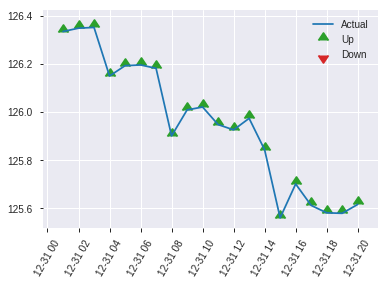


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.257970553221215
RMSE: 0.5079080164963091
LogLoss: 0.7151103754745269
Mean Per-Class Error: 0.4394442576088784
AUC: 0.5632304102909029
pr_auc: 0.5493338272780578
Gini: 0.12646082058180586
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28518087630085753: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   267  0.8783   (267.0/304.0)
1      17   296  0.0543   (17.0/313.0)
Total  54   563  0.4603   (284.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.285181     0.675799  348
max f2                       0.036881     0.837346  399
max f0point5                 0.408181     0.577646  234
max accuracy                 0.408181     0.562399  234
max precision                0.542682     0.64      42
max recall                   0.036881     1         399
max specificity              0.882441     0.996711  0
max absolute_mcc             0.408181     0.12522   234
max min_per_class_accuracy   0.436988     0.552632  192
max mean_per_class_accuracy  0.408181     0.560556  234

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 42.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.668103           0.563213  0.563213           0.285714         0.768263  0.285714                    0.768263            0.00638978      0.00638978                 -43.6787  -43.6787
    2        0.0210697                   0.614079           1.31416   0.909806           0.666667         0.623711  0.461538                    0.701547            0.0127796       0.0191693                  31.4164   -9.01942
    3        0.0307942                   0.587526           1.64271   1.14125            0.833333         0.602232  0.578947                    0.670184            0.0159744       0.0351438                  64.2705   14.1248
    4        0.0405186                   0.571154           0.985623  1.1039             0.5              0.579073  0.56                        0.648317            0.00958466      0.0447284                  -1.4377   10.3898
    5        0.0502431                   0.567032           1.64271   1.20818            0.833333         0.569196  0.612903                    0.633004            0.0159744       0.0607029                  64.2705   20.8183
    6        0.100486                    0.533478           1.20818   1.20818            0.612903         0.54747   0.612903                    0.590237            0.0607029       0.121406                   20.8183   20.8183
    7        0.150729                    0.514852           1.08101   1.16579            0.548387         0.522945  0.591398                    0.567806            0.0543131       0.175719                   8.10059   16.5791
    8        0.200972                    0.501423           0.953829  1.1128             0.483871         0.507758  0.564516                    0.552794            0.0479233       0.223642                   -4.61713  11.28
    9        0.299838                    0.481156           1.06641   1.0975             0.540984         0.491238  0.556757                    0.532497            0.105431        0.329073                   6.64118   9.75045
    10       0.400324                    0.463344           1.14459   1.10932            0.580645         0.473723  0.562753                    0.517744            0.115016        0.444089                   14.4594   10.9325
    11       0.50081                     0.436915           1.08101   1.10364            0.548387         0.448942  0.559871                    0.503939            0.108626        0.552716                   8.10059   10.3643
    12       0.599676                    0.414286           1.0341    1.09218            0.52459          0.424638  0.554054                    0.490865            0.102236        0.654952                   3.40963   9.21768
    13       0.700162                    0.385897           0.794857  1.04951            0.403226         0.401097  0.532407                    0.477982            0.0798722       0.734824                   -20.5143  4.9506
    14       0.799028                    0.350434           0.93715   1.0356             0.47541          0.369289  0.525355                    0.464533            0.0926518       0.827476                   -6.28503  3.56039
    15       0.899514                    0.295916           1.01742   1.03357            0.516129         0.321432  0.524324                    0.448547            0.102236        0.929712                   1.74173   3.35722
    16       1                           0.036881           0.699474  1                  0.354839         0.226175  0.507293                    0.426202          

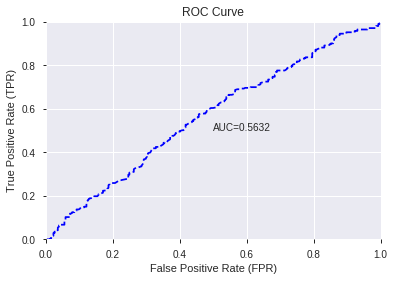

This function is available for GLM models only


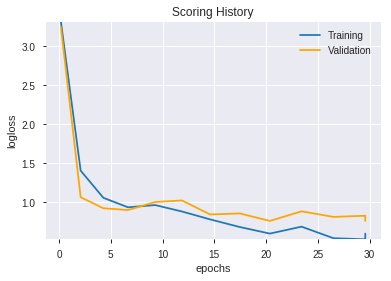

--2019-08-24 13:25:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  60.9MB/s    in 5.8s    

2019-08-24 13:25:08 (60.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_122447_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_122447_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_132603_model_5  0.530982  0.702389              0.493232  0.502263  0.252269
1  DeepLearning_grid_1_AutoML_20190824_132603_model_3  0.507593  0.736797              0.500000  0.513166  0.263340
2  DeepLearning_grid_1_AutoML_20190824_132603_model_2  0.507320  0.765539              0.496711  0.522498  0.273004
3  DeepLearning_grid_1_AutoML_20190824_132603_model_6  0.506821  0.702179              0.488298  0.502922  0.252931
4               DeepLearning_1_AutoML_20190824_132603  0.506768  0.723096              0.496711  0.513411  0.263590
5  DeepLearning_grid_1_AutoML_20190824_132603_model_8  0.504687  0.692889              0.496663  0.499872  0.249872
6  DeepLearning_grid_1_AutoML_20190824_132603_model_9  0.502675  0.693302              0.500000  0.500077  0.250077
7  DeepLearning_grid_1_AutoML_20190824_132603_model_1  0.495870  0.965445              0.496663  0.546529  0.298694
8  DeepLearning_grid_1_AutoML_20190824_132603_model_4  0.494151  0.742931              0.486606  0.520505  0.270926
9  DeepLearning_grid_1_AutoML_20190824_132603_model_7  0.490799  0.846198              0.498355  0.536115  0.287419

variable  relative_importance  scaled_importance  percentage
0                    OBV             1.000000           1.000000    0.038166
1           HT_TRENDMODE             0.861919           0.861919    0.032896
2          days_in_month             0.830736           0.830736    0.031706
3                    BOP             0.766119           0.766119    0.029240
4                   hour             0.744309           0.744309    0.028407
5         STOCHRSI_fastk             0.726162           0.726162    0.027715
6   HT_PHASOR_quadrature             0.718329           0.718329    0.027416
7                 TRANGE             0.708162           0.708162    0.027028
8                    day             0.687732           0.687732    0.026248
9              CORREL_30             0.639350           0.639350    0.024401
10                   EXP             0.628391           0.628391    0.023983
11                  COSH             0.620459           0.620459    0.023680
12                BETA_8             0.605426           0.605426    0.023107
13              CORREL_8             0.603287           0.603287    0.023025
14                  SINH             0.599533           0.599533    0.022882
15               CDLDOJI             0.575876           0.575876    0.021979
16        CDLRICKSHAWMAN             0.567568           0.567568    0.021662
17             CORREL_14             0.553191           0.553191    0.021113
18             CORREL_12             0.549531           0.549531    0.020973
19     CDLLONGLEGGEDDOJI             0.539477           0.539477    0.020590
20        is_month_start             0.504287           0.504287    0.019247
21             CDLHAMMER             0.465711           0.465711    0.017774
22          is_month_end             0.460565           0.460565    0.017578
23        CDLEVENINGSTAR             0.458922           0.458922    0.017515
24             CDLTAKURI             0.454166           0.454166    0.017334
25        CDLMATCHINGLOW             0.453230           0.453230    0.017298
26         CDLHANGINGMAN             0.449877           0.449877    0.017170
27        CDLMORNINGSTAR             0.447193           0.447193    0.017067
28      CDLDRAGONFLYDOJI             0.444115           0.444115    0.016950
29     CDLGRAVESTONEDOJI             0.437669           0.437669    0.016704
30    CDLIDENTICAL3CROWS             0.434948           0.434948    0.016600
31     CDLSTALLEDPATTERN             0.434922           0.434922    0.016599
32           CDLDOJISTAR             0.434456           0.434456    0.016581
33       CDLADVANCEBLOCK             0.433299           0.433299    0.016537
34   CDLGAPSIDESIDEWHITE             0.432941           0.432941    0.016524
35     CDLINVERTEDHAMMER             0.431489           0.431489    0.016468
36            CDL3INSIDE             0.413218           0.413218    0.015771
37     CDLDARKCLOUDCOVER             0.409991           0.409991    0.015648
38    CDLEVENINGDOJISTAR             0.406741           0.406741    0.015524
39          CDLTASUKIGAP             0.402942           0.402942    0.015379
40                   TAN             0.400143           0.400143    0.015272
41      is_quarter_start             0.399567           0.399567    0.015250
42     CDL3WHITESOLDIERS             0.397068           0.397068    0.015154
43       CDLSHOOTINGSTAR             0.396041           0.396041    0.015115
44       CDLHOMINGPIGEON             0.395679           0.395679    0.015101
45           CDLPIERCING             0.389700           0.389700    0.014873
46    CDLSEPARATINGLINES             0.381786           0.381786    0.014571
47             CDLONNECK             0.378508           0.378508    0.014446
48       CDLLADDERBOTTOM             0.372267           0.372267    0.014208
49          CDLTHRUSTING             0.354480           0.354480    0.013529

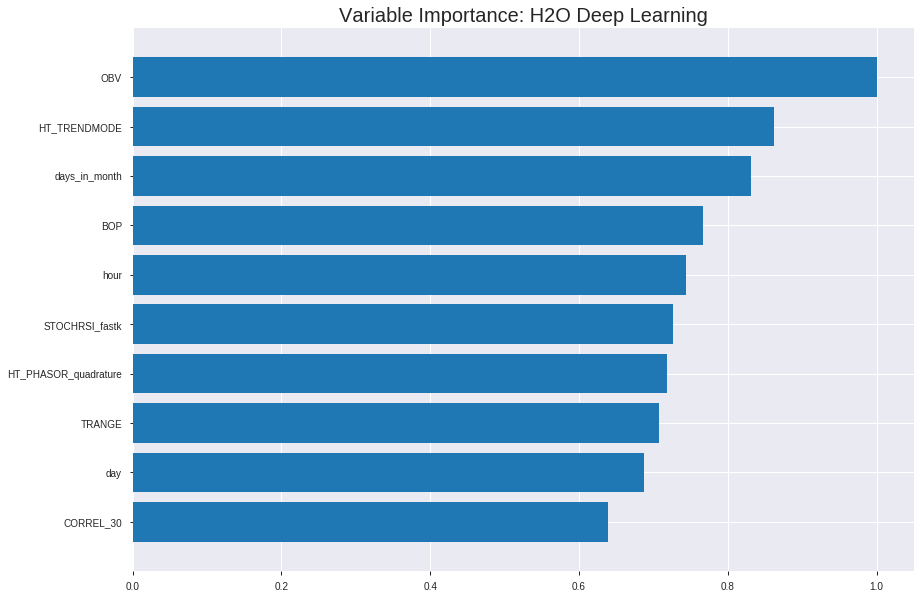

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_132603_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2457799275786043
RMSE: 0.4957619666519451
LogLoss: 0.68362686529393
Mean Per-Class Error: 0.4530519201046683
AUC: 0.5640120121901039
pr_auc: 0.5897800526514744
Gini: 0.12802402438020777
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3360479851057344: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      26   2077  0.9876   (2077.0/2103.0)
1      5    2208  0.0023   (5.0/2213.0)
Total  31   4285  0.4824   (2082.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336048     0.679594  380
max f2                       0.316396     0.840557  386
max f0point5                 0.402198     0.573688  335
max accuracy                 0.468243     0.547266  247
max precision                0.984722     1         0
max recall                   0.247753     1         396
max specificity              0.984722     1         0
max absolute_mcc             0.624362     0.113003  97
max min_per_class_accuracy   0.469476     0.541607  245
max mean_per_class_accuracy  0.468243     0.546948  247

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 48.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101946                   0.811842           1.86164   1.86164            0.954545         0.89737   0.954545                    0.89737             0.0189788       0.0189788                  86.1644    86.1644
    2        0.0201576                   0.729486           1.45138   1.65887            0.744186         0.765816  0.850575                    0.832349            0.01446         0.0334388                  45.1381    65.8871
    3        0.0301205                   0.692253           1.26996   1.53023            0.651163         0.707938  0.784615                    0.791198            0.0126525       0.0460913                  26.9959    53.023
    4        0.0400834                   0.667024           1.49674   1.52191            0.767442         0.676525  0.780347                    0.762695            0.0149119       0.0610032                  49.6737    52.1906
    5        0.0500463                   0.648816           1.17925   1.45369            0.604651         0.656723  0.74537                     0.741599            0.0117488       0.0727519                  17.9247    45.3691
    6        0.100093                    0.578611           1.17379   1.31374            0.601852         0.609346  0.673611                    0.675473            0.0587438       0.131496                   17.3788    31.374
    7        0.150139                    0.541078           0.975147  1.20088            0.5              0.55712   0.615741                    0.636022            0.0488025       0.180298                   -2.48531   20.0875
    8        0.200185                    0.521312           1.11961   1.18056            0.574074         0.530067  0.605324                    0.609533            0.0560325       0.236331                   11.9613    18.056
    9        0.300046                    0.497355           1.03171   1.13102            0.529002         0.507324  0.579923                    0.575516            0.103028        0.339358                   3.17099    13.102
    10       0.400139                    0.482547           0.993205  1.09655            0.509259         0.489845  0.562247                    0.554086            0.0994126       0.438771                   -0.679487  9.65462
    11       0.5                         0.469624           1.04529   1.08631            0.535963         0.476085  0.556997                    0.538507            0.104383        0.543154                   4.5285     8.63082
    12       0.600093                    0.455554           0.970632  1.06701            0.497685         0.462697  0.547104                    0.525863            0.0971532       0.640307                   -2.93677   6.7014
    13       0.699954                    0.441397           0.900484  1.04326            0.461717         0.448618  0.534922                    0.514842            0.0899232       0.73023                    -9.95164   4.32554
    14       0.800046                    0.427517           0.920972  1.02796            0.472222         0.434367  0.527078                    0.504774            0.0921826       0.822413                   -7.9028    2.79567
    15       0.899907                    0.404778           0.977409  1.02235            0.50116          0.416935  0.524202                    0.495027            0.0976051       0.920018                   -2.25906   2.23476
    16       1                           0.174439           0.799079  1                  0.409722         0.377474  0.512743                    0.483



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25228223505670905
RMSE: 0.5022770500995531
LogLoss: 0.6975324412032756
Mean Per-Class Error: 0.4743702409581494
AUC: 0.5087182226244915
pr_auc: 0.5073417517574172
Gini: 0.017436445248983024
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3172240102870932: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    617   0.9968   (617.0/619.0)
1      0    614   0        (0.0/614.0)
Total  2    1231  0.5004   (617.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.317224     0.665583   397
max f2                       0.317224     0.832655   397
max f0point5                 0.359402     0.556472   379
max accuracy                 0.435182     0.524736   270
max precision                0.956226     1          0
max recall                   0.317224     1          397
max specificity              0.956226     1          0
max absolute_mcc             0.871795     0.0572816  3
max min_per_class_accuracy   0.466083     0.498371   199
max mean_per_class_accuracy  0.435182     0.52563    270

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 46.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.636979           1.23578   1.23578            0.615385         0.768686  0.615385                    0.768686            0.0130293       0.0130293                  23.5781   23.5781
    2        0.0202758                   0.581176           1.33876   1.28521            0.666667         0.601235  0.64                        0.688309            0.0130293       0.0260586                  33.8762   28.5212
    3        0.0300081                   0.560942           0.669381  1.08548            0.333333         0.570921  0.540541                    0.650238            0.00651466      0.0325733                  -33.0619  8.54829
    4        0.0405515                   0.550108           1.08131   1.0844             0.538462         0.555839  0.54                        0.625694            0.0114007       0.0439739                  8.13079   8.43974
    5        0.0502839                   0.54001            0.669381  1.00407            0.333333         0.545449  0.5                         0.610163            0.00651466      0.0504886                  -33.0619  0.407166
    6        0.100568                    0.521917           1.16602   1.08505            0.580645         0.528726  0.540323                    0.569444            0.0586319       0.109121                   16.6019   8.50452
    7        0.150041                    0.509844           0.82301   0.998644           0.409836         0.516863  0.497297                    0.552107            0.0407166       0.149837                   -17.699   -0.135575
    8        0.200324                    0.501028           1.00407   1.00001            0.5              0.505526  0.497976                    0.540414            0.0504886       0.200326                   0.407166  0.000659378
    9        0.300081                    0.48992            0.946929  0.982362           0.471545         0.494778  0.489189                    0.525243            0.0944625       0.294788                   -5.30706  -1.7638
    10       0.399838                    0.478435           0.963256  0.977595           0.479675         0.48384   0.486815                    0.514914            0.0960912       0.390879                   -3.67443  -2.24049
    11       0.500406                    0.465018           1.06885   0.995935           0.532258         0.471344  0.495948                    0.506157            0.107492        0.498371                   6.88505   -0.406506
    12       0.600162                    0.449399           1.06121   1.00679            0.528455         0.456849  0.501351                    0.497961            0.105863        0.604235                   6.1214    0.678537
    13       0.699919                    0.437343           1.15917   1.0285             0.577236         0.443393  0.512167                    0.490184            0.115635        0.71987                    15.9172   2.85045
    14       0.799676                    0.423599           0.946929  1.01833            0.471545         0.43046   0.507099                    0.482734            0.0944625       0.814332                   -5.30706  1.83283
    15       0.899432                    0.406657           0.946929  1.01041            0.471545         0.416091  0.503156                    0.475342            0.0944625       0.908795                   -5.30706  1.04094
    16       1                           0.266029           0.906903  1                  0.451613         0.380719  0.497972                    0.4658


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:31:19  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 13:31:21  2 min 15.829 sec  1159 obs/sec      0.560704  1             2420       0.50214          0.697622            -0.00923306    0.534113        0.542719           1.2411           0.487257                         0.508945           0.711502              -0.0361173       0.474758          0.499648             1.39025            0.502028
    2019-08-24 13:31:38  2 min 32.651 sec  2501 obs/sec      10.0037   18            43176      0.495762         0.683627            0.0162413      0.564012        0.58978            1.86164          0.482391                         0.502277           0.697532              -0.00914553      0.508718          0.507342             1.23578            0.500406
    2019-08-24 13:31:55  2 min 49.477 sec  2806 obs/sec      21.086    38            91007      0.49042          0.671178            0.0373283      0.606269        0.629892           1.90597          0.463624                         0.503783           0.701583              -0.0152069       0.483492          0.492319             1.39025            0.502028
    2019-08-24 13:32:11  3 min  6.175 sec  2976 obs/sec      32.7537   59            141365     0.484966         0.659544            0.0586212      0.626874        0.652781           1.95029          0.442076                         0.502958           0.699671              -0.0118826       0.503986          0.500416             1.23578            0.500406
    2019-08-24 13:32:28  3 min 22.837 sec  3106 obs/sec      44.9937   81            194193     0.478324         0.644856            0.0842316      0.654471        0.687658           1.95029          0.416358                         0.505855           0.710736              -0.0235722       0.512994          0.504689             1.08131            0.499594
    2019-08-24 13:32:45  3 min 39.899 sec  3201 obs/sec      57.8054   104           249488     0.469898         0.626212            0.11621        0.68303         0.710394           1.95029          0.401297                         0.512561           0.725435              -0.050891        0.497344          0.492033             1.08131            0.502028
    2019-08-24 13:32:47  3 min 41.610 sec  3200 obs/sec      57.8054   104           249488     0.495762         0.683627            0.0162413      0.564012        0.58978            1.86164          0.482391                         0.502277           0.697532              -0.00914553      0.508718          0.507342             1.23578            0.500406

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
OBV                 1.0                    1.0                  0.03816579454710086
HT_TRENDMODE        0.8619188070297241     0.8619188070297241   0.03289581610537872
days_in_month       0.8307360410690308     0.8307360410690308   0.03170570106631257
BOP                 0.7661186456680298     0.7661186456680298   0.029239526829269186
hour                0.7443085312843323     0.7443085312843323   0.02840712648465222
---                 ---                    ---                  ---
CDLPIERCING         0.3896999657154083     0.3896999657154083   0.014873208826506522
CDLSEPARATINGLINES  0.38178569078445435    0.38178569078445435  0.014571154235502462
CDLONNECK           0.3785080909729004     0.3785080909729004   0.014446062034487077
CDLLADDERBOTTOM     0.37226682901382446    0.37226682901382446  0.014207859312842349
CDLTHRUSTING        0.3544802665710449     0.3544802665710449   0.013529021024952044


See the whole table with table.as_data_frame()


('accuracy', 0.546191247974068)

('F1', 0.6732026143790849)

('auc', 0.5309820077349925)

('logloss', 0.7023885032201332)

('mean_per_class_error', 0.4577360433832185)

('rmse', 0.5022634454657733)

('mse', 0.2522685686511498)

deeplearning prediction progress: |███████████████████████████████████████| 100%


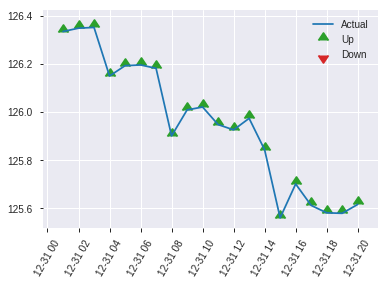


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2522685686511498
RMSE: 0.5022634454657733
LogLoss: 0.7023885032201332
Mean Per-Class Error: 0.4577360433832185
AUC: 0.5309820077349925
pr_auc: 0.5271724092787533
Gini: 0.06196401546998498
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4137456257248441: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    296  0.9737   (296.0/304.0)
1      4    309  0.0128   (4.0/313.0)
Total  12   605  0.4862   (300.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413746     0.673203  387
max f2                       0.32771      0.837346  399
max f0point5                 0.452305     0.573882  305
max accuracy                 0.452305     0.546191  305
max precision                0.942706     0.666667  2
max recall                   0.32771      1         399
max specificity              0.987366     0.996711  0
max absolute_mcc             0.452305     0.100396  305
max min_per_class_accuracy   0.482999     0.514377  213
max mean_per_class_accuracy  0.452305     0.542264  305

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 49.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.669706           0.84482   0.84482            0.428571         0.860599  0.428571                    0.860599            0.00958466      0.00958466                 -15.518   -15.518
    2        0.0210697                   0.625258           0.657082  0.758172           0.333333         0.641056  0.384615                    0.759272            0.00638978      0.0159744                  -34.2918  -24.1828
    3        0.0307942                   0.590528           1.64271   1.0375             0.833333         0.602524  0.526316                    0.709772            0.0159744       0.0319489                  64.2705   3.74979
    4        0.0405186                   0.581945           0.985623  1.02505            0.5              0.58697   0.52                        0.6803              0.00958466      0.0415335                  -1.4377   2.50479
    5        0.0502431                   0.574193           0.985623  1.01742            0.5              0.57709   0.516129                    0.660324            0.00958466      0.0511182                  -1.4377   1.74173
    6        0.100486                    0.543957           1.14459   1.08101            0.580645         0.560419  0.548387                    0.610371            0.057508        0.108626                   14.4594   8.10059
    7        0.150729                    0.527562           1.20818   1.1234             0.612903         0.534643  0.569892                    0.585128            0.0607029       0.169329                   20.8183   12.3398
    8        0.200972                    0.519718           0.89024   1.06511            0.451613         0.523399  0.540323                    0.569696            0.0447284       0.214058                   -10.976   6.51087
    9        0.299838                    0.507914           1.00178   1.04423            0.508197         0.513665  0.52973                     0.551221            0.0990415       0.313099                   0.178076  4.42276
    10       0.400324                    0.495164           0.922034  1.01356            0.467742         0.501832  0.51417                     0.538824            0.0926518       0.405751                   -7.79656  1.35556
    11       0.50081                     0.482785           1.08101   1.02709            0.548387         0.489824  0.521036                    0.528992            0.108626        0.514377                   8.10059   2.70893
    12       0.599676                    0.469042           1.06641   1.03357            0.540984         0.474865  0.524324                    0.520068            0.105431        0.619808                   6.64118   3.35722
    13       0.700162                    0.458563           1.1128    1.04494            0.564516         0.463393  0.530093                    0.511934            0.111821        0.731629                   11.28     4.49429
    14       0.799028                    0.4484             1.00178   1.0396             0.508197         0.453676  0.527383                    0.504726            0.0990415       0.830671                   0.178076  3.96024
    15       0.899514                    0.437267           0.731269  1.00516            0.370968         0.442915  0.50991                     0.497821            0.0734824       0.904153                   -26.8731  0.515787
    16       1                           0.32771            0.953829  1                  0.483871         0.420575  0.507293                    0.490059       

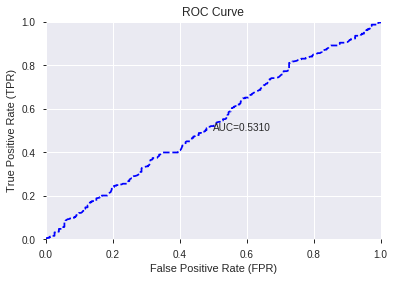

This function is available for GLM models only


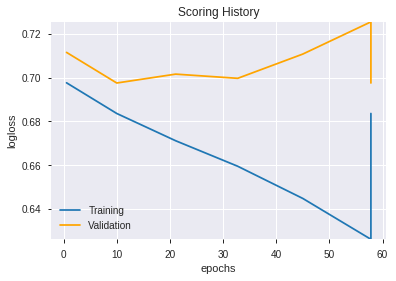

--2019-08-24 13:43:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_132603_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_132603_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['OBV',
 'HT_TRENDMODE',
 'days_in_month',
 'BOP',
 'hour',
 'STOCHRSI_fastk',
 'HT_PHASOR_quadrature',
 'TRANGE',
 'day',
 'CORREL_30',
 'EXP',
 'COSH',
 'BETA_8',
 'CORREL_8',
 'SINH',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CORREL_14',
 'CORREL_12',
 'CDLLONGLEGGEDDOJI',
 'is_month_start',
 'CDLHAMMER',
 'is_month_end',
 'CDLEVENINGSTAR',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'CDLHANGINGMAN',
 'CDLMORNINGSTAR',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLIDENTICAL3CROWS',
 'CDLSTALLEDPATTERN',
 'CDLDOJISTAR',
 'CDLADVANCEBLOCK',
 'CDLGAPSIDESIDEWHITE',
 'CDLINVERTEDHAMMER',
 'CDL3INSIDE',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGDOJISTAR',
 'CDLTASUKIGAP',
 'TAN',
 'is_quarter_start',
 'CDL3WHITESOLDIERS',
 'CDLSHOOTINGSTAR',
 'CDLHOMINGPIGEON',
 'CDLPIERCING',
 'CDLSEPARATINGLINES',
 'CDLONNECK',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_134419_model_1  0.508507  0.693044                   0.5  0.499948  0.249948

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.008895           1.000000    0.083954
1         STOCHRSI_fastk             0.006274           0.705362    0.059218
2   HT_PHASOR_quadrature             0.005198           0.584422    0.049064
3      CDLDARKCLOUDCOVER             0.004576           0.514469    0.043192
4           CDLTHRUSTING             0.004558           0.512382    0.043016
5                   hour             0.003925           0.441209    0.037041
6         CDLRICKSHAWMAN             0.003877           0.435854    0.036592
7                    OBV             0.003821           0.429596    0.036066
8         CDLEVENINGSTAR             0.003678           0.413529    0.034717
9        CDLHOMINGPIGEON             0.003398           0.382009    0.032071
10                BETA_8             0.003120           0.350776    0.029449
11                   TAN             0.002972           0.334082    0.028047
12    CDLIDENTICAL3CROWS             0.002740           0.308023    0.025860
13   CDLGAPSIDESIDEWHITE             0.002535           0.284981    0.023925
14           CDLPIERCING             0.002405           0.270397    0.022701
15          CDLTASUKIGAP             0.002396           0.269307    0.022609
16       CDLLADDERBOTTOM             0.002306           0.259300    0.021769
17             CDLONNECK             0.002303           0.258870    0.021733
18             CDLHAMMER             0.002293           0.257818    0.021645
19            CDL3INSIDE             0.002174           0.244357    0.020515
20       CDLADVANCEBLOCK             0.002068           0.232435    0.019514
21        CDLMATCHINGLOW             0.001902           0.213867    0.017955
22                   day             0.001844           0.207324    0.017406
23          HT_TRENDMODE             0.001823           0.204915    0.017203
24     CDLINVERTEDHAMMER             0.001809           0.203392    0.017076
25      is_quarter_start             0.001717           0.193014    0.016204
26        is_month_start             0.001646           0.185052    0.015536
27         CDLHANGINGMAN             0.001636           0.183946    0.015443
28             CORREL_30             0.001468           0.165069    0.013858
29     CDLLONGLEGGEDDOJI             0.001340           0.150609    0.012644
30     CDLGRAVESTONEDOJI             0.001300           0.146195    0.012274
31               CDLDOJI             0.001235           0.138861    0.011658
32             CORREL_12             0.001158           0.130146    0.010926
33         days_in_month             0.001110           0.124767    0.010475
34              CORREL_8             0.001020           0.114709    0.009630
35     CDLSTALLEDPATTERN             0.000960           0.107870    0.009056
36     CDL3WHITESOLDIERS             0.000946           0.106390    0.008932
37          is_month_end             0.000875           0.098373    0.008259
38             CORREL_14             0.000864           0.097126    0.008154
39             CDLTAKURI             0.000738           0.082993    0.006968
40    CDLSEPARATINGLINES             0.000731           0.082156    0.006897
41                TRANGE             0.000613           0.068872    0.005782
42       CDLSHOOTINGSTAR             0.000609           0.068425    0.005745
43                   EXP             0.000588           0.066110    0.005550
44                  COSH             0.000585           0.065733    0.005518
45                  SINH             0.000580           0.065190    0.005473
46        CDLMORNINGSTAR             0.000488           0.054821    0.004602
47    CDLEVENINGDOJISTAR             0.000430           0.048372    0.004061
48      CDLDRAGONFLYDOJI             0.000386           0.043384    0.003642
49           CDLDOJISTAR             0.000040           0.004470    0.000375

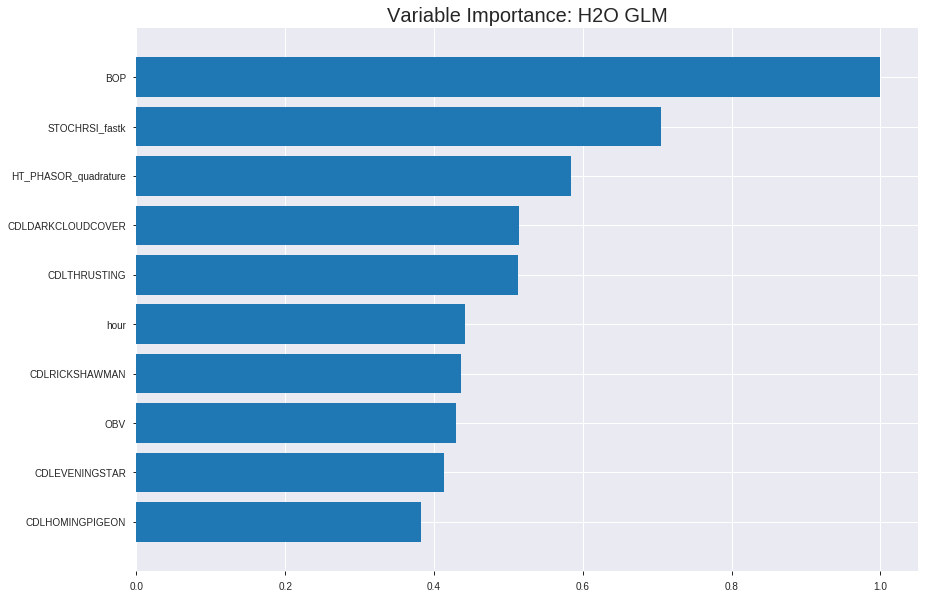

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_134419_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24926157926637052
RMSE: 0.49926103319443077
LogLoss: 0.6916685916717942
Null degrees of freedom: 4315
Residual degrees of freedom: 4265
Null deviance: 5980.442637223593
Residual deviance: 5970.483283310928
AIC: 6072.483283310928
AUC: 0.556488707737682
pr_auc: 0.567843072840894
Gini: 0.112977415475364
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49556149878953065: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      4    2099  0.9981   (2099.0/2103.0)
1      0    2213  0        (0.0/2213.0)
Total  4    4312  0.4863   (2099.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.495561     0.678314   395
max f2                       0.495561     0.84055    395
max f0point5                 0.507413     0.572895   316
max accuracy                 0.510806     0.550046   246
max precision                0.554948     1          0
max recall                   0.495561     1          395
max specificity              0.554948     1          0
max absolute_mcc             0.510806     0.0968573  246
max min_per_class_accuracy   0.512276     0.538279   215
max mean_per_class_accuracy  0.510806     0.547142   246

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.526338           1.59569   1.59569            0.818182         0.536001  0.818182                    0.536001            0.0162675       0.0162675                  59.5695   59.5695
    2        0.0201576                   0.522625           1.13389   1.36745            0.581395         0.523715  0.701149                    0.529928            0.0112969       0.0275644                  13.3892   36.7447
    3        0.0301205                   0.521675           1.08854   1.27519            0.55814          0.522067  0.653846                    0.527328            0.010845        0.0384094                  8.8536    27.5192
    4        0.0400834                   0.521008           1.13389   1.24007            0.581395         0.521282  0.635838                    0.525825            0.0112969       0.0497063                  13.3892   24.0071
    5        0.0500463                   0.520471           1.08854   1.2099             0.55814          0.52075   0.62037                     0.524815            0.010845        0.0605513                  8.8536    20.9904
    6        0.100093                    0.519126           1.12864   1.16927            0.578704         0.519745  0.599537                    0.52228             0.0564844       0.117036                   12.8642   16.9273
    7        0.150139                    0.518146           1.11961   1.15272            0.574074         0.518617  0.591049                    0.521059            0.0560325       0.173068                   11.9613   15.272
    8        0.200185                    0.517204           1.07447   1.13316            0.550926         0.517663  0.581019                    0.52021             0.0537732       0.226841                   7.44674   13.3157
    9        0.300046                    0.515437           1.05886   1.10843            0.542923         0.51631   0.56834                     0.518912            0.105739        0.33258                    5.88602   10.8429
    10       0.400139                    0.51389            1.03384   1.08977            0.530093         0.514647  0.558772                    0.517845            0.103479        0.43606                    3.38363   8.97704
    11       0.5                         0.512289           1.02718   1.07727            0.526682         0.513083  0.552363                    0.516894            0.102576        0.538635                   2.71849   7.72707
    12       0.600093                    0.511006           1.06092   1.07454            0.543981         0.511644  0.550965                    0.516019            0.106191        0.644826                   6.09237   7.45441
    13       0.699954                    0.509667           0.873333  1.04584            0.447796         0.510323  0.536246                    0.515206            0.0872119       0.732038                   -12.6667  4.58377
    14       0.800046                    0.508313           0.943545  1.03304            0.483796         0.509017  0.529684                    0.514432            0.0944419       0.82648                    -5.64551  3.304
    15       0.899907                    0.506597           0.850708  1.01281            0.436195         0.507503  0.51931                     0.513663            0.0849526       0.911432                   -14.9292  1.2807
    16       1                           0.466144           0.884855  1                  0.453704         0.504475  0.512743                    0.512743            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2501930902772547
RMSE: 0.5001930530077909
LogLoss: 0.6935332733082461
Null degrees of freedom: 1232
Residual degrees of freedom: 1182
Null deviance: 1710.357041745574
Residual deviance: 1710.2530519781349
AIC: 1812.2530519781349
AUC: 0.49840290896844236
pr_auc: 0.49936407564593094
Gini: -0.0031941820631152806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5021571545549284: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    615   0.9935   (615.0/619.0)
1      1    613   0.0016   (1.0/614.0)
Total  5    1228  0.4996   (616.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.502157     0.665581   394
max f2                       0.498239     0.83243    398
max f0point5                 0.505555     0.5564     354
max accuracy                 0.508213     0.509327   302
max precision                0.534621     0.8        4
max recall                   0.498239     1          398
max specificity              0.552826     0.998384   0
max absolute_mcc             0.505555     0.0480725  354
max min_per_class_accuracy   0.512487     0.498371   211
max mean_per_class_accuracy  0.505555     0.511124   354

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.530517           1.39025   1.39025            0.692308         0.537816  0.692308                    0.537816            0.014658        0.014658                   39.0253    39.0253
    2        0.0202758                   0.525386           0.836726  1.12456            0.416667         0.528265  0.56                        0.533231            0.00814332      0.0228013                  -16.3274   12.456
    3        0.0300081                   0.522696           1.00407   1.08548            0.5              0.523926  0.540541                    0.530214            0.00977199      0.0325733                  0.407166   8.54829
    4        0.0405515                   0.521588           0.61789   0.963909           0.307692         0.522156  0.48                        0.528119            0.00651466      0.0390879                  -38.211    -3.60912
    5        0.0502839                   0.521055           1.33876   1.03646            0.666667         0.521352  0.516129                    0.526809            0.0130293       0.0521173                  33.8762    3.64611
    6        0.100568                    0.518906           1.03646   1.03646            0.516129         0.519911  0.516129                    0.52336             0.0521173       0.104235                   3.64611    3.64611
    7        0.150041                    0.517761           0.954691  1.0095             0.47541          0.518243  0.502703                    0.521673            0.0472313       0.151466                   -4.53089   0.949908
    8        0.200324                    0.516977           0.842125  0.967486           0.419355         0.51742   0.481781                    0.520605            0.0423453       0.193811                   -15.7875   -3.25139
    9        0.300081                    0.515671           0.979582  0.971507           0.487805         0.516333  0.483784                    0.519185            0.0977199       0.291531                   -2.04179   -2.84928
    10       0.399838                    0.513952           1.07754   0.997962           0.536585         0.514827  0.496957                    0.518098            0.107492        0.399023                   7.75403    -0.203831
    11       0.500406                    0.51245            1.00407   0.99919            0.5              0.513284  0.497569                    0.51713             0.100977        0.5                        0.407166   -0.0810373
    12       0.600162                    0.510973           0.979582  0.995931           0.487805         0.511756  0.495946                    0.516237            0.0977199       0.59772                    -2.04179   -0.406946
    13       0.699919                    0.509693           0.995908  0.995927           0.495935         0.510312  0.495944                    0.515392            0.0993485       0.697068                   -0.409152  -0.40726
    14       0.799676                    0.508211           1.12652   1.01222            0.560976         0.508998  0.504057                    0.514595            0.112378        0.809446                   12.6519    1.22183
    15       0.899432                    0.506668           0.914277  1.00136            0.455285         0.507492  0.498647                    0.513807            0.0912052       0.900651                   -8.57234   0.135551
    16       1                           0.491717           0.987877  1                  0.491935         0.504815  0.497972        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 13:44:20  0.000 sec   2            3         51            1.38334           1.38707
    2019-08-24 13:44:20  0.050 sec   4            1.9       51            1.38223           1.38709
    2019-08-24 13:44:20  0.089 sec   6            1.2       51            1.38077           1.38719
    2019-08-24 13:44:20  0.132 sec   8            0.72      51            1.379             1.38746
    2019-08-24 13:44:20  0.161 sec   10           0.44      51            1.37705           1.38799
    2019-08-24 13:44:20  0.197 sec   12           0.28      51            1.37512           1.38883

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.520259319286872)

('F1', 0.6731182795698925)

('auc', 0.5085074407264166)

('logloss', 0.693043633409426)

('mean_per_class_error', 0.48059946191356984)

('rmse', 0.4999483022497331)

('mse', 0.24994830492239048)

glm prediction progress: |████████████████████████████████████████████████| 100%


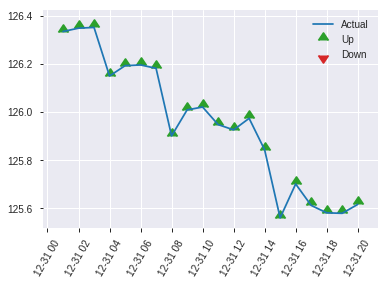


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24994830492239048
RMSE: 0.4999483022497331
LogLoss: 0.693043633409426
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.2856750512815
Residual deviance: 855.2158436272316
AIC: 957.2158436272316
AUC: 0.5085074407264166
pr_auc: 0.5166554336986556
Gini: 0.017014881452833253
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49927941700227474: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    304  1        (304.0/304.0)
1      0    313  0        (0.0/313.0)
Total  0    617  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.499279     0.673118   399
max f2                       0.499279     0.837346   399
max f0point5                 0.499279     0.562747   399
max accuracy                 0.51205      0.520259   213
max precision                0.551849     1          0
max recall                   0.499279     1          399
max specificity              0.551849     1          0
max absolute_mcc             0.501958     0.0796094  395
max min_per_class_accuracy   0.513004     0.511182   192
max mean_per_class_accuracy  0.51205      0.519401   213

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 51.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.524318           1.12643   1.12643            0.571429         0.536043  0.571429                    0.536043            0.0127796       0.0127796                  12.6426   12.6426
    2        0.0210697                   0.522094           0.985623  1.06144            0.5              0.522913  0.538462                    0.529983            0.00958466      0.0223642                  -1.4377   6.14402
    3        0.0307942                   0.52185            1.31416   1.14125            0.666667         0.521931  0.578947                    0.52744             0.0127796       0.0351438                  31.4164   14.1248
    4        0.0405186                   0.521465           0.985623  1.1039             0.5              0.521659  0.56                        0.526053            0.00958466      0.0447284                  -1.4377   10.3898
    5        0.0502431                   0.521241           1.31416   1.14459            0.666667         0.521368  0.580645                    0.525146            0.0127796       0.057508                   31.4164   14.4594
    6        0.100486                    0.519508           1.01742   1.08101            0.516129         0.520152  0.548387                    0.522649            0.0511182       0.108626                   1.74173   8.10059
    7        0.150729                    0.518635           0.826652  0.996221           0.419355         0.519114  0.505376                    0.521471            0.0415335       0.15016                    -17.3348  -0.37789
    8        0.200972                    0.517951           1.14459   1.03331            0.580645         0.51833   0.524194                    0.520686            0.057508        0.207668                   14.4594   3.33144
    9        0.299838                    0.516277           1.00178   1.02292            0.508197         0.517019  0.518919                    0.519477            0.0990415       0.306709                   0.178076  2.29168
    10       0.400324                    0.514465           1.04921   1.02952            0.532258         0.515445  0.522267                    0.518465            0.105431        0.412141                   4.92116   2.95171
    11       0.50081                     0.512955           0.985623  1.02071            0.5              0.513635  0.517799                    0.517496            0.0990415       0.511182                   -1.4377   2.07099
    12       0.599676                    0.511397           1.0341    1.02292            0.52459          0.512186  0.518919                    0.51662             0.102236        0.613419                   3.40963   2.29168
    13       0.700162                    0.510139           0.953829  1.013              0.483871         0.510762  0.513889                    0.515779            0.0958466       0.709265                   -4.61713  1.30014
    14       0.799028                    0.508864           0.840203  0.991621           0.42623          0.509571  0.503043                    0.515011            0.0830671       0.792332                   -15.9797  -0.837929
    15       0.899514                    0.507263           1.1128    1.00516            0.564516         0.508154  0.50991                     0.514245            0.111821        0.904153                   11.28     0.515787
    16       1                           0.499279           0.953829  1                  0.483871         0.5055    0.507293                    0.513366     

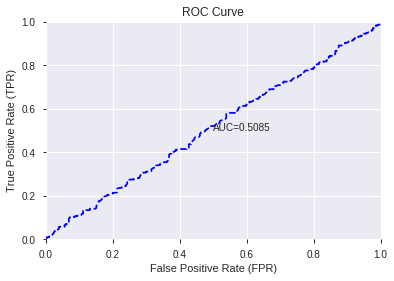

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


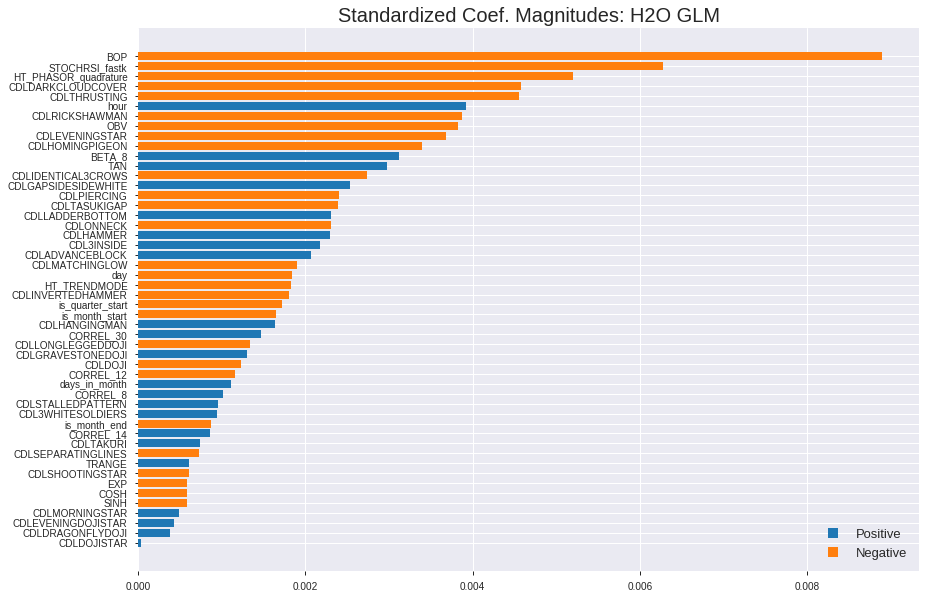

'log_likelihood'
--2019-08-24 13:44:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.192
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.192|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_134419_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_134419_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'STOCHRSI_fastk',
 'HT_PHASOR_quadrature',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING',
 'hour',
 'CDLRICKSHAWMAN',
 'OBV',
 'CDLEVENINGSTAR',
 'CDLHOMINGPIGEON',
 'BETA_8',
 'TAN',
 'CDLIDENTICAL3CROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDLPIERCING',
 'CDLTASUKIGAP',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'CDLHAMMER',
 'CDL3INSIDE',
 'CDLADVANCEBLOCK',
 'CDLMATCHINGLOW',
 'day',
 'HT_TRENDMODE',
 'CDLINVERTEDHAMMER',
 'is_quarter_start',
 'is_month_start',
 'CDLHANGINGMAN',
 'CORREL_30',
 'CDLLONGLEGGEDDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLDOJI',
 'CORREL_12',
 'days_in_month',
 'CORREL_8',
 'CDLSTALLEDPATTERN',
 'CDL3WHITESOLDIERS',
 'is_month_end',
 'CORREL_14',
 'CDLTAKURI',
 'CDLSEPARATINGLINES',
 'TRANGE',
 'CDLSHOOTINGSTAR',
 'EXP',
 'COSH',
 'SINH',
 'CDLMORNINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLDOJISTAR']

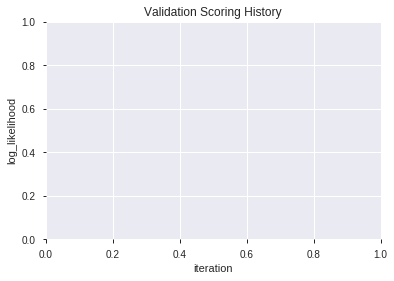

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_134527_model_6  0.501461  0.704523              0.500000  0.505434  0.255464
1  XGBoost_grid_1_AutoML_20190824_134527_model_1  0.495602  0.707128              0.500000  0.506674  0.256718
2  XGBoost_grid_1_AutoML_20190824_134527_model_2  0.490436  0.703460              0.500000  0.505010  0.255035
3               XGBoost_2_AutoML_20190824_134527  0.486805  0.716292              0.500000  0.510876  0.260995
4  XGBoost_grid_1_AutoML_20190824_134527_model_3  0.472413  0.707545              0.498355  0.507005  0.257054
5  XGBoost_grid_1_AutoML_20190824_134527_model_5  0.468077  0.736240              0.500000  0.519512  0.269893
6  XGBoost_grid_1_AutoML_20190824_134527_model_4  0.466280  0.706498              0.500000  0.506498  0.256540
7               XGBoost_3_AutoML_20190824_134527  0.464930  0.710285              0.500000  0.508288  0.258357
8  XGBoost_grid_1_AutoML_20190824_134527_model_7  0.462082  0.720188              0.498308  0.512941  0.263108
9               XGBoost_1_AutoML_20190824_134527  0.448167  0.723590              0.498355  0.514448  0.264656

variable  relative_importance  scaled_importance  percentage
0   HT_PHASOR_quadrature           748.199951           1.000000    0.098902
1                    BOP           741.499939           0.991045    0.098017
2                   COSH           677.247742           0.905169    0.089524
3                 TRANGE           644.514526           0.861420    0.085197
4                    TAN           614.118103           0.820794    0.081179
5              CORREL_30           599.356201           0.801064    0.079227
6                 BETA_8           583.272644           0.779568    0.077101
7              CORREL_12           530.175232           0.708601    0.070082
8                    OBV           471.033356           0.629555    0.062265
9               CORREL_8           446.713409           0.597051    0.059050
10             CORREL_14           354.210388           0.473417    0.046822
11                   day           336.227844           0.449382    0.044445
12                  hour           287.765015           0.384610    0.038039
13        STOCHRSI_fastk           201.651306           0.269515    0.026656
14                   EXP           129.249115           0.172747    0.017085
15         days_in_month            42.837734           0.057254    0.005663
16               CDLDOJI            35.536682           0.047496    0.004697
17          HT_TRENDMODE            25.106445           0.033556    0.003319
18        CDLRICKSHAWMAN            24.345062           0.032538    0.003218
19                  SINH            20.624390           0.027565    0.002726
20            CDL3INSIDE            16.233767           0.021697    0.002146
21          is_month_end            13.141275           0.017564    0.001737
22     CDLINVERTEDHAMMER             8.862875           0.011846    0.001172
23        CDLMATCHINGLOW             4.883952           0.006528    0.000646
24         CDLHANGINGMAN             4.404414           0.005887    0.000582
25           CDLDOJISTAR             3.814785           0.005099    0.000504

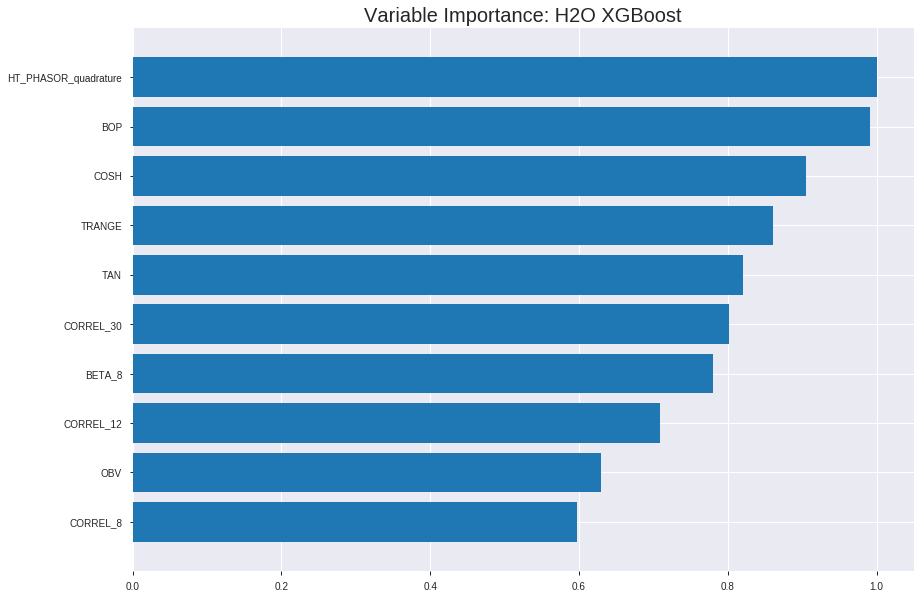

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_134527_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21851467541915306
RMSE: 0.46745553309288473
LogLoss: 0.629164119776861
Mean Per-Class Error: 0.2688559089407919
AUC: 0.8082528584925587
pr_auc: 0.8243030991965752
Gini: 0.6165057169851174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4899095783108159: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1265  838   0.3985   (838.0/2103.0)
1      389   1824  0.1758   (389.0/2213.0)
Total  1654  2662  0.2843   (1227.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48991      0.748308  229
max f2                       0.427959     0.854034  315
max f0point5                 0.533879     0.753524  160
max accuracy                 0.509855     0.730074  198
max precision                0.756871     1         0
max recall                   0.33212      1         386
max specificity              0.756871     1         0
max absolute_mcc             0.51694      0.46412   187
max min_per_class_accuracy   0.50878      0.726615  200
max mean_per_class_accuracy  0.516384     0.731144  188

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.672805           1.95029   1.95029            1                0.701434  1                           0.701434            0.0198825       0.0198825                  95.0294   95.0294
    2        0.0201576                   0.653248           1.95029   1.95029            1                0.661238  1                           0.681567            0.0194306       0.0393131                  95.0294   95.0294
    3        0.0301205                   0.641038           1.95029   1.95029            1                0.646705  1                           0.670036            0.0194306       0.0587438                  95.0294   95.0294
    4        0.0400834                   0.633077           1.81423   1.91647            0.930233         0.63622   0.982659                    0.661631            0.018075        0.0768188                  81.4227   91.6474
    5        0.0500463                   0.626818           1.85958   1.90515            0.953488         0.629968  0.976852                    0.655327            0.0185269       0.0953457                  85.9582   90.5148
    6        0.100093                    0.600392           1.84194   1.87355            0.944444         0.612217  0.960648                    0.633772            0.0921826       0.187528                   84.1944   87.3546
    7        0.150139                    0.582564           1.62524   1.79078            0.833333         0.591184  0.91821                     0.619576            0.0813376       0.268866                   62.5245   79.0779
    8        0.200185                    0.567537           1.68845   1.7652             0.865741         0.575182  0.905093                    0.608478            0.0845007       0.353366                   68.8449   76.5196
    9        0.300046                    0.545018           1.46159   1.66415            0.74942          0.555875  0.853282                    0.59097             0.145956        0.499322                   46.1589   66.415
    10       0.400139                    0.525225           1.20539   1.54939            0.618056         0.534412  0.794441                    0.576823            0.120651        0.619973                   20.539    54.9394
    11       0.5                         0.509186           1.04076   1.44781            0.533643         0.517043  0.742354                    0.564883            0.103931        0.723904                   4.076     44.7808
    12       0.600093                    0.492139           0.848739  1.34789            0.435185         0.500638  0.69112                     0.554168            0.0849526       0.808857                   -15.1261  34.7886
    13       0.699954                    0.475361           0.674231  1.25178            0.345708         0.483786  0.64184                     0.544126            0.0673294       0.876186                   -32.5769  25.1777
    14       0.800046                    0.454991           0.604952  1.17085            0.310185         0.465948  0.600348                    0.534346            0.0605513       0.936737                   -39.5048  17.0854
    15       0.899907                    0.423311           0.452504  1.09114            0.232019         0.439615  0.559475                    0.523834            0.0451875       0.981925                   -54.7496  9.11401
    16       1                           0.272926           0.180583  1                  0.0925926        0.391848  0.512743                    0.510623          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25149208554134916
RMSE: 0.5014898658411246
LogLoss: 0.6962358452218851
Mean Per-Class Error: 0.47675403745665224
AUC: 0.5203319949692948
pr_auc: 0.5102469168335703
Gini: 0.04066398993858966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3445929288864136: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    618   0.9984   (618.0/619.0)
1      0    614   0        (0.0/614.0)
Total  1    1232  0.5012   (618.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.344593     0.665222   398
max f2                       0.344593     0.83243    398
max f0point5                 0.393016     0.554328   378
max accuracy                 0.472007     0.522303   269
max precision                0.720348     1          0
max recall                   0.344593     1          398
max specificity              0.720348     1          0
max absolute_mcc             0.472007     0.0525057  269
max min_per_class_accuracy   0.506133     0.513029   199
max mean_per_class_accuracy  0.472007     0.523246   269

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.650018           1.08131   1.08131            0.538462         0.675245  0.538462                    0.675245            0.0114007       0.0114007                  8.13079    8.13079
    2        0.0202758                   0.629009           1.00407   1.04423            0.5              0.63638   0.52                        0.65659             0.00977199      0.0211726                  0.407166   4.42345
    3        0.0300081                   0.620172           1.00407   1.03121            0.5              0.624821  0.513514                    0.646286            0.00977199      0.0309446                  0.407166   3.12087
    4        0.0405515                   0.606522           1.08131   1.04423            0.538462         0.612323  0.52                        0.637456            0.0114007       0.0423453                  8.13079    4.42345
    5        0.0502839                   0.602168           1.00407   1.03646            0.5              0.604261  0.516129                    0.631031            0.00977199      0.0521173                  0.407166   3.64611
    6        0.100568                    0.582867           1.06885   1.05266            0.532258         0.592268  0.524194                    0.61165             0.0537459       0.105863                   6.88505    5.26558
    7        0.150041                    0.569374           0.88885   0.998644           0.442623         0.576069  0.497297                    0.599918            0.0439739       0.149837                   -11.115    -0.135575
    8        0.200324                    0.558818           0.906903  0.975616           0.451613         0.56345   0.48583                     0.590764            0.0456026       0.19544                    -9.30966   -2.43838
    9        0.300081                    0.540839           1.19182   1.04749            0.593496         0.549458  0.521622                    0.577032            0.118893        0.314332                   19.1825    4.7491
    10       0.399838                    0.523041           0.963256  1.02647            0.479675         0.531681  0.511156                    0.565717            0.0960912       0.410423                   -3.67443   2.64749
    11       0.500406                    0.505832           1.03646   1.02848            0.516129         0.515049  0.512156                    0.555534            0.104235        0.514658                   3.64611    2.84818
    12       0.600162                    0.491126           0.995908  1.02307            0.495935         0.498048  0.509459                    0.545979            0.0993485       0.614007                   -0.409152  2.30676
    13       0.699919                    0.47736            1.06121   1.0285             0.528455         0.484428  0.512167                    0.537207            0.105863        0.71987                    6.1214     2.85045
    14       0.799676                    0.461092           0.979582  1.0224             0.487805         0.469197  0.509128                    0.528723            0.0977199       0.81759                    -2.04179   2.24016
    15       0.899432                    0.430549           0.89795   1.0086             0.447154         0.447294  0.502254                    0.519691            0.0895765       0.907166                   -10.205    0.859858
    16       1                           0.321074           0.923098  1                  0.459677         0.406464  0.497972                 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:45:53  10.603 sec  0                  0.5              0.693147            0.5             0                  1                0.487257                         0.5                0.693147              0.5               0                    1                  0.502028
    2019-08-24 13:45:53  10.675 sec  5                  0.495626         0.684427            0.656679        0.668617           1.72867          0.451576                         0.499796           0.692738              0.515388          0.511423             1.43439            0.501217
    2019-08-24 13:45:53  10.728 sec  10                 0.492158         0.677537            0.683814        0.701865           1.77299          0.430028                         0.499887           0.69292               0.517364          0.508073             0.926835           0.501217
    2019-08-24 13:45:53  10.797 sec  15                 0.488376         0.67006             0.712472        0.732828           1.86164          0.398749                         0.499909           0.692962              0.51843           0.518249             1.23578            0.501217
    2019-08-24 13:45:53  10.859 sec  20                 0.485185         0.663764            0.730486        0.748212           1.90597          0.365848                         0.500151           0.693454              0.517429          0.517464             1.08131            0.501217
    2019-08-24 13:45:53  10.930 sec  25                 0.48156          0.656634            0.748806        0.769007           1.90597          0.339435                         0.500393           0.693962              0.520723          0.512569             1.08131            0.501217
    2019-08-24 13:45:53  11.001 sec  30                 0.478525         0.650683            0.761911        0.778434           1.90597          0.338971                         0.500552           0.694286              0.520381          0.512285             1.08131            0.500406
    2019-08-24 13:45:53  11.066 sec  35                 0.475614         0.64499             0.772437        0.789859           1.95029          0.334106                         0.500795           0.694788              0.520296          0.510849             1.39025            0.499594
    2019-08-24 13:45:53  11.150 sec  40                 0.472839         0.639577            0.78482         0.801344           1.95029          0.321594                         0.500611           0.694439              0.524726          0.511765             1.08131            0.501217
    2019-08-24 13:45:53  11.222 sec  45                 0.469996         0.634089            0.801011        0.815575           1.95029          0.298888                         0.501184           0.695604              0.520391          0.508848             0.926835           0.501217
    2019-08-24 13:45:53  11.307 sec  50                 0.467456         0.629164            0.808253        0.824303           1.95029          0.284291                         0.50149            0.696236              0.520332          0.510247             1.08131            0.501217

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
HT_PHASOR_quadrature  748.199951171875       1.0                   0.09890249366063618
BOP                   741.4999389648438      0.9910451581872769    0.09801683747502134
COSH                  677.2477416992188      0.9051694545535232    0.08952351624078132
TRANGE                644.5145263671875      0.8614201663040886    0.08519660253703427
TAN                   614.1181030273438      0.8207940966388405    0.08117858293951052
---                   ---                    ---                   ---
is_month_end          13.141275405883789     0.01756385493650614   0.0017371090515141319
CDLINVERTEDHAMMER     8.862874984741211      0.011845596849959228  0.0011715590673595443
CDLMATCHINGLOW        4.883951663970947      0.006527602222268811  0.0006455961374070957
CDLHANGINGMAN         4.404414176940918      0.005886680652735227  0.0005822073959393354
CDLDOJISTAR           3.8147852420806885     0.005098617336322659  0.0005042659687836614


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.520259319286872)

('F1', 0.6731182795698925)

('auc', 0.501460820581806)

('logloss', 0.7045226548914487)

('mean_per_class_error', 0.4774308474861274)

('rmse', 0.505434154732082)

('mse', 0.2554636847697342)

xgboost prediction progress: |████████████████████████████████████████████| 100%


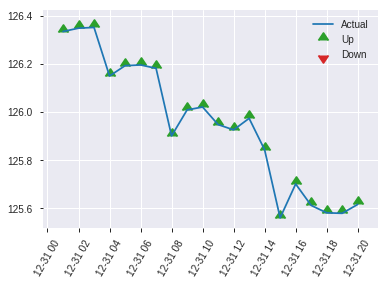


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2554636847697342
RMSE: 0.505434154732082
LogLoss: 0.7045226548914487
Mean Per-Class Error: 0.4774308474861274
AUC: 0.501460820581806
pr_auc: 0.5067404942245
Gini: 0.002921641163611932
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3449805676937103: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    304  1        (304.0/304.0)
1      0    313  0        (0.0/313.0)
Total  0    617  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344981     0.673118  399
max f2                       0.344981     0.837346  399
max f0point5                 0.344981     0.562747  399
max accuracy                 0.540878     0.520259  147
max precision                0.588307     0.582278  66
max recall                   0.344981     1         399
max specificity              0.708761     0.996711  0
max absolute_mcc             0.385443     0.112954  391
max min_per_class_accuracy   0.517832     0.507987  202
max mean_per_class_accuracy  0.540878     0.522569  147

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 51.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.669037           0.563213  0.563213           0.285714         0.688191  0.285714                    0.688191            0.00638978      0.00638978                 -43.6787  -43.6787
    2        0.0210697                   0.662815           0         0.303269           0                0.664783  0.153846                    0.677387            0               0.00638978                 -100      -69.6731
    3        0.0307942                   0.637208           0.985623  0.518749           0.5              0.651491  0.263158                    0.669209            0.00958466      0.0159744                  -1.4377   -48.1251
    4        0.0405186                   0.631598           1.31416   0.709649           0.666667         0.635005  0.36                        0.661               0.0127796       0.028754                   31.4164   -29.0351
    5        0.0502431                   0.624326           1.31416   0.826652           0.666667         0.627875  0.419355                    0.654589            0.0127796       0.0415335                  31.4164   -17.3348
    6        0.100486                    0.600051           1.27177   1.04921            0.645161         0.611503  0.532258                    0.633046            0.0638978       0.105431                   27.1772   4.92116
    7        0.150729                    0.584633           1.14459   1.08101            0.580645         0.59061   0.548387                    0.618901            0.057508        0.162939                   14.4594   8.10059
    8        0.200972                    0.570124           1.01742   1.06511            0.516129         0.575677  0.540323                    0.608095            0.0511182       0.214058                   1.74173   6.51087
    9        0.299838                    0.547591           1.00178   1.04423            0.508197         0.559071  0.52973                     0.591931            0.0990415       0.313099                   0.178076  4.42276
    10       0.400324                    0.532895           0.922034  1.01356            0.467742         0.539236  0.51417                     0.578704            0.0926518       0.405751                   -7.79656  1.35556
    11       0.50081                     0.517386           1.08101   1.02709            0.548387         0.525056  0.521036                    0.567939            0.108626        0.514377                   8.10059   2.70893
    12       0.599676                    0.504397           0.93715   1.01226            0.47541          0.511155  0.513514                    0.558578            0.0926518       0.607029                   -6.28503  1.22615
    13       0.700162                    0.487889           0.985623  1.00844            0.5              0.49558   0.511574                    0.549536            0.0990415       0.70607                    -1.4377   0.843835
    14       0.799028                    0.471061           0.64631   0.963631           0.327869         0.479693  0.488844                    0.540894            0.0638978       0.769968                   -35.369   -3.63686
    15       0.899514                    0.443409           1.01742   0.96964            0.516129         0.458953  0.491892                    0.531741            0.102236        0.872204                   1.74173   -3.03601
    16       1                           0.344981           1.27177   1                  0.645161         0.41158   0.507293                    0.519666 

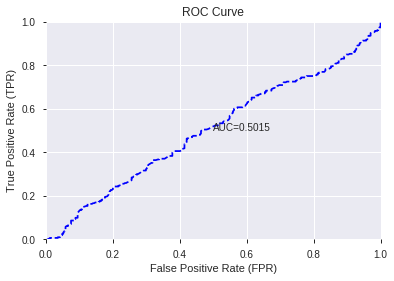

This function is available for GLM models only


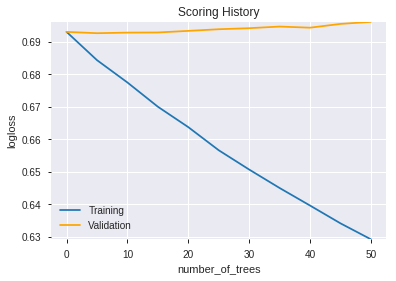

--2019-08-24 13:46:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_134527_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_134527_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_PHASOR_quadrature',
 'BOP',
 'COSH',
 'TRANGE',
 'TAN',
 'CORREL_30',
 'BETA_8',
 'CORREL_12',
 'OBV',
 'CORREL_8',
 'CORREL_14',
 'day',
 'hour',
 'STOCHRSI_fastk',
 'EXP',
 'days_in_month',
 'CDLDOJI',
 'HT_TRENDMODE',
 'CDLRICKSHAWMAN',
 'SINH',
 'CDL3INSIDE',
 'is_month_end',
 'CDLINVERTEDHAMMER',
 'CDLMATCHINGLOW',
 'CDLHANGINGMAN',
 'CDLDOJISTAR']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_134702_model_1  0.524703  0.692051              0.498355  0.499453  0.249453

variable  relative_importance  scaled_importance  percentage
0                         BOP         8.416598e-03           1.000000    0.013150
1                 CDLLONGLINE         6.623292e-03           0.786932    0.010348
2                   CDLHARAMI         6.438193e-03           0.764940    0.010059
3           CDLDARKCLOUDCOVER         6.309518e-03           0.749652    0.009858
4                CDLTHRUSTING         5.953983e-03           0.707410    0.009303
...                       ...                  ...                ...         ...
1031               MIDPOINT_8         2.923297e-06           0.000347    0.000005
1032  BBANDS_lowerband_12_6_3         2.594581e-06           0.000308    0.000004
1033  BBANDS_upperband_14_3_4         2.121169e-06           0.000252    0.000003
1034  BBANDS_lowerband_14_4_5         9.944284e-07           0.000118    0.000002
1035  BBANDS_lowerband_14_4_4         8.263595e-07           0.000098    0.000001

[1036 rows x 4 columns]

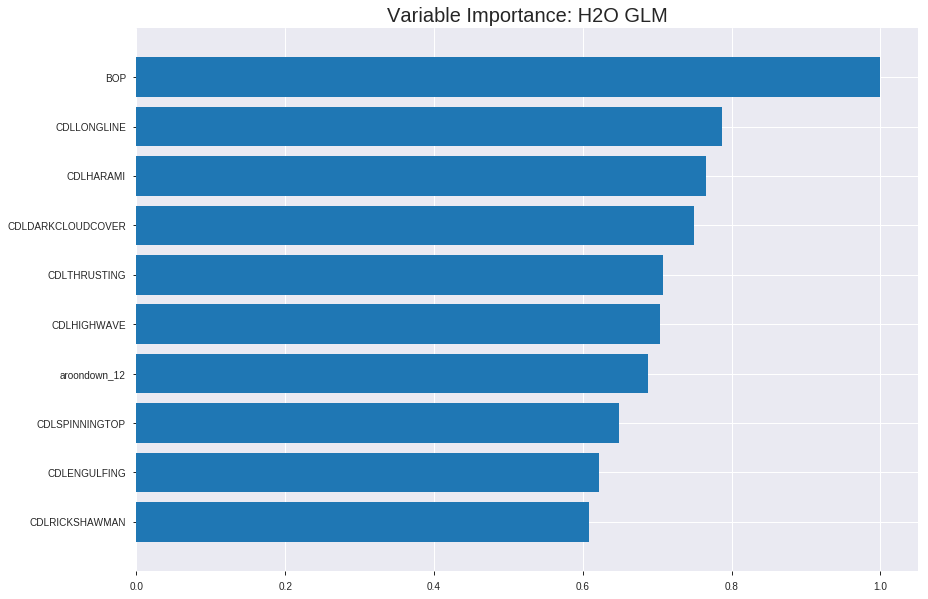

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_134702_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24741758026552038
RMSE: 0.4974108767060893
LogLoss: 0.6879667170131702
Null degrees of freedom: 4315
Residual degrees of freedom: 3279
Null deviance: 5980.442637223593
Residual deviance: 5938.5287012576855
AIC: 8012.5287012576855
AUC: 0.5686492667823966
pr_auc: 0.5724594944813924
Gini: 0.13729853356479316
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4583297945215611: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      59   2044  0.9719   (2044.0/2103.0)
1      20   2193  0.009    (20.0/2213.0)
Total  79   4237  0.4782   (2064.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45833      0.68      369
max f2                       0.418352     0.840358  398
max f0point5                 0.49018      0.574405  287
max accuracy                 0.512377     0.556997  199
max precision                0.595584     1         0
max recall                   0.418352     1         398
max specificity              0.595584     1         0
max absolute_mcc             0.512377     0.113503  199
max min_per_class_accuracy   0.513042     0.553495  196
max mean_per_class_accuracy  0.512377     0.556757  199

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101946                   0.572188           1.46272   1.46272            0.75             0.581651  0.75                        0.581651            0.0149119       0.0149119                  46.272     46.272
    2        0.0201576                   0.564551           1.31531   1.38986            0.674419         0.567654  0.712644                    0.574733            0.0131044       0.0280163                  31.5314    38.9864
    3        0.0301205                   0.560116           1.31531   1.36521            0.674419         0.562019  0.7                         0.570527            0.0131044       0.0411207                  31.5314    36.5206
    4        0.0400834                   0.55674            0.771046  1.21752            0.395349         0.558301  0.624277                    0.567488            0.00768188      0.0488025                  -22.8954   21.7524
    5        0.0500463                   0.554653           1.04318   1.18282            0.534884         0.555732  0.606481                    0.565148            0.0103931       0.0591957                  4.31804    18.2817
    6        0.100093                    0.544675           1.12864   1.15573            0.578704         0.548964  0.592593                    0.557056            0.0564844       0.11568                    12.8642    15.573
    7        0.150139                    0.537609           1.13767   1.14971            0.583333         0.540786  0.589506                    0.551633            0.0569363       0.172616                   13.7671    14.971
    8        0.200185                    0.533443           1.20088   1.1625             0.615741         0.535483  0.596065                    0.547595            0.0600994       0.232716                   20.0875    16.2501
    9        0.300046                    0.525484           1.14031   1.15512            0.584687         0.529223  0.592278                    0.541481            0.113873        0.346588                   14.0311    15.5116
    10       0.400139                    0.518951           1.05641   1.13043            0.541667         0.522183  0.579618                    0.536654            0.105739        0.452327                   5.64091    13.0425
    11       0.5                         0.513023           0.990985  1.10258            0.508121         0.515829  0.565338                    0.532494            0.0989607       0.551288                   -0.901549  10.2576
    12       0.600093                    0.50686            0.930001  1.07379            0.476852         0.510024  0.550579                    0.528746            0.0930863       0.644374                   -6.99988   7.37911
    13       0.699954                    0.500534           0.927634  1.05294            0.475638         0.503891  0.539887                    0.5252              0.0926344       0.737009                   -7.23661   5.29391
    14       0.800046                    0.492154           0.880341  1.03135            0.451389         0.496367  0.528816                    0.521593            0.0881157       0.825124                   -11.9659   3.13456
    15       0.899907                    0.480922           0.923109  1.01933            0.473318         0.486875  0.522657                    0.517741            0.0921826       0.917307                   -7.68911   1.93348
    16       1                           0.40554            0.826166  1                  0.423611         0.467814  0.512743                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24953970490159574
RMSE: 0.49953949283474647
LogLoss: 0.6922324295009674
Null degrees of freedom: 1232
Residual degrees of freedom: 196
Null deviance: 1710.357041745574
Residual deviance: 1707.0451711493856
AIC: 3781.0451711493856
AUC: 0.5323996358527203
pr_auc: 0.5233109849081891
Gini: 0.06479927170544064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4079168095131749: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    619   1        (619.0/619.0)
1      0    614   0        (0.0/614.0)
Total  0    1233  0.502    (619.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.407917     0.664862   399
max f2                       0.407917     0.832204   399
max f0point5                 0.491026     0.555039   261
max accuracy                 0.500669     0.532847   216
max precision                0.56664      0.666667   2
max recall                   0.407917     1          399
max specificity              0.588676     0.998384   0
max absolute_mcc             0.494158     0.0703388  247
max min_per_class_accuracy   0.506363     0.526656   190
max mean_per_class_accuracy  0.50051      0.533253   217

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 50.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.554992           1.08131   1.08131            0.538462         0.564067  0.538462                    0.564067            0.0114007       0.0114007                  8.13079   8.13079
    2        0.0202758                   0.551244           1.17142   1.12456            0.583333         0.553004  0.56                        0.558757            0.0114007       0.0228013                  17.1417   12.456
    3        0.0300081                   0.548437           1.67345   1.30258            0.833333         0.549984  0.648649                    0.555912            0.0162866       0.0390879                  67.3453   30.2579
    4        0.0405515                   0.544587           0.926835  1.20489            0.461538         0.546732  0.6                         0.553525            0.00977199      0.0488599                  -7.31646  20.4886
    5        0.0502839                   0.543456           0.836726  1.13363            0.416667         0.543831  0.564516                    0.551649            0.00814332      0.0570033                  -16.3274  13.3629
    6        0.100568                    0.534846           1.06885   1.10124            0.532258         0.53894   0.548387                    0.545294            0.0537459       0.110749                   6.88505   10.124
    7        0.150041                    0.530165           0.987611  1.06377            0.491803         0.532347  0.52973                     0.541025            0.0488599       0.159609                   -1.23885  6.37732
    8        0.200324                    0.526706           0.939293  1.03253            0.467742         0.528367  0.51417                     0.537848            0.0472313       0.20684                    -6.07072  3.25271
    9        0.300081                    0.519355           1.09387   1.05292            0.544715         0.522677  0.524324                    0.532805            0.109121        0.315961                   9.38667   5.29184
    10       0.399838                    0.512988           1.06121   1.05499            0.528455         0.516204  0.525355                    0.528663            0.105863        0.421824                   6.1214    5.49881
    11       0.500406                    0.506353           1.06885   1.05777            0.532258         0.509581  0.526742                    0.524828            0.107492        0.529316                   6.88505   5.7774
    12       0.600162                    0.500452           1.04489   1.05563            0.520325         0.50335   0.525676                    0.521258            0.104235        0.63355                    4.48876   5.56321
    13       0.699919                    0.49439            0.930603  1.03781            0.463415         0.497767  0.516802                    0.51791             0.0928339       0.726384                   -6.9397   3.78122
    14       0.799676                    0.486222           0.914277  1.0224             0.455285         0.490568  0.509128                    0.514499            0.0912052       0.81759                    -8.57234  2.24016
    15       0.899432                    0.474921           0.848971  1.00317            0.422764         0.480927  0.499549                    0.510775            0.0846906       0.90228                    -15.1029  0.316628
    16       1                           0.407917           0.971682  1                  0.483871         0.454969  0.497972                    0.505163           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 13:47:10  0.000 sec   2            3         1037          1.37752           1.38462
    2019-08-24 13:47:14  4.813 sec   4            2.2       1037          1.37593           1.38446
    2019-08-24 13:47:19  9.756 sec   6            1.6       1037          1.37415           1.3845
    2019-08-24 13:47:24  14.702 sec  8            1.2       1037          1.37216           1.38478
    2019-08-24 13:47:29  19.529 sec  10           0.84      1037          1.36999           1.38542
    2019-08-24 13:47:34  24.308 sec  12           0.61      1037          1.36768           1.3865
    2019-08-24 13:47:39  29.028 sec  14           0.44      1037          1.36527           1.38811

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5413290113452188)

('F1', 0.673842841765339)

('auc', 0.5247025811333446)

('logloss', 0.6920505625018452)

('mean_per_class_error', 0.4635688162098537)

('rmse', 0.4994527025431814)

('mse', 0.24945300207768767)

glm prediction progress: |████████████████████████████████████████████████| 100%


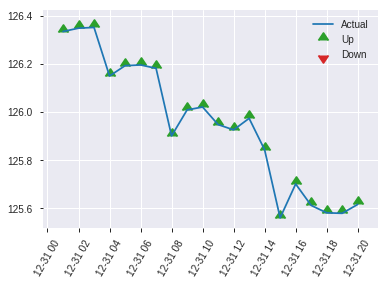


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24945300207768767
RMSE: 0.4994527025431814
LogLoss: 0.6920505625018452
Null degrees of freedom: 616
Residual degrees of freedom: -420
Null deviance: 855.2856750512815
Residual deviance: 853.9903941272769
AIC: 2927.990394127277
AUC: 0.5247025811333446
pr_auc: 0.537596718478795
Gini: 0.04940516226668912
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44523645763765723: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    303  0.9967   (303.0/304.0)
1      0    313  0        (0.0/313.0)
Total  1    616  0.4911   (303.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445236     0.673843  398
max f2                       0.445236     0.837794  398
max f0point5                 0.491659     0.574761  322
max accuracy                 0.492282     0.541329  319
max precision                0.555696     0.777778  7
max recall                   0.445236     1         398
max specificity              0.566359     0.996711  0
max absolute_mcc             0.491659     0.100536  322
max min_per_class_accuracy   0.514249     0.504792  194
max mean_per_class_accuracy  0.492282     0.536431  319

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.557035           1.40803   1.40803            0.714286         0.561807  0.714286                    0.561807            0.0159744       0.0159744                  40.8033   40.8033
    2        0.0210697                   0.554715           1.31416   1.36471            0.666667         0.555638  0.692308                    0.55896             0.0127796       0.028754                   31.4164   36.4709
    3        0.0307942                   0.551183           1.31416   1.34875            0.666667         0.552629  0.684211                    0.556961            0.0127796       0.0415335                  31.4164   34.8747
    4        0.0405186                   0.548817           0.328541  1.1039             0.166667         0.54983   0.56                        0.555249            0.00319489      0.0447284                  -67.1459  10.3898
    5        0.0502431                   0.544228           1.31416   1.14459            0.666667         0.546645  0.580645                    0.553584            0.0127796       0.057508                   31.4164   14.4594
    6        0.100486                    0.539194           1.14459   1.14459            0.580645         0.542029  0.580645                    0.547806            0.057508        0.115016                   14.4594   14.4594
    7        0.150729                    0.535447           1.08101   1.1234             0.548387         0.537245  0.569892                    0.544286            0.0543131       0.169329                   8.10059   12.3398
    8        0.200972                    0.530384           1.01742   1.0969             0.516129         0.532769  0.556452                    0.541407            0.0511182       0.220447                   1.74173   9.6903
    9        0.299838                    0.523778           0.840203  1.01226            0.42623          0.527201  0.513514                    0.536723            0.0830671       0.303514                   -15.9797  1.22615
    10       0.400324                    0.51965            1.14459   1.04548            0.580645         0.521892  0.530364                    0.533               0.115016        0.41853                    14.4594   4.54787
    11       0.50081                     0.513822           0.858446  1.00795            0.435484         0.516705  0.511327                    0.52973             0.086262        0.504792                   -14.1554  0.795103
    12       0.599676                    0.50767            1.0341    1.01226            0.52459          0.510538  0.513514                    0.526566            0.102236        0.607029                   3.40963   1.22615
    13       0.700162                    0.50164            0.89024   0.994749           0.451613         0.50432   0.50463                     0.523373            0.0894569       0.696486                   -10.976   -0.525086
    14       0.799028                    0.495336           1.32494   1.0356             0.672131         0.498598  0.525355                    0.520308            0.13099         0.827476                   32.4936   3.56039
    15       0.899514                    0.487022           0.858446  1.01581            0.435484         0.491185  0.515315                    0.517055            0.086262        0.913738                   -14.1554  1.58133
    16       1                           0.443671           0.858446  1                  0.435484         0.474175  0.507293                    0.512746       

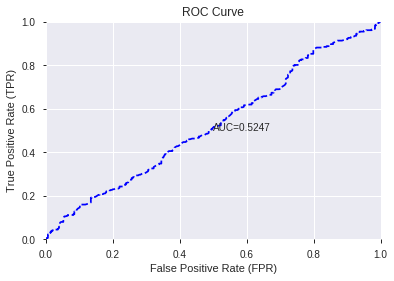

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


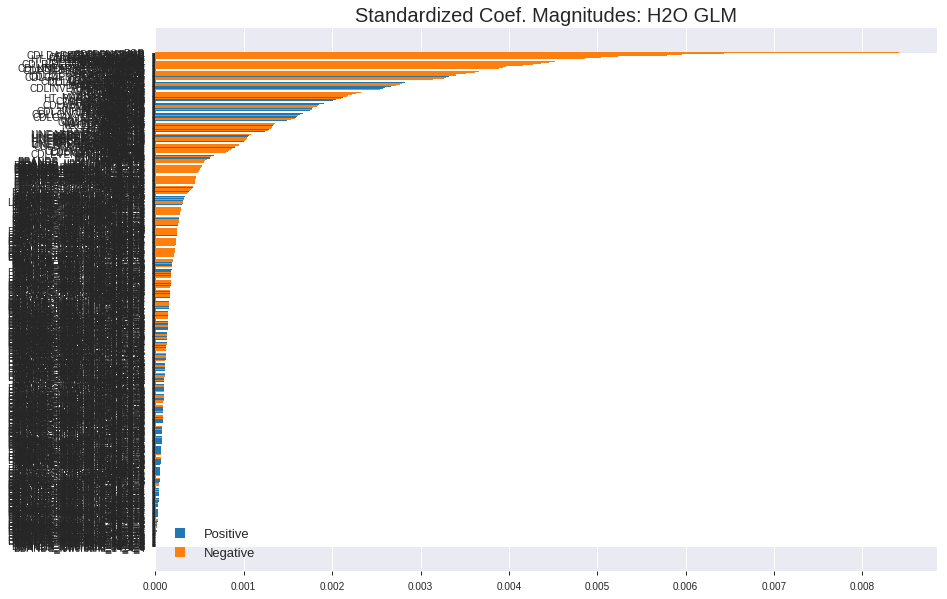

'log_likelihood'
--2019-08-24 13:48:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.208
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.208|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_134702_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_134702_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

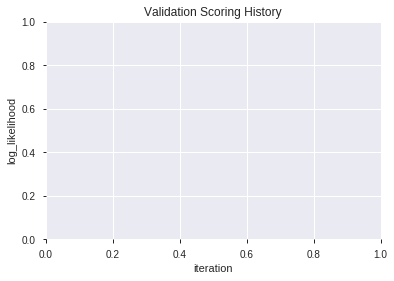

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_134901  0.516689  0.702268              0.498355  0.504374  0.254393
1  XGBoost_grid_1_AutoML_20190824_134901_model_1  0.514934  0.702522              0.500000  0.504432  0.254451
2  XGBoost_grid_1_AutoML_20190824_134901_model_6  0.511093  0.701053              0.498308  0.503854  0.253869
3  XGBoost_grid_1_AutoML_20190824_134901_model_5  0.510031  0.737581              0.500000  0.519595  0.269978
4  XGBoost_grid_1_AutoML_20190824_134901_model_2  0.507241  0.701827              0.495066  0.504232  0.254250
5  XGBoost_grid_1_AutoML_20190824_134901_model_3  0.506952  0.699077              0.498355  0.502882  0.252890
6  XGBoost_grid_1_AutoML_20190824_134901_model_4  0.498255  0.701753              0.495018  0.504206  0.254224
7  XGBoost_grid_1_AutoML_20190824_134901_model_7  0.497772  0.715561              0.494971  0.510566  0.260678
8               XGBoost_1_AutoML_20190824_134901  0.481314  0.718526              0.493326  0.511909  0.262051
9               XGBoost_2_AutoML_20190824_134901  0.473464  0.719156              0.498355  0.512357  0.262509

variable  relative_importance  scaled_importance  percentage
0                        BOP           245.328949           1.000000    0.028957
1       HT_PHASOR_quadrature           197.349274           0.804427    0.023293
2                    BETA_30           145.612198           0.593539    0.017187
3                     ADX_24           138.989273           0.566542    0.016405
4                     BETA_8           137.145905           0.559029    0.016188
..                       ...                  ...                ...         ...
329  BBANDS_upperband_12_5_3             2.014696           0.008212    0.000238
330   BBANDS_lowerband_8_6_2             1.741177           0.007097    0.000206
331              AROONOSC_14             1.698914           0.006925    0.000201
332                   RSI_24             1.127523           0.004596    0.000133
333           MACDEXT_signal             0.096458           0.000393    0.000011

[334 rows x 4 columns]

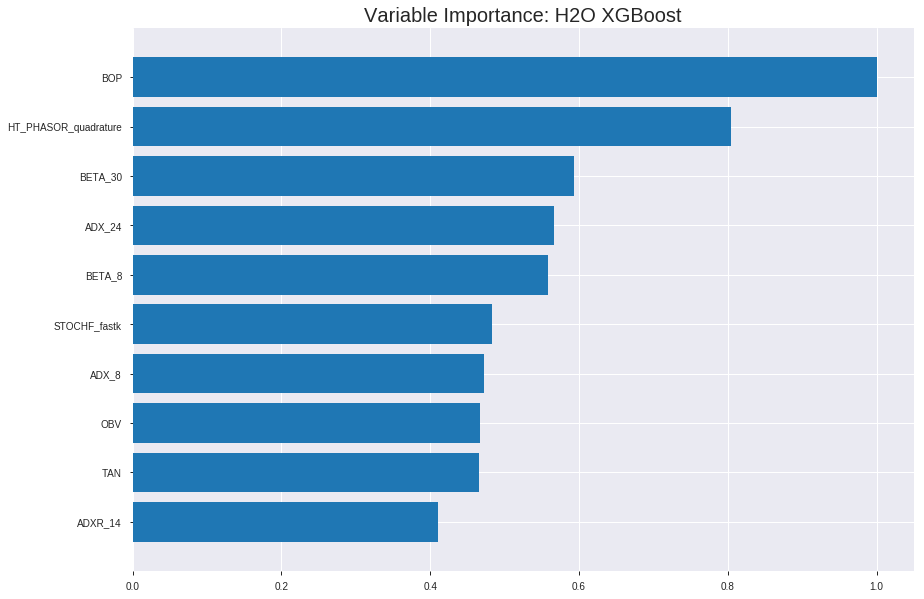

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_134901


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20388642000863394
RMSE: 0.4515378389555342
LogLoss: 0.5993251225059845
Mean Per-Class Error: 0.17574392358816904
AUC: 0.9054131349809269
pr_auc: 0.9093838033441196
Gini: 0.8108262699618538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4946699823651995: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1557  546   0.2596   (546.0/2103.0)
1      239   1974  0.108    (239.0/2213.0)
Total  1796  2520  0.1819   (785.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49467      0.834143  225
max f2                       0.464813     0.890685  264
max f0point5                 0.527376     0.85129   178
max accuracy                 0.514673     0.823679  196
max precision                0.765518     1         0
max recall                   0.338805     1         378
max specificity              0.765518     1         0
max absolute_mcc             0.517869     0.648799  191
max min_per_class_accuracy   0.510107     0.821057  202
max mean_per_class_accuracy  0.514673     0.824256  196

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.24 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.69252            1.95029    1.95029            1                0.712685  1                           0.712685            0.0198825       0.0198825                  95.0294   95.0294
    2        0.0201576                   0.672828           1.95029    1.95029            1                0.682263  1                           0.697649            0.0194306       0.0393131                  95.0294   95.0294
    3        0.0301205                   0.662125           1.95029    1.95029            1                0.66674   1                           0.687425            0.0194306       0.0587438                  95.0294   95.0294
    4        0.0400834                   0.652343           1.95029    1.95029            1                0.657122  1                           0.679893            0.0194306       0.0781744                  95.0294   95.0294
    5        0.0500463                   0.643492           1.81423    1.92321            0.930233         0.648383  0.986111                    0.67362             0.018075        0.0962494                  81.4227   92.3206
    6        0.100093                    0.612792           1.91418    1.91869            0.981481         0.627381  0.983796                    0.650501            0.0957976       0.192047                   91.4177   91.8692
    7        0.150139                    0.593913           1.87806    1.90515            0.962963         0.603063  0.976852                    0.634688            0.0939901       0.286037                   87.8061   90.5148
    8        0.200185                    0.577876           1.82389    1.88483            0.935185         0.585736  0.966435                    0.62245             0.0912788       0.377316                   82.3886   88.4832
    9        0.300046                    0.553442           1.72404    1.83132            0.883991         0.565517  0.938996                    0.603502            0.172164        0.54948                    72.4042   83.1318
    10       0.400139                    0.53072            1.49884    1.74815            0.768519         0.541785  0.896352                    0.588064            0.150023        0.699503                   49.8837   74.815
    11       0.5                         0.511279           1.15841    1.63037            0.593968         0.52079   0.835959                    0.574628            0.11568         0.815183                   15.8411   63.0366
    12       0.600093                    0.491371           0.857768   1.5015             0.439815         0.501438  0.769884                    0.56242             0.0858563       0.901039                   -14.2232  50.15
    13       0.699954                    0.471091           0.51133    1.36023            0.262181         0.480965  0.697451                    0.550799            0.0510619       0.952101                   -48.867   36.0235
    14       0.800046                    0.446105           0.284418   1.22564            0.145833         0.45914   0.628439                    0.539332            0.0284681       0.980569                   -71.5582  22.5641
    15       0.899907                    0.413588           0.135751   1.1047             0.0696056        0.431451  0.566426                    0.52736             0.0135563       0.994126                   -86.4249  10.4698
    16       1                           0.212205           0.0586894  1                  0.0300926        0.378097  0.512743                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2525945472562883
RMSE: 0.5025878502871794
LogLoss: 0.698553981478271
Mean Per-Class Error: 0.47931675024864107
AUC: 0.516906274173433
pr_auc: 0.5114725433881944
Gini: 0.03381254834686609
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3199135959148407: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    614   0.9919   (614.0/619.0)
1      1    613   0.0016   (1.0/614.0)
Total  6    1227  0.4988   (615.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.319914     0.665942   393
max f2                       0.274589     0.832204   399
max f0point5                 0.319914     0.555053   393
max accuracy                 0.513528     0.520681   188
max precision                0.636589     0.580645   25
max recall                   0.274589     1          399
max specificity              0.725698     0.998384   0
max absolute_mcc             0.319914     0.0463357  393
max min_per_class_accuracy   0.507        0.520194   200
max mean_per_class_accuracy  0.507        0.520683   200

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 50.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.67205            1.08131   1.08131            0.538462         0.699068  0.538462                    0.699068            0.0114007       0.0114007                  8.13079   8.13079
    2        0.0202758                   0.641659           0.836726  0.963909           0.416667         0.65567   0.48                        0.678237            0.00814332      0.019544                   -16.3274  -3.60912
    3        0.0300081                   0.627956           1.00407   0.976935           0.5              0.635637  0.486486                    0.664421            0.00977199      0.029316                   0.407166  -2.30654
    4        0.0405515                   0.617085           1.08131   1.00407            0.538462         0.622342  0.5                         0.65348             0.0114007       0.0407166                  8.13079   0.407166
    5        0.0502839                   0.609038           1.33876   1.06885            0.666667         0.612799  0.532258                    0.645607            0.0130293       0.0537459                  33.8762   6.88505
    6        0.100568                    0.586774           1.03646   1.05266            0.516129         0.598374  0.524194                    0.62199             0.0521173       0.105863                   3.64611   5.26558
    7        0.150041                    0.57257            1.08637   1.06377            0.540984         0.57957   0.52973                     0.608003            0.0537459       0.159609                   8.63726   6.37732
    8        0.200324                    0.561494           1.00407   1.04879            0.5              0.566503  0.522267                    0.597586            0.0504886       0.210098                   0.407166  4.87874
    9        0.300081                    0.540179           1.06121   1.05292            0.528455         0.551359  0.524324                    0.582219            0.105863        0.315961                   6.1214    5.29184
    10       0.399838                    0.523068           0.979582  1.03462            0.487805         0.531169  0.515213                    0.569482            0.0977199       0.413681                   -2.04179  3.46215
    11       0.500406                    0.506884           1.06885   1.0415             0.532258         0.51566   0.518639                    0.558665            0.107492        0.521173                   6.88505   4.15006
    12       0.600162                    0.491466           0.881624  1.01493            0.439024         0.499572  0.505405                    0.548843            0.0879479       0.609121                   -11.8376  1.49265
    13       0.699919                    0.472824           0.881624  0.995927           0.439024         0.481588  0.495944                    0.539258            0.0879479       0.697068                   -11.8376  -0.40726
    14       0.799676                    0.452286           1.11019   1.01018            0.552846         0.462946  0.503043                    0.529738            0.110749        0.807818                   11.0193   1.01816
    15       0.899432                    0.425475           0.963256  1.00498            0.479675         0.440207  0.500451                    0.519808            0.0960912       0.903909                   -3.67443  0.497705
    16       1                           0.274589           0.955488  1                  0.475806         0.391844  0.497972                    0.506939    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:49:31  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.487257                         0.5                0.693147              0.5               0                    1                  0.502028
    2019-08-24 13:49:32  1.162 sec   5                  0.493811         0.680832            0.735101        0.73614            1.73831          0.360982                         0.499602           0.692351              0.526145          0.507782             1.08131            0.490673
    2019-08-24 13:49:32  1.525 sec   10                 0.487694         0.668766            0.782393        0.788833           1.95029          0.303058                         0.499822           0.692791              0.519941          0.511151             1.23578            0.501217
    2019-08-24 13:49:33  1.917 sec   15                 0.481935         0.657486            0.810364        0.817482           1.95029          0.281279                         0.499778           0.692699              0.5202            0.515953             1.08131            0.498783
    2019-08-24 13:49:33  2.280 sec   20                 0.47669          0.64728             0.830873        0.839608           1.95029          0.254866                         0.499803           0.692757              0.522379          0.51656              1.23578            0.497972
    2019-08-24 13:49:33  2.633 sec   25                 0.472569         0.639298            0.845946        0.853811           1.95029          0.23633                          0.5004             0.693968              0.517938          0.512587             0.926835           0.501217
    2019-08-24 13:49:34  2.977 sec   30                 0.468226         0.630948            0.857811        0.863995           1.95029          0.221965                         0.500931           0.69506               0.517746          0.510263             0.926835           0.501217
    2019-08-24 13:49:34  3.322 sec   35                 0.464624         0.624056            0.869348        0.874377           1.95029          0.209685                         0.501042           0.695308              0.521166          0.513277             1.08131            0.499594
    2019-08-24 13:49:34  3.689 sec   40                 0.460168         0.615585            0.884586        0.888832           1.95029          0.195088                         0.501089           0.695417              0.522662          0.516397             1.08131            0.498783
    2019-08-24 13:49:35  4.039 sec   45                 0.456458         0.608567            0.893776        0.897469           1.95029          0.186747                         0.502212           0.697747              0.516698          0.509363             0.926835           0.498783
    2019-08-24 13:49:35  4.426 sec   50                 0.451538         0.599325            0.905413        0.909384           1.95029          0.181881                         0.502588           0.698554              0.516906          0.511473             1.08131            0.498783

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      245.32894897460938     1.0                    0.02895656149150744
HT_PHASOR_quadrature     197.34927368164062     0.8044271762728887     0.0232934449951856
BETA_30                  145.61219787597656     0.5935385876170972     0.017186836609916954
ADX_24                   138.98927307128906     0.5665424877586458     0.01640512238433483
BETA_8                   137.14590454101562     0.5590286230558535     0.016187546699029557
---                      ---                    ---                    ---
BBANDS_upperband_12_5_3  2.0146961212158203     0.008212223341911165   0.0002377977501820434
BBANDS_lowerband_8_6_2   1.7411766052246094     0.007097314085851379   0.0002055138117514974
AROONOSC_14              1.69891357421875       0.006925043217767917   0.00020052543976664325
RSI_24                   1.127523422241211      0.004595965649198234   0.00013308336193386457
MACDEXT_signal           0.09645843505859375    0.0003931799955193092  1.1385140717485497e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.526742301458671)

('F1', 0.673842841765339)

('auc', 0.5166890869345889)

('logloss', 0.7022682898629431)

('mean_per_class_error', 0.47004792332268375)

('rmse', 0.504374142691391)

('mse', 0.2543932758156757)

xgboost prediction progress: |████████████████████████████████████████████| 100%


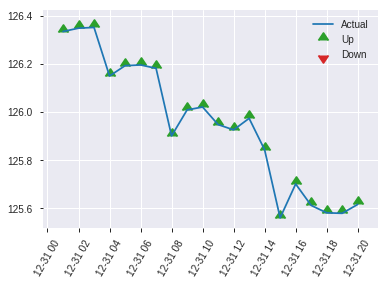


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2543932758156757
RMSE: 0.504374142691391
LogLoss: 0.7022682898629431
Mean Per-Class Error: 0.47004792332268375
AUC: 0.5166890869345889
pr_auc: 0.5193272089057158
Gini: 0.03337817386917785
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3802894949913025: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    303  0.9967   (303.0/304.0)
1      0    313  0        (0.0/313.0)
Total  1    616  0.4911   (303.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.380289     0.673843   398
max f2                       0.380289     0.837794   398
max f0point5                 0.380289     0.563558   398
max accuracy                 0.592176     0.526742   122
max precision                0.749543     1          0
max recall                   0.380289     1          398
max specificity              0.749543     1          0
max absolute_mcc             0.592176     0.0666732  122
max min_per_class_accuracy   0.550948     0.501597   201
max mean_per_class_accuracy  0.592176     0.529952   122

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 55.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.691547           0.84482   0.84482            0.428571         0.71324   0.428571                    0.71324             0.00958466      0.00958466                 -15.518   -15.518
    2        0.0210697                   0.678928           0.985623  0.909806           0.5              0.684773  0.461538                    0.700102            0.00958466      0.0191693                  -1.4377   -9.01942
    3        0.0307942                   0.668209           1.64271   1.14125            0.833333         0.672244  0.578947                    0.691304            0.0159744       0.0351438                  64.2705   14.1248
    4        0.0405186                   0.660716           0.985623  1.1039             0.5              0.664746  0.56                        0.68493             0.00958466      0.0447284                  -1.4377   10.3898
    5        0.0502431                   0.651394           0.985623  1.08101            0.5              0.658179  0.548387                    0.679753            0.00958466      0.0543131                  -1.4377   8.10059
    6        0.100486                    0.63091            0.89024   0.985623           0.451613         0.639558  0.5                         0.659655            0.0447284       0.0990415                  -10.976   -1.4377
    7        0.150729                    0.616037           1.14459   1.03861            0.580645         0.623732  0.526882                    0.647681            0.057508        0.15655                    14.4594   3.86135
    8        0.200972                    0.603362           1.01742   1.03331            0.516129         0.609305  0.524194                    0.638087            0.0511182       0.207668                   1.74173   3.33144
    9        0.299838                    0.587384           1.19567   1.08685            0.606557         0.596222  0.551351                    0.624283            0.118211        0.325879                   19.5674   8.68491
    10       0.400324                    0.569031           0.89024   1.0375             0.451613         0.57827   0.526316                    0.612733            0.0894569       0.415335                   -10.976   3.74979
    11       0.50081                     0.550515           0.858446  1.00157            0.435484         0.558948  0.508091                    0.601941            0.086262        0.501597                   -14.1554  0.15716
    12       0.599676                    0.538256           1.09873   1.01759            0.557377         0.544198  0.516216                    0.592421            0.108626        0.610224                   9.87273   1.75892
    13       0.700162                    0.521837           0.985623  1.013              0.5              0.529761  0.513889                    0.583428            0.0990415       0.709265                   -1.4377   1.30014
    14       0.799028                    0.504556           1.0341    1.01561            0.52459          0.513494  0.515213                    0.574775            0.102236        0.811502                   3.40963   1.56115
    15       0.899514                    0.476601           0.858446  0.998054           0.435484         0.493075  0.506306                    0.565648            0.086262        0.897764                   -14.1554  -0.194572
    16       1                           0.329944           1.01742   1                  0.516129         0.439555  0.507293                    0.552978      

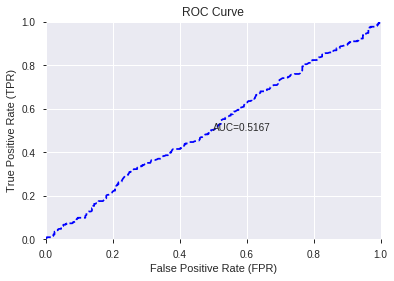

This function is available for GLM models only


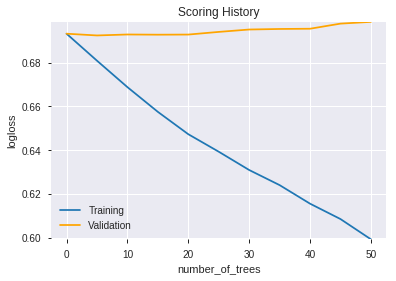

--2019-08-24 13:50:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.1.72
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.1.72|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.co

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_134901',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_134901',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_805c',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190824_135138  0.522233  0.745136              0.493374  0.520004  0.270404
1  DeepLearning_grid_1_AutoML_20190824_135138_model_5  0.512459  0.704173              0.498355  0.503504  0.253516
2  DeepLearning_grid_1_AutoML_20190824_135138_model_6  0.508639  0.701122              0.500000  0.503214  0.253224
3  DeepLearning_grid_1_AutoML_20190824_135138_model_3  0.506064  0.728191              0.500000  0.510645  0.260758
4  DeepLearning_grid_1_AutoML_20190824_135138_model_4  0.505507  0.756136              0.500000  0.523815  0.274382
5  DeepLearning_grid_1_AutoML_20190824_135138_model_9  0.500000  0.693042              0.500000  0.499948  0.249948
6  DeepLearning_grid_1_AutoML_20190824_135138_model_1  0.499832  0.833785              0.500000  0.528938  0.279775
7  DeepLearning_grid_1_AutoML_20190824_135138_model_2  0.483605  0.863798              0.498355  0.535504  0.286764
8  DeepLearning_grid_1_AutoML_20190824_135138_model_7  0.482218  0.785530              0.498355  0.529779  0.280666
9  DeepLearning_grid_1_AutoML_20190824_135138_model_8  0.476627  0.694801              0.500000  0.500825  0.250826

variable  relative_importance  scaled_importance  percentage
0                    BOP             1.000000           1.000000    0.030035
1            CDLDOJISTAR             0.957536           0.957536    0.028760
2                    EXP             0.930463           0.930463    0.027947
3      CDLDARKCLOUDCOVER             0.906037           0.906037    0.027213
4                   SINH             0.841440           0.841440    0.025273
5              CORREL_12             0.827220           0.827220    0.024846
6         CDLRICKSHAWMAN             0.803834           0.803834    0.024143
7            CDLPIERCING             0.794301           0.794301    0.023857
8           CDLTHRUSTING             0.789467           0.789467    0.023712
9      CDLSTALLEDPATTERN             0.786519           0.786519    0.023623
10                  hour             0.777381           0.777381    0.023349
11             CORREL_30             0.765883           0.765883    0.023004
12                  COSH             0.760749           0.760749    0.022849
13    CDLSEPARATINGLINES             0.754351           0.754351    0.022657
14             CDLHAMMER             0.749041           0.749041    0.022498
15         days_in_month             0.734040           0.734040    0.022047
16            CDL3INSIDE             0.722287           0.722287    0.021694
17        STOCHRSI_fastk             0.711399           0.711399    0.021367
18         CDLHANGINGMAN             0.702061           0.702061    0.021087
19                BETA_8             0.682645           0.682645    0.020503
20               CDLDOJI             0.681963           0.681963    0.020483
21                   TAN             0.665628           0.665628    0.019992
22     CDLLONGLEGGEDDOJI             0.642981           0.642981    0.019312
23        is_month_start             0.636494           0.636494    0.019117
24                   day             0.636192           0.636192    0.019108
25      is_quarter_start             0.634962           0.634962    0.019071
26       CDLADVANCEBLOCK             0.627279           0.627279    0.018841
27             CDLTAKURI             0.623056           0.623056    0.018714
28        CDLMATCHINGLOW             0.613154           0.613154    0.018416
29       CDLLADDERBOTTOM             0.612137           0.612137    0.018386
30     CDLGRAVESTONEDOJI             0.611814           0.611814    0.018376
31    CDLIDENTICAL3CROWS             0.610763           0.610763    0.018344
32          HT_TRENDMODE             0.606470           0.606470    0.018215
33     CDL3WHITESOLDIERS             0.605385           0.605385    0.018183
34        CDLEVENINGSTAR             0.605300           0.605300    0.018180
35          is_month_end             0.600981           0.600981    0.018051
36      CDLDRAGONFLYDOJI             0.592836           0.592836    0.017806
37       CDLHOMINGPIGEON             0.590021           0.590021    0.017721
38    CDLEVENINGDOJISTAR             0.579588           0.579588    0.017408
39          CDLTASUKIGAP             0.577968           0.577968    0.017359
40                TRANGE             0.573014           0.573014    0.017211
41              CORREL_8             0.565417           0.565417    0.016982
42                   OBV             0.559246           0.559246    0.016797
43     CDLINVERTEDHAMMER             0.548263           0.548263    0.016467
44             CORREL_14             0.484657           0.484657    0.014557
45       CDLSHOOTINGSTAR             0.476339           0.476339    0.014307
46  HT_PHASOR_quadrature             0.470332           0.470332    0.014127
47   CDLGAPSIDESIDEWHITE             0.440754           0.440754    0.013238
48        CDLMORNINGSTAR             0.421822           0.421822    0.012670
49             CDLONNECK             0.402678           0.402678    0.012095

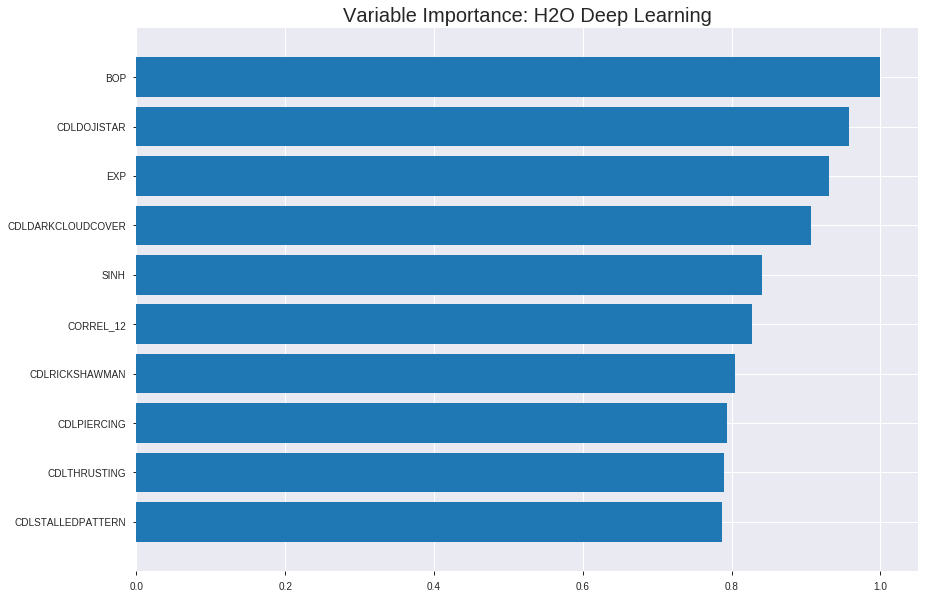

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190824_135138


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25002172898741587
RMSE: 0.5000217285152875
LogLoss: 0.7073359438496184
Mean Per-Class Error: 0.42058576616496257
AUC: 0.5965236115041473
pr_auc: 0.59989887714795
Gini: 0.1930472230082947
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3367083131745552: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      125  1978  0.9406   (1978.0/2103.0)
1      63   2150  0.0285   (63.0/2213.0)
Total  188  4128  0.4729   (2041.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336708     0.678126  335
max f2                       0.000269813  0.840295  399
max f0point5                 0.559737     0.593368  198
max accuracy                 0.592145     0.579008  167
max precision                0.999752     1         0
max recall                   0.000269813  1         399
max specificity              0.999752     1         0
max absolute_mcc             0.592145     0.158838  167
max min_per_class_accuracy   0.588016     0.57632   171
max mean_per_class_accuracy  0.592145     0.579414  167

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 57.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101946                   0.849546           1.68434   1.68434            0.863636         0.924889  0.863636                    0.924889            0.0171713       0.0171713                  68.4345    68.4345
    2        0.0201576                   0.77522            1.49674   1.59162            0.767442         0.799605  0.816092                    0.862967            0.0149119       0.0320831                  49.6737    59.1619
    3        0.0301205                   0.758714           1.2246    1.47022            0.627907         0.766     0.753846                    0.830893            0.0122006       0.0442838                  22.4603    47.0221
    4        0.0400834                   0.747941           1.17925   1.3979             0.604651         0.753463  0.716763                    0.811648            0.0117488       0.0560325                  17.9247    39.7898
    5        0.0500463                   0.739697           1.26996   1.37243            0.651163         0.743954  0.703704                    0.798172            0.0126525       0.068685                   26.9959    37.2429
    6        0.100093                    0.705448           1.16476   1.26859            0.597222         0.721335  0.650463                    0.759753            0.0582919       0.126977                   16.4759    26.8594
    7        0.150139                    0.686672           1.1467    1.22796            0.587963         0.695422  0.62963                     0.738309            0.0573882       0.184365                   14.67      22.7963
    8        0.200185                    0.668799           1.11058   1.19862            0.569444         0.677673  0.614583                    0.72315             0.0555807       0.239946                   11.0584    19.8618
    9        0.300046                    0.640375           1.12674   1.17469            0.577726         0.655105  0.602317                    0.700503            0.112517        0.352463                   12.6736    17.4694
    10       0.400139                    0.614393           1.16476   1.17221            0.597222         0.628021  0.601042                    0.682372            0.116584        0.469047                   16.4759    17.2209
    11       0.5                         0.588077           1.04981   1.14776            0.538283         0.601044  0.588508                    0.666129            0.104835        0.573882                   4.98101    14.7763
    12       0.600093                    0.560656           0.993205  1.12198            0.509259         0.573924  0.57529                     0.65075             0.0994126       0.673294                   -0.679487  12.1984
    13       0.699954                    0.530339           0.828083  1.08005            0.424594         0.545618  0.55379                     0.635751            0.0826932       0.755987                   -17.1917   8.00534
    14       0.800046                    0.492732           0.875826  1.0545             0.449074         0.512773  0.540689                    0.620365            0.0876638       0.843651                   -12.4174   5.45029
    15       0.899907                    0.430558           0.859758  1.03289            0.440835         0.467051  0.529609                    0.603352            0.0858563       0.929507                   -14.0242   3.28924
    16       1                           0.000111371        0.704273  1                  0.361111         0.305681  0.512743                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.27119063952087896
RMSE: 0.5207596753982388
LogLoss: 0.7399435674995283
Mean Per-Class Error: 0.497557003257329
AUC: 0.47702504301884413
pr_auc: 0.48070351093681857
Gini: -0.04594991396231174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19482943092250324: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    618   0.9984   (618.0/619.0)
1      0    614   0        (0.0/614.0)
Total  1    1232  0.5012   (618.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.194829     0.665222   398
max f2                       0.194829     0.83243    398
max f0point5                 0.194829     0.553952   398
max accuracy                 0.969752     0.504461   1
max precision                0.999951     1          0
max recall                   0.194829     1          398
max specificity              0.999951     1          0
max absolute_mcc             0.494465     0.0705966  309
max min_per_class_accuracy   0.591843     0.481422   189
max mean_per_class_accuracy  0.969752     0.502443   1

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 58.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.774574           0.61789   0.61789            0.307692         0.872768  0.307692                    0.872768            0.00651466      0.00651466                 -38.211   -38.211
    2        0.0202758                   0.749873           1.17142   0.883583           0.583333         0.760521  0.44                        0.81889             0.0114007       0.0179153                  17.1417   -11.6417
    3        0.0300081                   0.735286           0.836726  0.868386           0.416667         0.741682  0.432432                    0.793849            0.00814332      0.0260586                  -16.3274  -13.1614
    4        0.0405515                   0.727577           1.08131   0.923746           0.538462         0.731492  0.46                        0.777636            0.0114007       0.0374593                  8.13079   -7.62541
    5        0.0502839                   0.719533           1.00407   0.939293           0.5              0.723818  0.467742                    0.76722             0.00977199      0.0472313                  0.407166  -6.07072
    6        0.100568                    0.699547           0.906903  0.923098           0.451613         0.709301  0.459677                    0.738261            0.0456026       0.0928339                  -9.30966  -7.69019
    7        0.150041                    0.680065           1.08637   0.976935           0.540984         0.689747  0.486486                    0.722264            0.0537459       0.14658                    8.63726   -2.30654
    8        0.200324                    0.663467           0.939293  0.967486           0.467742         0.672477  0.481781                    0.709767            0.0472313       0.193811                   -6.07072  -3.25139
    9        0.300081                    0.638331           0.963256  0.96608            0.479675         0.64999   0.481081                    0.689895            0.0960912       0.289902                   -3.67443  -3.39202
    10       0.399838                    0.615312           0.946929  0.961302           0.471545         0.62579   0.478702                    0.673901            0.0944625       0.384365                   -5.30706  -3.86981
    11       0.500406                    0.591673           0.971682  0.963388           0.483871         0.603596  0.479741                    0.659772            0.0977199       0.482085                   -2.83177  -3.6612
    12       0.600162                    0.571652           1.07754   0.982362           0.536585         0.581415  0.489189                    0.646748            0.107492        0.589577                   7.75403   -1.7638
    13       0.699919                    0.544085           1.01223   0.98662            0.504065         0.558569  0.491309                    0.63418             0.100977        0.690554                   1.22348   -1.33803
    14       0.799676                    0.512988           0.848971  0.969449           0.422764         0.529533  0.482759                    0.621125            0.0846906       0.775244                   -15.1029  -3.05515
    15       0.899432                    0.477247           1.09387   0.983248           0.544715         0.500773  0.48963                     0.607777            0.109121        0.884365                   9.38667   -1.67522
    16       1                           0.0374486          1.14982   1                  0.572581         0.410158  0.497972                    0.587


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 13:51:39  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 13:51:39  0.131 sec   69612 obs/sec     1         1             4316       0.520753         0.76656             -0.0854407     0.5289          0.532719           1.01947          0.487257                         0.540301           0.824181              -0.167721        0.476612          0.482979             0.772363           0.501217
    2019-08-24 13:51:40  0.653 sec   80074 obs/sec     10        10            43160      0.500022         0.707336            -0.000736959   0.596524        0.599899           1.68434          0.472892                         0.52076            0.739944              -0.0847804       0.477025          0.480704             0.61789            0.501217

Variable Importances: 


variable              relative_importance    scaled_importance    percentage
--------------------  ---------------------  -------------------  --------------------
BOP                   1.0                    1.0                  0.030035307152686066
CDLDOJISTAR           0.9575360417366028     0.9575360417366028   0.02875988912332609
EXP                   0.930463433265686      0.930463433265686    0.027946755012477696
CDLDARKCLOUDCOVER     0.9060370922088623     0.9060370922088623   0.027213102356219727
SINH                  0.8414400815963745     0.8414400815963745   0.025272911301328336
---                   ---                    ---                  ---
CDLSHOOTINGSTAR       0.4763394594192505     0.4763394594192505   0.01430700197260163
HT_PHASOR_quadrature  0.4703315496444702     0.4703315496444702   0.014126552557170479
CDLGAPSIDESIDEWHITE   0.4407535195350647     0.4407535195350647   0.013238167337863087
CDLMORNINGSTAR        0.4218215346336365     0.4218215346336365   0.012669539356338676
CDLONNECK             0.4026782512664795     0.4026782512664795   0.01209456496049521


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5348460291734197)

('F1', 0.6753246753246752)

('auc', 0.5222328484950395)

('logloss', 0.7451355992299856)

('mean_per_class_error', 0.46437804775517066)

('rmse', 0.5200037144821957)

('mse', 0.27040386307528097)

deeplearning prediction progress: |███████████████████████████████████████| 100%


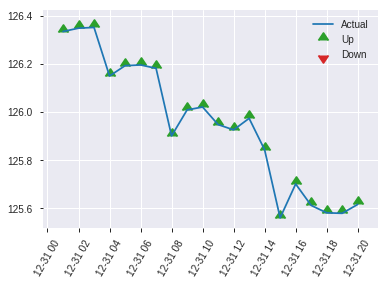


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27040386307528097
RMSE: 0.5200037144821957
LogLoss: 0.7451355992299856
Mean Per-Class Error: 0.46437804775517066
AUC: 0.5222328484950395
pr_auc: 0.5293799490658431
Gini: 0.04446569699007896
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34413064414765365: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    299  0.9836   (299.0/304.0)
1      1    312  0.0032   (1.0/313.0)
Total  6    611  0.4862   (300.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.344131     0.675325   393
max f2                       0.344131     0.837359   393
max f0point5                 0.344131     0.565832   393
max accuracy                 0.647292     0.534846   175
max precision                0.999961     1          0
max recall                   0.182304     1          399
max specificity              0.999961     1          0
max absolute_mcc             0.647292     0.0716349  175
max min_per_class_accuracy   0.637854     0.514377   192
max mean_per_class_accuracy  0.647292     0.535622   175

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 62.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.847946           1.12643   1.12643            0.571429         0.92679   0.571429                    0.92679             0.0127796       0.0127796                  12.6426   12.6426
    2        0.0210697                   0.791118           0.985623  1.06144            0.5              0.810078  0.538462                    0.872923            0.00958466      0.0223642                  -1.4377   6.14402
    3        0.0307942                   0.772399           1.31416   1.14125            0.666667         0.775636  0.578947                    0.842201            0.0127796       0.0351438                  31.4164   14.1248
    4        0.0405186                   0.763387           0.985623  1.1039             0.5              0.768497  0.56                        0.824512            0.00958466      0.0447284                  -1.4377   10.3898
    5        0.0502431                   0.756551           1.64271   1.20818            0.833333         0.760646  0.612903                    0.812151            0.0159744       0.0607029                  64.2705   20.8183
    6        0.100486                    0.740043           1.14459   1.17639            0.580645         0.748081  0.596774                    0.780116            0.057508        0.118211                   14.4594   17.6389
    7        0.150729                    0.721633           0.826652  1.05981            0.419355         0.731004  0.537634                    0.763745            0.0415335       0.159744                   -17.3348  5.98097
    8        0.200972                    0.706588           1.01742   1.04921            0.516129         0.713814  0.532258                    0.751263            0.0511182       0.210863                   1.74173   4.92116
    9        0.299838                    0.682379           0.969465  1.02292            0.491803         0.694891  0.518919                    0.732675            0.0958466       0.306709                   -3.05348  2.29168
    10       0.400324                    0.655594           1.1128    1.04548            0.564516         0.669848  0.530364                    0.716905            0.111821        0.41853                    11.28     4.54787
    11       0.50081                     0.637272           0.953829  1.02709            0.483871         0.646211  0.521036                    0.70272             0.0958466       0.514377                   -4.61713  2.70893
    12       0.599676                    0.615904           1.09873   1.0389             0.557377         0.626908  0.527027                    0.690222            0.108626        0.623003                   9.87273   3.88999
    13       0.700162                    0.586482           0.826652  1.00844            0.419355         0.601458  0.511574                    0.677482            0.0830671       0.70607                    -17.3348  0.843835
    14       0.799028                    0.5543             1.00178   1.00761            0.508197         0.56972   0.511156                    0.664149            0.0990415       0.805112                   0.178076  0.761459
    15       0.899514                    0.516102           0.922034  0.998054           0.467742         0.53617   0.506306                    0.649852            0.0926518       0.897764                   -7.79656  -0.194572
    16       1                           0.182304           1.01742   1                  0.516129         0.451608  0.507293                    0.629931     

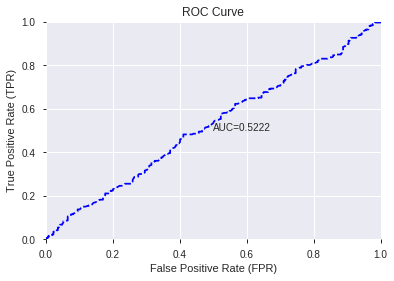

This function is available for GLM models only


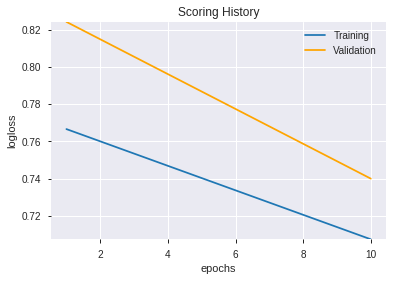

--2019-08-24 14:13:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190824_135138',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190824_135138',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_805c'

['BOP',
 'CDLDOJISTAR',
 'EXP',
 'CDLDARKCLOUDCOVER',
 'SINH',
 'CORREL_12',
 'CDLRICKSHAWMAN',
 'CDLPIERCING',
 'CDLTHRUSTING',
 'CDLSTALLEDPATTERN',
 'hour',
 'CORREL_30',
 'COSH',
 'CDLSEPARATINGLINES',
 'CDLHAMMER',
 'days_in_month',
 'CDL3INSIDE',
 'STOCHRSI_fastk',
 'CDLHANGINGMAN',
 'BETA_8',
 'CDLDOJI',
 'TAN',
 'CDLLONGLEGGEDDOJI',
 'is_month_start',
 'day',
 'is_quarter_start',
 'CDLADVANCEBLOCK',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'CDLLADDERBOTTOM',
 'CDLGRAVESTONEDOJI',
 'CDLIDENTICAL3CROWS',
 'HT_TRENDMODE',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGSTAR',
 'is_month_end',
 'CDLDRAGONFLYDOJI',
 'CDLHOMINGPIGEON',
 'CDLEVENINGDOJISTAR',
 'CDLTASUKIGAP',
 'TRANGE',
 'CORREL_8',
 'OBV',
 'CDLINVERTEDHAMMER',
 'CORREL_14',
 'CDLSHOOTINGSTAR',
 'HT_PHASOR_quadrature',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGSTAR',
 'CDLONNECK']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_141408_model_1  0.508507  0.693044                   0.5  0.499948  0.249948

variable  relative_importance  scaled_importance  percentage
0                    BOP             0.008895           1.000000    0.083954
1         STOCHRSI_fastk             0.006274           0.705362    0.059218
2   HT_PHASOR_quadrature             0.005198           0.584422    0.049064
3      CDLDARKCLOUDCOVER             0.004576           0.514469    0.043192
4           CDLTHRUSTING             0.004558           0.512382    0.043016
5                   hour             0.003925           0.441209    0.037041
6         CDLRICKSHAWMAN             0.003877           0.435854    0.036592
7                    OBV             0.003821           0.429596    0.036066
8         CDLEVENINGSTAR             0.003678           0.413529    0.034717
9        CDLHOMINGPIGEON             0.003398           0.382009    0.032071
10                BETA_8             0.003120           0.350776    0.029449
11                   TAN             0.002972           0.334082    0.028047
12    CDLIDENTICAL3CROWS             0.002740           0.308023    0.025860
13   CDLGAPSIDESIDEWHITE             0.002535           0.284981    0.023925
14           CDLPIERCING             0.002405           0.270397    0.022701
15          CDLTASUKIGAP             0.002396           0.269307    0.022609
16       CDLLADDERBOTTOM             0.002306           0.259300    0.021769
17             CDLONNECK             0.002303           0.258870    0.021733
18             CDLHAMMER             0.002293           0.257818    0.021645
19            CDL3INSIDE             0.002174           0.244357    0.020515
20       CDLADVANCEBLOCK             0.002068           0.232435    0.019514
21        CDLMATCHINGLOW             0.001902           0.213867    0.017955
22                   day             0.001844           0.207324    0.017406
23          HT_TRENDMODE             0.001823           0.204915    0.017203
24     CDLINVERTEDHAMMER             0.001809           0.203392    0.017076
25      is_quarter_start             0.001717           0.193014    0.016204
26        is_month_start             0.001646           0.185052    0.015536
27         CDLHANGINGMAN             0.001636           0.183946    0.015443
28             CORREL_30             0.001468           0.165069    0.013858
29     CDLLONGLEGGEDDOJI             0.001340           0.150609    0.012644
30     CDLGRAVESTONEDOJI             0.001300           0.146195    0.012274
31               CDLDOJI             0.001235           0.138861    0.011658
32             CORREL_12             0.001158           0.130146    0.010926
33         days_in_month             0.001110           0.124767    0.010475
34              CORREL_8             0.001020           0.114709    0.009630
35     CDLSTALLEDPATTERN             0.000960           0.107870    0.009056
36     CDL3WHITESOLDIERS             0.000946           0.106390    0.008932
37          is_month_end             0.000875           0.098373    0.008259
38             CORREL_14             0.000864           0.097126    0.008154
39             CDLTAKURI             0.000738           0.082993    0.006968
40    CDLSEPARATINGLINES             0.000731           0.082156    0.006897
41                TRANGE             0.000613           0.068872    0.005782
42       CDLSHOOTINGSTAR             0.000609           0.068425    0.005745
43                   EXP             0.000588           0.066110    0.005550
44                  COSH             0.000585           0.065733    0.005518
45                  SINH             0.000580           0.065190    0.005473
46        CDLMORNINGSTAR             0.000488           0.054821    0.004602
47    CDLEVENINGDOJISTAR             0.000430           0.048372    0.004061
48      CDLDRAGONFLYDOJI             0.000386           0.043384    0.003642
49           CDLDOJISTAR             0.000040           0.004470    0.000375

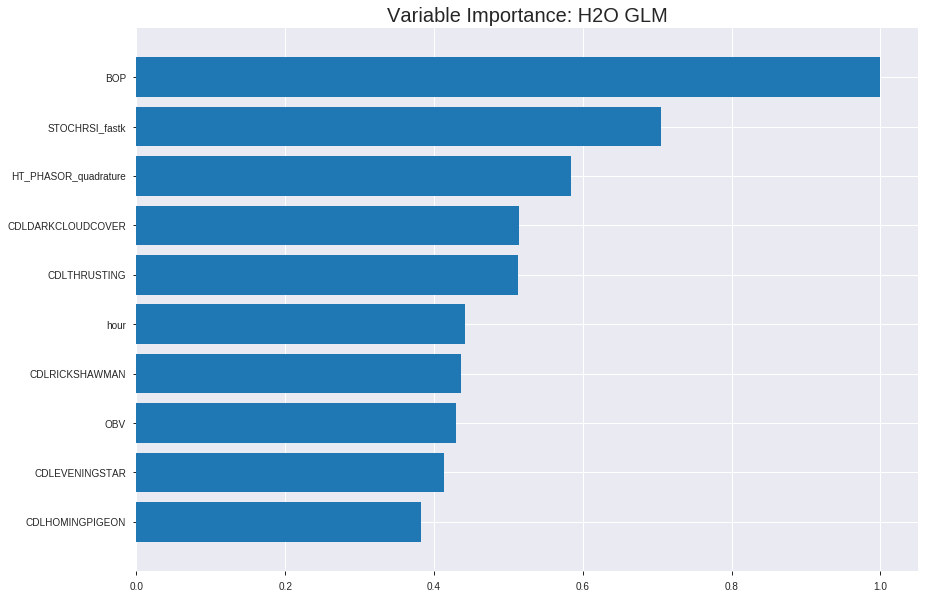

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_141408_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24926157926637052
RMSE: 0.49926103319443077
LogLoss: 0.6916685916717942
Null degrees of freedom: 4315
Residual degrees of freedom: 4265
Null deviance: 5980.442637223593
Residual deviance: 5970.483283310928
AIC: 6072.483283310928
AUC: 0.556488707737682
pr_auc: 0.567843072840894
Gini: 0.112977415475364
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49556149878953065: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      4    2099  0.9981   (2099.0/2103.0)
1      0    2213  0        (0.0/2213.0)
Total  4    4312  0.4863   (2099.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.495561     0.678314   395
max f2                       0.495561     0.84055    395
max f0point5                 0.507413     0.572895   316
max accuracy                 0.510806     0.550046   246
max precision                0.554948     1          0
max recall                   0.495561     1          395
max specificity              0.554948     1          0
max absolute_mcc             0.510806     0.0968573  246
max min_per_class_accuracy   0.512276     0.538279   215
max mean_per_class_accuracy  0.510806     0.547142   246

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.526338           1.59569   1.59569            0.818182         0.536001  0.818182                    0.536001            0.0162675       0.0162675                  59.5695   59.5695
    2        0.0201576                   0.522625           1.13389   1.36745            0.581395         0.523715  0.701149                    0.529928            0.0112969       0.0275644                  13.3892   36.7447
    3        0.0301205                   0.521675           1.08854   1.27519            0.55814          0.522067  0.653846                    0.527328            0.010845        0.0384094                  8.8536    27.5192
    4        0.0400834                   0.521008           1.13389   1.24007            0.581395         0.521282  0.635838                    0.525825            0.0112969       0.0497063                  13.3892   24.0071
    5        0.0500463                   0.520471           1.08854   1.2099             0.55814          0.52075   0.62037                     0.524815            0.010845        0.0605513                  8.8536    20.9904
    6        0.100093                    0.519126           1.12864   1.16927            0.578704         0.519745  0.599537                    0.52228             0.0564844       0.117036                   12.8642   16.9273
    7        0.150139                    0.518146           1.11961   1.15272            0.574074         0.518617  0.591049                    0.521059            0.0560325       0.173068                   11.9613   15.272
    8        0.200185                    0.517204           1.07447   1.13316            0.550926         0.517663  0.581019                    0.52021             0.0537732       0.226841                   7.44674   13.3157
    9        0.300046                    0.515437           1.05886   1.10843            0.542923         0.51631   0.56834                     0.518912            0.105739        0.33258                    5.88602   10.8429
    10       0.400139                    0.51389            1.03384   1.08977            0.530093         0.514647  0.558772                    0.517845            0.103479        0.43606                    3.38363   8.97704
    11       0.5                         0.512289           1.02718   1.07727            0.526682         0.513083  0.552363                    0.516894            0.102576        0.538635                   2.71849   7.72707
    12       0.600093                    0.511006           1.06092   1.07454            0.543981         0.511644  0.550965                    0.516019            0.106191        0.644826                   6.09237   7.45441
    13       0.699954                    0.509667           0.873333  1.04584            0.447796         0.510323  0.536246                    0.515206            0.0872119       0.732038                   -12.6667  4.58377
    14       0.800046                    0.508313           0.943545  1.03304            0.483796         0.509017  0.529684                    0.514432            0.0944419       0.82648                    -5.64551  3.304
    15       0.899907                    0.506597           0.850708  1.01281            0.436195         0.507503  0.51931                     0.513663            0.0849526       0.911432                   -14.9292  1.2807
    16       1                           0.466144           0.884855  1                  0.453704         0.504475  0.512743                    0.512743            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2501930902772547
RMSE: 0.5001930530077909
LogLoss: 0.6935332733082461
Null degrees of freedom: 1232
Residual degrees of freedom: 1182
Null deviance: 1710.357041745574
Residual deviance: 1710.2530519781349
AIC: 1812.2530519781349
AUC: 0.49840290896844236
pr_auc: 0.49936407564593094
Gini: -0.0031941820631152806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5021571545549284: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    615   0.9935   (615.0/619.0)
1      1    613   0.0016   (1.0/614.0)
Total  5    1228  0.4996   (616.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.502157     0.665581   394
max f2                       0.498239     0.83243    398
max f0point5                 0.505555     0.5564     354
max accuracy                 0.508213     0.509327   302
max precision                0.534621     0.8        4
max recall                   0.498239     1          398
max specificity              0.552826     0.998384   0
max absolute_mcc             0.505555     0.0480725  354
max min_per_class_accuracy   0.512487     0.498371   211
max mean_per_class_accuracy  0.505555     0.511124   354

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.530517           1.39025   1.39025            0.692308         0.537816  0.692308                    0.537816            0.014658        0.014658                   39.0253    39.0253
    2        0.0202758                   0.525386           0.836726  1.12456            0.416667         0.528265  0.56                        0.533231            0.00814332      0.0228013                  -16.3274   12.456
    3        0.0300081                   0.522696           1.00407   1.08548            0.5              0.523926  0.540541                    0.530214            0.00977199      0.0325733                  0.407166   8.54829
    4        0.0405515                   0.521588           0.61789   0.963909           0.307692         0.522156  0.48                        0.528119            0.00651466      0.0390879                  -38.211    -3.60912
    5        0.0502839                   0.521055           1.33876   1.03646            0.666667         0.521352  0.516129                    0.526809            0.0130293       0.0521173                  33.8762    3.64611
    6        0.100568                    0.518906           1.03646   1.03646            0.516129         0.519911  0.516129                    0.52336             0.0521173       0.104235                   3.64611    3.64611
    7        0.150041                    0.517761           0.954691  1.0095             0.47541          0.518243  0.502703                    0.521673            0.0472313       0.151466                   -4.53089   0.949908
    8        0.200324                    0.516977           0.842125  0.967486           0.419355         0.51742   0.481781                    0.520605            0.0423453       0.193811                   -15.7875   -3.25139
    9        0.300081                    0.515671           0.979582  0.971507           0.487805         0.516333  0.483784                    0.519185            0.0977199       0.291531                   -2.04179   -2.84928
    10       0.399838                    0.513952           1.07754   0.997962           0.536585         0.514827  0.496957                    0.518098            0.107492        0.399023                   7.75403    -0.203831
    11       0.500406                    0.51245            1.00407   0.99919            0.5              0.513284  0.497569                    0.51713             0.100977        0.5                        0.407166   -0.0810373
    12       0.600162                    0.510973           0.979582  0.995931           0.487805         0.511756  0.495946                    0.516237            0.0977199       0.59772                    -2.04179   -0.406946
    13       0.699919                    0.509693           0.995908  0.995927           0.495935         0.510312  0.495944                    0.515392            0.0993485       0.697068                   -0.409152  -0.40726
    14       0.799676                    0.508211           1.12652   1.01222            0.560976         0.508998  0.504057                    0.514595            0.112378        0.809446                   12.6519    1.22183
    15       0.899432                    0.506668           0.914277  1.00136            0.455285         0.507492  0.498647                    0.513807            0.0912052       0.900651                   -8.57234   0.135551
    16       1                           0.491717           0.987877  1                  0.491935         0.504815  0.497972        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 14:14:09  0.000 sec   2            3         51            1.38334           1.38707
    2019-08-24 14:14:09  0.027 sec   4            1.9       51            1.38223           1.38709
    2019-08-24 14:14:09  0.046 sec   6            1.2       51            1.38077           1.38719
    2019-08-24 14:14:09  0.070 sec   8            0.72      51            1.379             1.38746
    2019-08-24 14:14:09  0.093 sec   10           0.44      51            1.37705           1.38799
    2019-08-24 14:14:09  0.121 sec   12           0.28      51            1.37512           1.38883

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.520259319286872)

('F1', 0.6731182795698925)

('auc', 0.5085074407264166)

('logloss', 0.693043633409426)

('mean_per_class_error', 0.48059946191356984)

('rmse', 0.4999483022497331)

('mse', 0.24994830492239048)

glm prediction progress: |████████████████████████████████████████████████| 100%


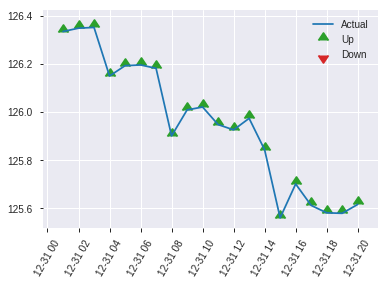


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24994830492239048
RMSE: 0.4999483022497331
LogLoss: 0.693043633409426
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 855.2856750512815
Residual deviance: 855.2158436272316
AIC: 957.2158436272316
AUC: 0.5085074407264166
pr_auc: 0.5166554336986556
Gini: 0.017014881452833253
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49927941700227474: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    304  1        (304.0/304.0)
1      0    313  0        (0.0/313.0)
Total  0    617  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.499279     0.673118   399
max f2                       0.499279     0.837346   399
max f0point5                 0.499279     0.562747   399
max accuracy                 0.51205      0.520259   213
max precision                0.551849     1          0
max recall                   0.499279     1          399
max specificity              0.551849     1          0
max absolute_mcc             0.501958     0.0796094  395
max min_per_class_accuracy   0.513004     0.511182   192
max mean_per_class_accuracy  0.51205      0.519401   213

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 51.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.524318           1.12643   1.12643            0.571429         0.536043  0.571429                    0.536043            0.0127796       0.0127796                  12.6426   12.6426
    2        0.0210697                   0.522094           0.985623  1.06144            0.5              0.522913  0.538462                    0.529983            0.00958466      0.0223642                  -1.4377   6.14402
    3        0.0307942                   0.52185            1.31416   1.14125            0.666667         0.521931  0.578947                    0.52744             0.0127796       0.0351438                  31.4164   14.1248
    4        0.0405186                   0.521465           0.985623  1.1039             0.5              0.521659  0.56                        0.526053            0.00958466      0.0447284                  -1.4377   10.3898
    5        0.0502431                   0.521241           1.31416   1.14459            0.666667         0.521368  0.580645                    0.525146            0.0127796       0.057508                   31.4164   14.4594
    6        0.100486                    0.519508           1.01742   1.08101            0.516129         0.520152  0.548387                    0.522649            0.0511182       0.108626                   1.74173   8.10059
    7        0.150729                    0.518635           0.826652  0.996221           0.419355         0.519114  0.505376                    0.521471            0.0415335       0.15016                    -17.3348  -0.37789
    8        0.200972                    0.517951           1.14459   1.03331            0.580645         0.51833   0.524194                    0.520686            0.057508        0.207668                   14.4594   3.33144
    9        0.299838                    0.516277           1.00178   1.02292            0.508197         0.517019  0.518919                    0.519477            0.0990415       0.306709                   0.178076  2.29168
    10       0.400324                    0.514465           1.04921   1.02952            0.532258         0.515445  0.522267                    0.518465            0.105431        0.412141                   4.92116   2.95171
    11       0.50081                     0.512955           0.985623  1.02071            0.5              0.513635  0.517799                    0.517496            0.0990415       0.511182                   -1.4377   2.07099
    12       0.599676                    0.511397           1.0341    1.02292            0.52459          0.512186  0.518919                    0.51662             0.102236        0.613419                   3.40963   2.29168
    13       0.700162                    0.510139           0.953829  1.013              0.483871         0.510762  0.513889                    0.515779            0.0958466       0.709265                   -4.61713  1.30014
    14       0.799028                    0.508864           0.840203  0.991621           0.42623          0.509571  0.503043                    0.515011            0.0830671       0.792332                   -15.9797  -0.837929
    15       0.899514                    0.507263           1.1128    1.00516            0.564516         0.508154  0.50991                     0.514245            0.111821        0.904153                   11.28     0.515787
    16       1                           0.499279           0.953829  1                  0.483871         0.5055    0.507293                    0.513366     

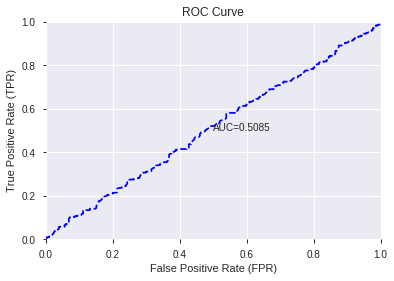

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


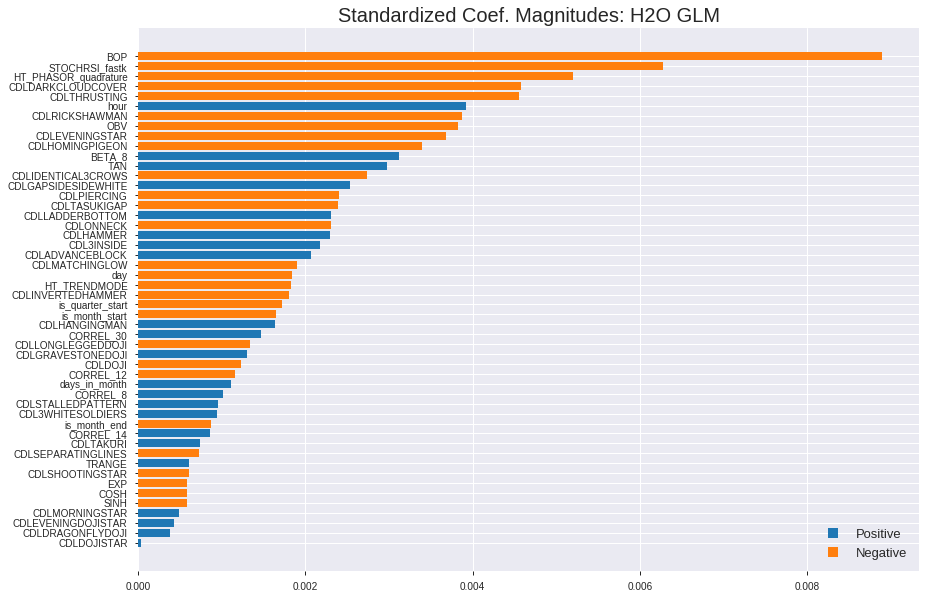

'log_likelihood'
--2019-08-24 14:14:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.165.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.165.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_141408_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_141408_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'STOCHRSI_fastk',
 'HT_PHASOR_quadrature',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING',
 'hour',
 'CDLRICKSHAWMAN',
 'OBV',
 'CDLEVENINGSTAR',
 'CDLHOMINGPIGEON',
 'BETA_8',
 'TAN',
 'CDLIDENTICAL3CROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDLPIERCING',
 'CDLTASUKIGAP',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'CDLHAMMER',
 'CDL3INSIDE',
 'CDLADVANCEBLOCK',
 'CDLMATCHINGLOW',
 'day',
 'HT_TRENDMODE',
 'CDLINVERTEDHAMMER',
 'is_quarter_start',
 'is_month_start',
 'CDLHANGINGMAN',
 'CORREL_30',
 'CDLLONGLEGGEDDOJI',
 'CDLGRAVESTONEDOJI',
 'CDLDOJI',
 'CORREL_12',
 'days_in_month',
 'CORREL_8',
 'CDLSTALLEDPATTERN',
 'CDL3WHITESOLDIERS',
 'is_month_end',
 'CORREL_14',
 'CDLTAKURI',
 'CDLSEPARATINGLINES',
 'TRANGE',
 'CDLSHOOTINGSTAR',
 'EXP',
 'COSH',
 'SINH',
 'CDLMORNINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLDOJISTAR']

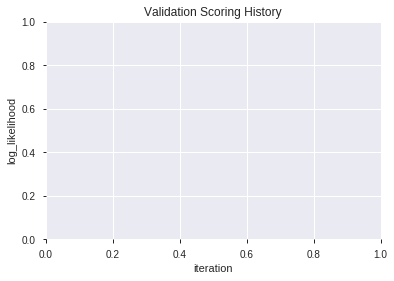

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_141515_model_6  0.501461  0.704523              0.500000  0.505434  0.255464
1  XGBoost_grid_1_AutoML_20190824_141515_model_1  0.495602  0.707128              0.500000  0.506674  0.256718
2  XGBoost_grid_1_AutoML_20190824_141515_model_2  0.490436  0.703460              0.500000  0.505010  0.255035
3               XGBoost_2_AutoML_20190824_141515  0.486805  0.716292              0.500000  0.510876  0.260995
4  XGBoost_grid_1_AutoML_20190824_141515_model_3  0.472413  0.707545              0.498355  0.507005  0.257054
5  XGBoost_grid_1_AutoML_20190824_141515_model_5  0.468077  0.736240              0.500000  0.519512  0.269893
6  XGBoost_grid_1_AutoML_20190824_141515_model_4  0.466280  0.706498              0.500000  0.506498  0.256540
7               XGBoost_3_AutoML_20190824_141515  0.464930  0.710285              0.500000  0.508288  0.258357
8  XGBoost_grid_1_AutoML_20190824_141515_model_7  0.462082  0.720188              0.498308  0.512941  0.263108
9               XGBoost_1_AutoML_20190824_141515  0.448167  0.723590              0.498355  0.514448  0.264656

variable  relative_importance  scaled_importance  percentage
0   HT_PHASOR_quadrature           748.199951           1.000000    0.098902
1                    BOP           741.499939           0.991045    0.098017
2                   COSH           677.247742           0.905169    0.089524
3                 TRANGE           644.514526           0.861420    0.085197
4                    TAN           614.118103           0.820794    0.081179
5              CORREL_30           599.356201           0.801064    0.079227
6                 BETA_8           583.272644           0.779568    0.077101
7              CORREL_12           530.175232           0.708601    0.070082
8                    OBV           471.033356           0.629555    0.062265
9               CORREL_8           446.713409           0.597051    0.059050
10             CORREL_14           354.210388           0.473417    0.046822
11                   day           336.227844           0.449382    0.044445
12                  hour           287.765015           0.384610    0.038039
13        STOCHRSI_fastk           201.651306           0.269515    0.026656
14                   EXP           129.249115           0.172747    0.017085
15         days_in_month            42.837734           0.057254    0.005663
16               CDLDOJI            35.536682           0.047496    0.004697
17          HT_TRENDMODE            25.106445           0.033556    0.003319
18        CDLRICKSHAWMAN            24.345062           0.032538    0.003218
19                  SINH            20.624390           0.027565    0.002726
20            CDL3INSIDE            16.233767           0.021697    0.002146
21          is_month_end            13.141275           0.017564    0.001737
22     CDLINVERTEDHAMMER             8.862875           0.011846    0.001172
23        CDLMATCHINGLOW             4.883952           0.006528    0.000646
24         CDLHANGINGMAN             4.404414           0.005887    0.000582
25           CDLDOJISTAR             3.814785           0.005099    0.000504

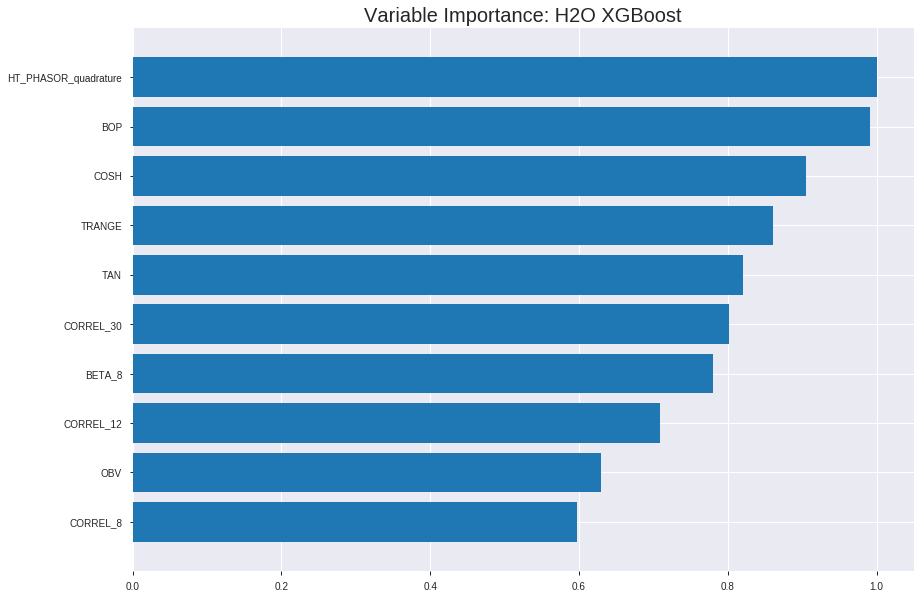

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_141515_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21851467541915306
RMSE: 0.46745553309288473
LogLoss: 0.629164119776861
Mean Per-Class Error: 0.2688559089407919
AUC: 0.8082528584925587
pr_auc: 0.8243030991965752
Gini: 0.6165057169851174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4899095783108159: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1265  838   0.3985   (838.0/2103.0)
1      389   1824  0.1758   (389.0/2213.0)
Total  1654  2662  0.2843   (1227.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48991      0.748308  229
max f2                       0.427959     0.854034  315
max f0point5                 0.533879     0.753524  160
max accuracy                 0.509855     0.730074  198
max precision                0.756871     1         0
max recall                   0.33212      1         386
max specificity              0.756871     1         0
max absolute_mcc             0.51694      0.46412   187
max min_per_class_accuracy   0.50878      0.726615  200
max mean_per_class_accuracy  0.516384     0.731144  188

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.672805           1.95029   1.95029            1                0.701434  1                           0.701434            0.0198825       0.0198825                  95.0294   95.0294
    2        0.0201576                   0.653248           1.95029   1.95029            1                0.661238  1                           0.681567            0.0194306       0.0393131                  95.0294   95.0294
    3        0.0301205                   0.641038           1.95029   1.95029            1                0.646705  1                           0.670036            0.0194306       0.0587438                  95.0294   95.0294
    4        0.0400834                   0.633077           1.81423   1.91647            0.930233         0.63622   0.982659                    0.661631            0.018075        0.0768188                  81.4227   91.6474
    5        0.0500463                   0.626818           1.85958   1.90515            0.953488         0.629968  0.976852                    0.655327            0.0185269       0.0953457                  85.9582   90.5148
    6        0.100093                    0.600392           1.84194   1.87355            0.944444         0.612217  0.960648                    0.633772            0.0921826       0.187528                   84.1944   87.3546
    7        0.150139                    0.582564           1.62524   1.79078            0.833333         0.591184  0.91821                     0.619576            0.0813376       0.268866                   62.5245   79.0779
    8        0.200185                    0.567537           1.68845   1.7652             0.865741         0.575182  0.905093                    0.608478            0.0845007       0.353366                   68.8449   76.5196
    9        0.300046                    0.545018           1.46159   1.66415            0.74942          0.555875  0.853282                    0.59097             0.145956        0.499322                   46.1589   66.415
    10       0.400139                    0.525225           1.20539   1.54939            0.618056         0.534412  0.794441                    0.576823            0.120651        0.619973                   20.539    54.9394
    11       0.5                         0.509186           1.04076   1.44781            0.533643         0.517043  0.742354                    0.564883            0.103931        0.723904                   4.076     44.7808
    12       0.600093                    0.492139           0.848739  1.34789            0.435185         0.500638  0.69112                     0.554168            0.0849526       0.808857                   -15.1261  34.7886
    13       0.699954                    0.475361           0.674231  1.25178            0.345708         0.483786  0.64184                     0.544126            0.0673294       0.876186                   -32.5769  25.1777
    14       0.800046                    0.454991           0.604952  1.17085            0.310185         0.465948  0.600348                    0.534346            0.0605513       0.936737                   -39.5048  17.0854
    15       0.899907                    0.423311           0.452504  1.09114            0.232019         0.439615  0.559475                    0.523834            0.0451875       0.981925                   -54.7496  9.11401
    16       1                           0.272926           0.180583  1                  0.0925926        0.391848  0.512743                    0.510623          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25149208554134916
RMSE: 0.5014898658411246
LogLoss: 0.6962358452218851
Mean Per-Class Error: 0.47675403745665224
AUC: 0.5203319949692948
pr_auc: 0.5102469168335703
Gini: 0.04066398993858966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3445929288864136: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    618   0.9984   (618.0/619.0)
1      0    614   0        (0.0/614.0)
Total  1    1232  0.5012   (618.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.344593     0.665222   398
max f2                       0.344593     0.83243    398
max f0point5                 0.393016     0.554328   378
max accuracy                 0.472007     0.522303   269
max precision                0.720348     1          0
max recall                   0.344593     1          398
max specificity              0.720348     1          0
max absolute_mcc             0.472007     0.0525057  269
max min_per_class_accuracy   0.506133     0.513029   199
max mean_per_class_accuracy  0.472007     0.523246   269

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 50.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105434                   0.650018           1.08131   1.08131            0.538462         0.675245  0.538462                    0.675245            0.0114007       0.0114007                  8.13079    8.13079
    2        0.0202758                   0.629009           1.00407   1.04423            0.5              0.63638   0.52                        0.65659             0.00977199      0.0211726                  0.407166   4.42345
    3        0.0300081                   0.620172           1.00407   1.03121            0.5              0.624821  0.513514                    0.646286            0.00977199      0.0309446                  0.407166   3.12087
    4        0.0405515                   0.606522           1.08131   1.04423            0.538462         0.612323  0.52                        0.637456            0.0114007       0.0423453                  8.13079    4.42345
    5        0.0502839                   0.602168           1.00407   1.03646            0.5              0.604261  0.516129                    0.631031            0.00977199      0.0521173                  0.407166   3.64611
    6        0.100568                    0.582867           1.06885   1.05266            0.532258         0.592268  0.524194                    0.61165             0.0537459       0.105863                   6.88505    5.26558
    7        0.150041                    0.569374           0.88885   0.998644           0.442623         0.576069  0.497297                    0.599918            0.0439739       0.149837                   -11.115    -0.135575
    8        0.200324                    0.558818           0.906903  0.975616           0.451613         0.56345   0.48583                     0.590764            0.0456026       0.19544                    -9.30966   -2.43838
    9        0.300081                    0.540839           1.19182   1.04749            0.593496         0.549458  0.521622                    0.577032            0.118893        0.314332                   19.1825    4.7491
    10       0.399838                    0.523041           0.963256  1.02647            0.479675         0.531681  0.511156                    0.565717            0.0960912       0.410423                   -3.67443   2.64749
    11       0.500406                    0.505832           1.03646   1.02848            0.516129         0.515049  0.512156                    0.555534            0.104235        0.514658                   3.64611    2.84818
    12       0.600162                    0.491126           0.995908  1.02307            0.495935         0.498048  0.509459                    0.545979            0.0993485       0.614007                   -0.409152  2.30676
    13       0.699919                    0.47736            1.06121   1.0285             0.528455         0.484428  0.512167                    0.537207            0.105863        0.71987                    6.1214     2.85045
    14       0.799676                    0.461092           0.979582  1.0224             0.487805         0.469197  0.509128                    0.528723            0.0977199       0.81759                    -2.04179   2.24016
    15       0.899432                    0.430549           0.89795   1.0086             0.447154         0.447294  0.502254                    0.519691            0.0895765       0.907166                   -10.205    0.859858
    16       1                           0.321074           0.923098  1                  0.459677         0.406464  0.497972                 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:15:31  10.203 sec  0                  0.5              0.693147            0.5             0                  1                0.487257                         0.5                0.693147              0.5               0                    1                  0.502028
    2019-08-24 14:15:31  10.270 sec  5                  0.495626         0.684427            0.656679        0.668617           1.72867          0.451576                         0.499796           0.692738              0.515388          0.511423             1.43439            0.501217
    2019-08-24 14:15:31  10.320 sec  10                 0.492158         0.677537            0.683814        0.701865           1.77299          0.430028                         0.499887           0.69292               0.517364          0.508073             0.926835           0.501217
    2019-08-24 14:15:31  10.386 sec  15                 0.488376         0.67006             0.712472        0.732828           1.86164          0.398749                         0.499909           0.692962              0.51843           0.518249             1.23578            0.501217
    2019-08-24 14:15:32  10.451 sec  20                 0.485185         0.663764            0.730486        0.748212           1.90597          0.365848                         0.500151           0.693454              0.517429          0.517464             1.08131            0.501217
    2019-08-24 14:15:32  10.515 sec  25                 0.48156          0.656634            0.748806        0.769007           1.90597          0.339435                         0.500393           0.693962              0.520723          0.512569             1.08131            0.501217
    2019-08-24 14:15:32  10.581 sec  30                 0.478525         0.650683            0.761911        0.778434           1.90597          0.338971                         0.500552           0.694286              0.520381          0.512285             1.08131            0.500406
    2019-08-24 14:15:32  10.654 sec  35                 0.475614         0.64499             0.772437        0.789859           1.95029          0.334106                         0.500795           0.694788              0.520296          0.510849             1.39025            0.499594
    2019-08-24 14:15:32  10.722 sec  40                 0.472839         0.639577            0.78482         0.801344           1.95029          0.321594                         0.500611           0.694439              0.524726          0.511765             1.08131            0.501217
    2019-08-24 14:15:32  10.800 sec  45                 0.469996         0.634089            0.801011        0.815575           1.95029          0.298888                         0.501184           0.695604              0.520391          0.508848             0.926835           0.501217
    2019-08-24 14:15:32  10.871 sec  50                 0.467456         0.629164            0.808253        0.824303           1.95029          0.284291                         0.50149            0.696236              0.520332          0.510247             1.08131            0.501217

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
HT_PHASOR_quadrature  748.199951171875       1.0                   0.09890249366063618
BOP                   741.4999389648438      0.9910451581872769    0.09801683747502134
COSH                  677.2477416992188      0.9051694545535232    0.08952351624078132
TRANGE                644.5145263671875      0.8614201663040886    0.08519660253703427
TAN                   614.1181030273438      0.8207940966388405    0.08117858293951052
---                   ---                    ---                   ---
is_month_end          13.141275405883789     0.01756385493650614   0.0017371090515141319
CDLINVERTEDHAMMER     8.862874984741211      0.011845596849959228  0.0011715590673595443
CDLMATCHINGLOW        4.883951663970947      0.006527602222268811  0.0006455961374070957
CDLHANGINGMAN         4.404414176940918      0.005886680652735227  0.0005822073959393354
CDLDOJISTAR           3.8147852420806885     0.005098617336322659  0.0005042659687836614


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.520259319286872)

('F1', 0.6731182795698925)

('auc', 0.501460820581806)

('logloss', 0.7045226548914487)

('mean_per_class_error', 0.4774308474861274)

('rmse', 0.505434154732082)

('mse', 0.2554636847697342)

xgboost prediction progress: |████████████████████████████████████████████| 100%


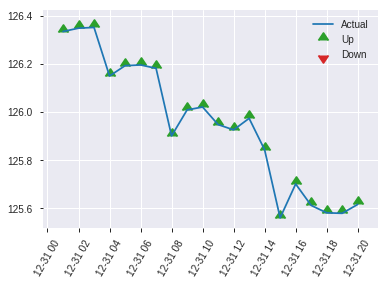


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2554636847697342
RMSE: 0.505434154732082
LogLoss: 0.7045226548914487
Mean Per-Class Error: 0.4774308474861274
AUC: 0.501460820581806
pr_auc: 0.5067404942245
Gini: 0.002921641163611932
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3449805676937103: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    304  1        (304.0/304.0)
1      0    313  0        (0.0/313.0)
Total  0    617  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.344981     0.673118  399
max f2                       0.344981     0.837346  399
max f0point5                 0.344981     0.562747  399
max accuracy                 0.540878     0.520259  147
max precision                0.588307     0.582278  66
max recall                   0.344981     1         399
max specificity              0.708761     0.996711  0
max absolute_mcc             0.385443     0.112954  391
max min_per_class_accuracy   0.517832     0.507987  202
max mean_per_class_accuracy  0.540878     0.522569  147

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 51.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.669037           0.563213  0.563213           0.285714         0.688191  0.285714                    0.688191            0.00638978      0.00638978                 -43.6787  -43.6787
    2        0.0210697                   0.662815           0         0.303269           0                0.664783  0.153846                    0.677387            0               0.00638978                 -100      -69.6731
    3        0.0307942                   0.637208           0.985623  0.518749           0.5              0.651491  0.263158                    0.669209            0.00958466      0.0159744                  -1.4377   -48.1251
    4        0.0405186                   0.631598           1.31416   0.709649           0.666667         0.635005  0.36                        0.661               0.0127796       0.028754                   31.4164   -29.0351
    5        0.0502431                   0.624326           1.31416   0.826652           0.666667         0.627875  0.419355                    0.654589            0.0127796       0.0415335                  31.4164   -17.3348
    6        0.100486                    0.600051           1.27177   1.04921            0.645161         0.611503  0.532258                    0.633046            0.0638978       0.105431                   27.1772   4.92116
    7        0.150729                    0.584633           1.14459   1.08101            0.580645         0.59061   0.548387                    0.618901            0.057508        0.162939                   14.4594   8.10059
    8        0.200972                    0.570124           1.01742   1.06511            0.516129         0.575677  0.540323                    0.608095            0.0511182       0.214058                   1.74173   6.51087
    9        0.299838                    0.547591           1.00178   1.04423            0.508197         0.559071  0.52973                     0.591931            0.0990415       0.313099                   0.178076  4.42276
    10       0.400324                    0.532895           0.922034  1.01356            0.467742         0.539236  0.51417                     0.578704            0.0926518       0.405751                   -7.79656  1.35556
    11       0.50081                     0.517386           1.08101   1.02709            0.548387         0.525056  0.521036                    0.567939            0.108626        0.514377                   8.10059   2.70893
    12       0.599676                    0.504397           0.93715   1.01226            0.47541          0.511155  0.513514                    0.558578            0.0926518       0.607029                   -6.28503  1.22615
    13       0.700162                    0.487889           0.985623  1.00844            0.5              0.49558   0.511574                    0.549536            0.0990415       0.70607                    -1.4377   0.843835
    14       0.799028                    0.471061           0.64631   0.963631           0.327869         0.479693  0.488844                    0.540894            0.0638978       0.769968                   -35.369   -3.63686
    15       0.899514                    0.443409           1.01742   0.96964            0.516129         0.458953  0.491892                    0.531741            0.102236        0.872204                   1.74173   -3.03601
    16       1                           0.344981           1.27177   1                  0.645161         0.41158   0.507293                    0.519666 

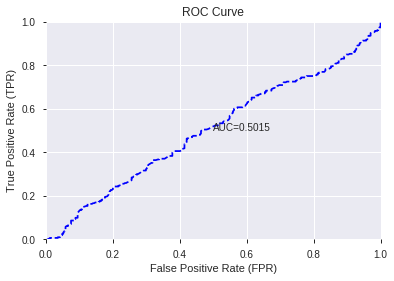

This function is available for GLM models only


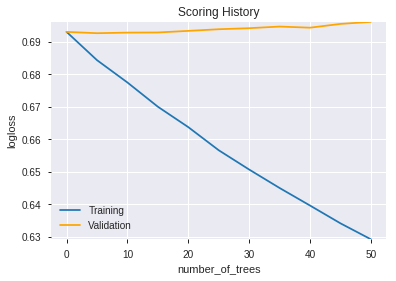

--2019-08-24 14:15:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_141515_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_141515_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_PHASOR_quadrature',
 'BOP',
 'COSH',
 'TRANGE',
 'TAN',
 'CORREL_30',
 'BETA_8',
 'CORREL_12',
 'OBV',
 'CORREL_8',
 'CORREL_14',
 'day',
 'hour',
 'STOCHRSI_fastk',
 'EXP',
 'days_in_month',
 'CDLDOJI',
 'HT_TRENDMODE',
 'CDLRICKSHAWMAN',
 'SINH',
 'CDL3INSIDE',
 'is_month_end',
 'CDLINVERTEDHAMMER',
 'CDLMATCHINGLOW',
 'CDLHANGINGMAN',
 'CDLDOJISTAR']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 892 924 935] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


1

['BOP']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_141642_model_1  0.549111  0.690929              0.500000  0.498890  0.248892
1  DeepLearning_grid_1_AutoML_20190824_141642_model_2  0.537587  0.692353              0.500000  0.499603  0.249603
2  DeepLearning_grid_1_AutoML_20190824_141642_model_5  0.535317  0.691944              0.500000  0.499398  0.249398
3  DeepLearning_grid_1_AutoML_20190824_141642_model_3  0.520446  0.692200              0.498355  0.499528  0.249528
4  DeepLearning_grid_1_AutoML_20190824_141642_model_4  0.520078  0.692820              0.498355  0.499835  0.249835
5               DeepLearning_1_AutoML_20190824_141642  0.518901  0.692407              0.496711  0.499631  0.249631
6  DeepLearning_grid_1_AutoML_20190824_141642_model_7  0.500000  0.696701              0.500000  0.501764  0.251767
7  DeepLearning_grid_1_AutoML_20190824_141642_model_6  0.457368  0.694647              0.496711  0.500749  0.250749

variable  relative_importance  scaled_importance  percentage
0      BOP                  1.0                1.0         1.0

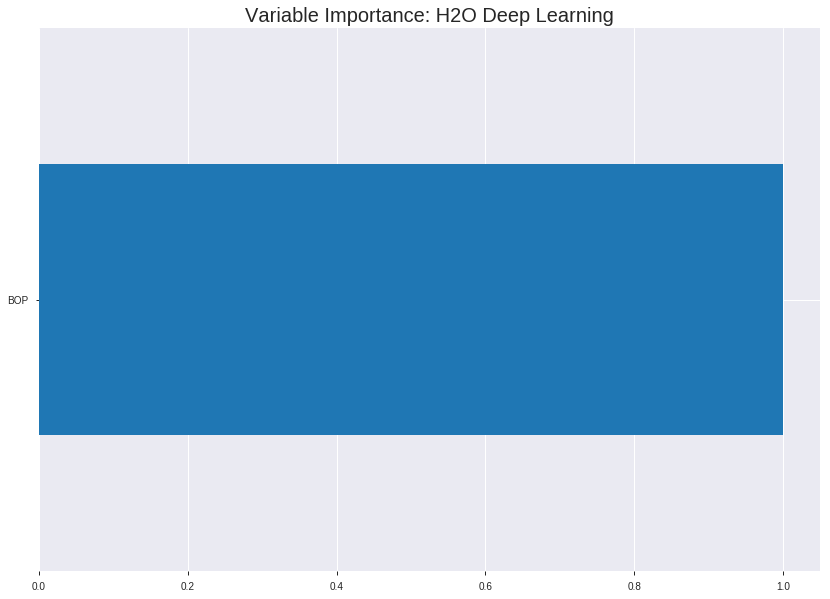

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_141642_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2496156192410092
RMSE: 0.4996154713787486
LogLoss: 0.6923777317783038
Mean Per-Class Error: 0.4733322675694718
AUC: 0.5272722740886805
pr_auc: 0.5389799939296356
Gini: 0.054544548177360985
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4709960734985683: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      0    2103  1        (2103.0/2103.0)
1      0    2213  0        (0.0/2213.0)
Total  0    4316  0.4873   (2103.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.470996     0.677899   399
max f2                       0.470996     0.840295   399
max f0point5                 0.471829     0.569804   392
max accuracy                 0.478873     0.531511   335
max precision                0.538596     1          0
max recall                   0.470996     1          399
max specificity              0.538596     1          0
max absolute_mcc             0.506515     0.0640204  145
max min_per_class_accuracy   0.491302     0.509715   244
max mean_per_class_accuracy  0.505807     0.526668   149

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 49.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101946                   0.534264           1.2411    1.2411             0.636364         0.535926  0.636364                    0.535926            0.0126525       0.0126525                  24.1096    24.1096
    2        0.0201576                   0.531858           1.17925   1.21053            0.604651         0.532922  0.62069                     0.534441            0.0117488       0.0244013                  17.9247    21.0527
    3        0.0301205                   0.529438           1.04318   1.15517            0.534884         0.530456  0.592308                    0.533123            0.0103931       0.0347944                  4.31804    15.5174
    4        0.0400834                   0.527932           1.17925   1.16116            0.604651         0.528686  0.595376                    0.53202             0.0117488       0.0465432                  17.9247    16.1158
    5        0.0500463                   0.526476           0.907113  1.11058            0.465116         0.527209  0.569444                    0.531062            0.00903751      0.0555807                  -9.28866   11.0584
    6        0.100093                    0.520057           1.05641   1.0835             0.541667         0.523472  0.555556                    0.527267            0.0528694       0.10845                    5.64091    8.34965
    7        0.150139                    0.513486           1.11058   1.09253            0.569444         0.516685  0.560185                    0.52374             0.0555807       0.164031                   11.0584    9.25256
    8        0.200185                    0.508885           1.13767   1.10381            0.583333         0.511101  0.565972                    0.52058             0.0569363       0.220967                   13.7671    10.3812
    9        0.300046                    0.500186           1.00456   1.07078            0.515081         0.503916  0.549035                    0.515034            0.100316        0.321283                   0.455964   7.0779
    10       0.400139                    0.495272           0.975147  1.04686            0.5              0.49765   0.536769                    0.510685            0.0976051       0.418888                   -2.48531   4.68571
    11       0.5                         0.491166           0.918584  1.02124            0.470998         0.49314   0.523633                    0.507181            0.0917307       0.510619                   -8.14162   2.12381
    12       0.600093                    0.487121           0.975147  1.01355            0.5              0.489044  0.519691                    0.504156            0.0976051       0.608224                   -2.48531   1.35503
    13       0.699954                    0.482903           0.99551   1.01098            0.510441         0.485047  0.518371                    0.50143             0.0994126       0.707637                   -0.449045  1.09765
    14       0.800046                    0.478558           1.14219   1.02739            0.585648         0.480765  0.526788                    0.498844            0.114324        0.821961                   14.2186    2.73919
    15       0.899907                    0.474488           0.900484  1.01331            0.461717         0.476541  0.519567                    0.496369            0.0899232       0.911884                   -9.95164   1.33091
    16       1                           0.470958           0.880341  1                  0.451389         0.472516  0.512743                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25057319251989796
RMSE: 0.5005728643463386
LogLoss: 0.6942946613309865
Mean Per-Class Error: 0.4780340782916651
AUC: 0.4973872958907137
pr_auc: 0.482583226530722
Gini: -0.005225408218572647
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4709838313311211: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    619   1        (619.0/619.0)
1      0    614   0        (0.0/614.0)
Total  0    1233  0.502    (619.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.470984     0.664862   399
max f2                       0.470984     0.832204   399
max f0point5                 0.47622      0.557716   355
max accuracy                 0.478464     0.520681   339
max precision                0.478464     0.51142    339
max recall                   0.470984     1          399
max specificity              0.537951     0.996769   0
max absolute_mcc             0.47622      0.0627251  355
max min_per_class_accuracy   0.490686     0.5        242
max mean_per_class_accuracy  0.478464     0.521966   339

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 49.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.533834           0.926835  0.926835           0.461538         0.535578  0.461538                    0.535578            0.00977199      0.00977199                 -7.31646  -7.31646
    2        0.0202758                   0.5314             0.836726  0.883583           0.416667         0.532569  0.44                        0.534134            0.00814332      0.0179153                  -16.3274  -11.6417
    3        0.0300081                   0.529071           0.502036  0.759838           0.25             0.530178  0.378378                    0.532851            0.00488599      0.0228013                  -49.7964  -24.0162
    4        0.0405515                   0.52759            0.772363  0.763094           0.384615         0.528511  0.38                        0.531722            0.00814332      0.0309446                  -22.7637  -23.6906
    5        0.0502839                   0.525832           1.33876   0.874514           0.666667         0.526466  0.435484                    0.530705            0.0130293       0.0439739                  33.8762   -12.5486
    6        0.100568                    0.517985           0.874514  0.874514           0.435484         0.522291  0.435484                    0.526498            0.0439739       0.0879479                  -12.5486  -12.5486
    7        0.150041                    0.512479           1.02053   0.92266            0.508197         0.515203  0.459459                    0.522774            0.0504886       0.138436                   2.05319   -7.73396
    8        0.200324                    0.507923           0.939293  0.926835           0.467742         0.510045  0.461538                    0.519579            0.0472313       0.185668                   -6.07072  -7.31646
    9        0.300081                    0.50107            1.04489   0.96608            0.520325         0.504224  0.481081                    0.514474            0.104235        0.289902                   4.48876   -3.39202
    10       0.399838                    0.495161           1.12652   1.00611            0.560976         0.49792   0.501014                    0.510344            0.112378        0.40228                    12.6519   0.610832
    11       0.500406                    0.490607           0.971682  0.99919            0.483871         0.492929  0.497569                    0.506844            0.0977199       0.5                        -2.83177  -0.0810373
    12       0.600162                    0.486603           0.881624  0.979648           0.439024         0.488583  0.487838                    0.503809            0.0879479       0.587948                   -11.8376  -2.03517
    13       0.699919                    0.482862           1.25713   1.0192             0.626016         0.484695  0.507532                    0.501085            0.125407        0.713355                   25.713    1.91967
    14       0.799676                    0.47911            1.07754   1.02647            0.536585         0.480935  0.511156                    0.498571            0.107492        0.820847                   7.75403   2.64749
    15       0.899432                    0.474421           0.914277  1.01403            0.455285         0.476827  0.504959                    0.496159            0.0912052       0.912052                   -8.57234  1.40309
    16       1                           0.470958           0.874514  1                  0.435484         0.472612  0.497972                    0.4


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:16:43  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 14:16:46  2.540 sec   17623 obs/sec     10        1             43160      0.500694         0.694559            -0.00342936    0.534412        0.542873           1.2411           0.487257                         0.50155            0.696279              -0.00622688      0.506519          0.487846             0.926835           0.498783
    2019-08-24 14:16:52  9.154 sec   19169 obs/sec     40        4             172640     0.499615         0.692378            0.000888535    0.527272        0.53898            1.2411           0.487257                         0.500573           0.694295              -0.00230925      0.497387          0.482583             0.926835           0.502028
    2019-08-24 14:16:58  14.732 sec  20791 obs/sec     70        7             302120     0.499953         0.693054            -0.000460823   0.506974        0.507794           1.01947          0.487257                         0.50074            0.694631              -0.00298026      0.479777          0.483033             0.926835           0.502028
    2019-08-24 14:17:04  20.906 sec  22994 obs/sec     110       11            474760     0.501049         0.695275            -0.00485154    0.504828        0.505037           1.01947          0.487257                         0.501835           0.696848              -0.00737124      0.484178          0.48711              0.926835           0.502028
    2019-08-24 14:17:10  26.750 sec  26125 obs/sec     160       16            690560     0.50683          0.707039            -0.0281755     0.485245        0.500102           1.15245          0.487257                         0.504703           0.702699              -0.0189176       0.511305          0.484893             0.772363           0.497161
    2019-08-24 14:17:16  32.477 sec  29575 obs/sec     220       22            949520     0.500719         0.694595            -0.00352909    0.481634        0.496002           1.01947          0.487257                         0.50075            0.694655              -0.00302044      0.527026          0.508219             0.926835           0.498783
    2019-08-24 14:17:16  32.537 sec  29571 obs/sec     220       22            949520     0.499615         0.692378            0.000888535    0.527272        0.53898            1.2411           0.487257                         0.500573           0.694295              -0.00230925      0.497387          0.482583             0.926835           0.502028

Variable Importances: 


variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
BOP         1                      1                    1

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5413290113452188)

('F1', 0.6731182795698925)

('auc', 0.5491108962502103)

('logloss', 0.6909291338947762)

('mean_per_class_error', 0.45537666050109304)

('rmse', 0.49889048141091935)

('mse', 0.24889171244241884)

deeplearning prediction progress: |███████████████████████████████████████| 100%


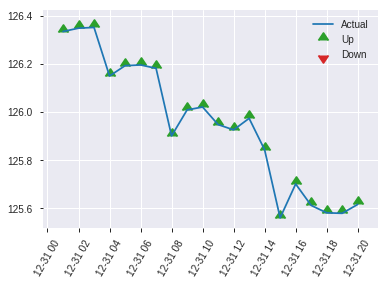


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24889171244241884
RMSE: 0.49889048141091935
LogLoss: 0.6909291338947762
Mean Per-Class Error: 0.45537666050109304
AUC: 0.5491108962502103
pr_auc: 0.5492835340774023
Gini: 0.09822179250042051
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4709718490251042: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    304  1        (304.0/304.0)
1      0    313  0        (0.0/313.0)
Total  0    617  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470972     0.673118  399
max f2                       0.470972     0.837346  399
max f0point5                 0.474355     0.571256  363
max accuracy                 0.494939     0.541329  188
max precision                0.516087     0.670886  66
max recall                   0.470972     1         399
max specificity              0.538723     0.993421  0
max absolute_mcc             0.516087     0.12539   66
max min_per_class_accuracy   0.491038     0.533546  221
max mean_per_class_accuracy  0.513091     0.544623  84

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 49.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.534466           0.84482   0.84482            0.428571         0.536721  0.428571                    0.536721            0.00958466      0.00958466                 -15.518   -15.518
    2        0.0210697                   0.531994           0.985623  0.909806           0.5              0.533192  0.461538                    0.535092            0.00958466      0.0191693                  -1.4377   -9.01942
    3        0.0307942                   0.529831           0.985623  0.933748           0.5              0.531013  0.473684                    0.533804            0.00958466      0.028754                   -1.4377   -6.62519
    4        0.0405186                   0.528012           1.31416   1.02505            0.666667         0.528937  0.52                        0.532636            0.0127796       0.0415335                  31.4164   2.50479
    5        0.0502431                   0.526373           1.64271   1.14459            0.833333         0.527072  0.580645                    0.531559            0.0159744       0.057508                   64.2705   14.4594
    6        0.100486                    0.519674           1.33536   1.23998            0.677419         0.523085  0.629032                    0.527322            0.0670927       0.124601                   33.536    23.9977
    7        0.150729                    0.514004           1.27177   1.25058            0.645161         0.516464  0.634409                    0.523703            0.0638978       0.188498                   27.1772   25.0575
    8        0.200972                    0.50724            0.826652  1.14459            0.419355         0.511015  0.580645                    0.520531            0.0415335       0.230032                   -17.3348  14.4594
    9        0.299838                    0.50061            1.09873   1.12947            0.557377         0.503624  0.572973                    0.514956            0.108626        0.338658                   9.87273   12.9471
    10       0.400324                    0.495666           0.953829  1.08538            0.483871         0.497966  0.550607                    0.510691            0.0958466       0.434505                   -4.61713  8.53824
    11       0.50081                     0.490728           0.985623  1.06537            0.5              0.493206  0.540453                    0.507183            0.0990415       0.533546                   -1.4377   6.5366
    12       0.599676                    0.486404           0.904834  1.0389             0.459016         0.488407  0.527027                    0.504088            0.0894569       0.623003                   -9.51658  3.88999
    13       0.700162                    0.482631           1.01742   1.03582            0.516129         0.484712  0.525463                    0.501307            0.102236        0.72524                    1.74173   3.58168
    14       0.799028                    0.478089           0.872519  1.01561            0.442623         0.480582  0.515213                    0.498742            0.086262        0.811502                   -12.7481  1.56115
    15       0.899514                    0.473596           1.04921   1.01937            0.532258         0.475641  0.517117                    0.496162            0.105431        0.916933                   4.92116   1.93651
    16       1                           0.470961           0.826652  1                  0.419355         0.472216  0.507293                    0.493756        

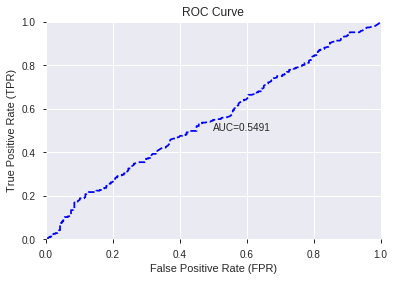

This function is available for GLM models only


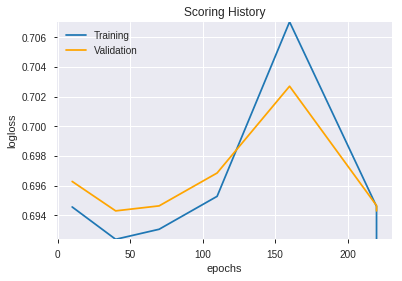

--2019-08-24 14:27:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_141642_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_141642_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_142828_model_1  0.520635  0.69279              0.498355  0.499822  0.249822

variable  relative_importance  scaled_importance  percentage
0      BOP             0.021315                1.0         1.0

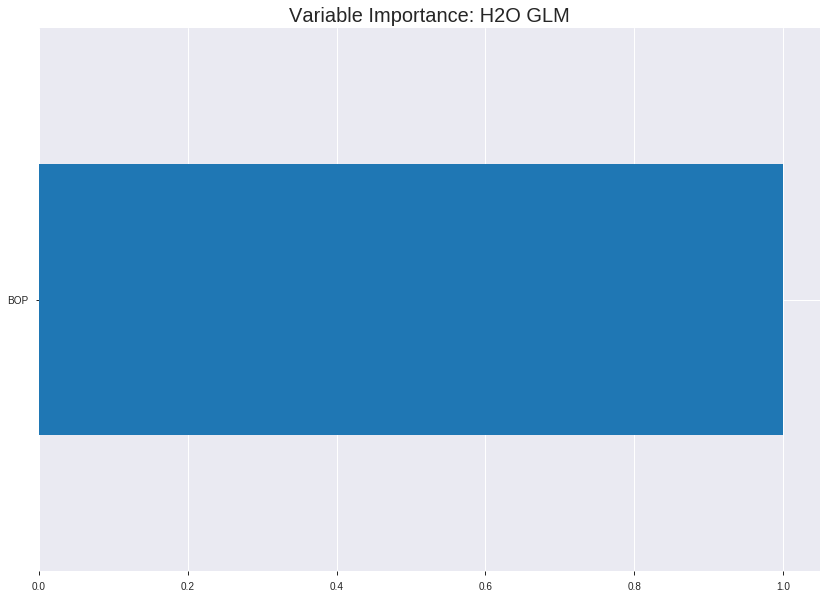

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_142828_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24954736457884122
RMSE: 0.49954715951433576
LogLoss: 0.6922414200659821
Null degrees of freedom: 4315
Residual degrees of freedom: 4314
Null deviance: 5980.442637223593
Residual deviance: 5975.427938009558
AIC: 5979.427938009558
AUC: 0.5344123547816162
pr_auc: 0.5428703071941675
Gini: 0.06882470956323239
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5023592920927604: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      0    2103  1        (2103.0/2103.0)
1      0    2213  0        (0.0/2213.0)
Total  0    4316  0.4873   (2103.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.502359     0.677899   399
max f2                       0.502359     0.840295   399
max f0point5                 0.505084     0.570163   359
max accuracy                 0.513226     0.531742   192
max precision                0.523243     1          0
max recall                   0.502359     1          399
max specificity              0.523243     1          0
max absolute_mcc             0.516022     0.0670199  136
max min_per_class_accuracy   0.512572     0.529244   205
max mean_per_class_accuracy  0.513226     0.53259    192

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.522512           1.2411    1.2411             0.636364         0.522793  0.636364                    0.522793            0.0126525       0.0126525                  24.1096   24.1096
    2        0.0201576                   0.522107           1.17925   1.21053            0.604651         0.522286  0.62069                     0.522542            0.0117488       0.0244013                  17.9247   21.0527
    3        0.0301205                   0.521699           1.04318   1.15517            0.534884         0.521871  0.592308                    0.52232             0.0103931       0.0347944                  4.31804   15.5174
    4        0.0400834                   0.521445           1.17925   1.16116            0.604651         0.521572  0.595376                    0.522134            0.0117488       0.0465432                  17.9247   16.1158
    5        0.0500463                   0.5212             0.907113  1.11058            0.465116         0.521324  0.569444                    0.521973            0.00903751      0.0555807                  -9.28866  11.0584
    6        0.100093                    0.52012            1.05641   1.0835             0.541667         0.520695  0.555556                    0.521334            0.0528694       0.10845                    5.64091   8.34965
    7        0.150139                    0.519016           1.11058   1.09253            0.569444         0.519554  0.560185                    0.52074             0.0555807       0.164031                   11.0584   9.25256
    8        0.200185                    0.518243           1.13767   1.10381            0.583333         0.518615  0.565972                    0.520209            0.0569363       0.220967                   13.7671   10.3812
    9        0.300046                    0.516408           1.06791   1.09186            0.547564         0.517288  0.559846                    0.519237            0.106643        0.32761                    6.79102   9.18633
    10       0.400139                    0.514566           0.970632  1.06154            0.497685         0.515485  0.544296                    0.518298            0.0971532       0.424763                   -2.93677  6.1538
    11       0.5                         0.512578           1.04981   1.0592             0.538283         0.513547  0.543095                    0.517349            0.104835        0.529598                   4.98101   5.91957
    12       0.600093                    0.510719           0.884855  1.03012            0.453704         0.511657  0.528185                    0.5164              0.0885676       0.618165                   -11.5145  3.01165
    13       0.699954                    0.50898            0.932159  1.01614            0.477958         0.509869  0.52102                     0.515468            0.0930863       0.711252                   -6.78411  1.61411
    14       0.800046                    0.507301           1.05189   1.02061            0.539352         0.508132  0.523313                    0.51455             0.105287        0.816539                   5.18945   2.06142
    15       0.899907                    0.505669           0.963834  1.01431            0.4942           0.506485  0.520082                    0.513655            0.0962494       0.912788                   -3.61657  1.43134
    16       1                           0.502353           0.871312  1                  0.446759         0.504541  0.512743                    0.512743          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2501868658225232
RMSE: 0.5001868309167318
LogLoss: 0.693521243880946
Null degrees of freedom: 1232
Residual degrees of freedom: 1231
Null deviance: 1710.357041745574
Residual deviance: 1710.2233874104127
AIC: 1714.2233874104127
AUC: 0.5065120268584931
pr_auc: 0.4878468869462788
Gini: 0.013024053716986117
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5029318185757753: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    614   0.9919   (614.0/619.0)
1      1    613   0.0016   (1.0/614.0)
Total  6    1227  0.4988   (615.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.502932     0.665942   393
max f2                       0.502665     0.832655   397
max f0point5                 0.502932     0.555053   393
max accuracy                 0.5131       0.531225   193
max precision                0.5131       0.5299     193
max recall                   0.502665     1          397
max specificity              0.523134     0.996769   0
max absolute_mcc             0.5131       0.0623717  193
max min_per_class_accuracy   0.512791     0.527687   198
max mean_per_class_accuracy  0.5131       0.531177   193

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 51.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.52244            0.926835  0.926835           0.461538         0.522734  0.461538                    0.522734            0.00977199      0.00977199                 -7.31646  -7.31646
    2        0.0202758                   0.52203            0.836726  0.883583           0.416667         0.522227  0.44                        0.52249             0.00814332      0.0179153                  -16.3274  -11.6417
    3        0.0300081                   0.521637           0.502036  0.759838           0.25             0.521824  0.378378                    0.522274            0.00488599      0.0228013                  -49.7964  -24.0162
    4        0.0405515                   0.521388           0.772363  0.763094           0.384615         0.521543  0.38                        0.522084            0.00814332      0.0309446                  -22.7637  -23.6906
    5        0.0502839                   0.521092           1.33876   0.874514           0.666667         0.521199  0.435484                    0.521913            0.0130293       0.0439739                  33.8762   -12.5486
    6        0.100568                    0.519772           0.874514  0.874514           0.435484         0.520496  0.435484                    0.521204            0.0439739       0.0879479                  -12.5486  -12.5486
    7        0.150041                    0.518847           1.02053   0.92266            0.508197         0.519305  0.459459                    0.520578            0.0504886       0.138436                   2.05319   -7.73396
    8        0.200324                    0.518081           0.939293  0.926835           0.467742         0.518438  0.461538                    0.520041            0.0472313       0.185668                   -6.07072  -7.31646
    9        0.300081                    0.516448           1.06121   0.971507           0.528455         0.517342  0.483784                    0.519144            0.105863        0.291531                   6.1214    -2.84928
    10       0.399838                    0.514624           1.1755    1.0224             0.585366         0.515514  0.509128                    0.518238            0.117264        0.408795                   17.5499   2.24016
    11       0.500406                    0.512724           1.19841   1.05777            0.596774         0.513778  0.526742                    0.517342            0.120521        0.529316                   19.8408   5.7774
    12       0.600162                    0.510754           0.881624  1.0285             0.439024         0.511697  0.512162                    0.516403            0.0879479       0.617264                   -11.8376  2.8495
    13       0.699919                    0.509117           0.914277  1.01222            0.455285         0.509944  0.504056                    0.515483            0.0912052       0.708469                   -8.57234  1.22159
    14       0.799676                    0.507651           1.07754   1.02036            0.536585         0.508399  0.508114                    0.514599            0.107492        0.815961                   7.75403   2.03649
    15       0.899432                    0.505752           0.816318  0.997734           0.406504         0.506686  0.496844                    0.513721            0.0814332       0.897394                   -18.3682  -0.226603
    16       1                           0.502305           1.02027   1                  0.508065         0.504522  0.497972                    0.512796


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 14:28:29  0.000 sec   2            3         2             1.38511           1.38708
    2019-08-24 14:28:29  0.003 sec   3            1.9       2             1.38485           1.38705
    2019-08-24 14:28:29  0.006 sec   4            1.2       2             1.38448           1.38704
    2019-08-24 14:28:29  0.008 sec   5            0.72      2             1.38403           1.38707
    2019-08-24 14:28:29  0.010 sec   6            0.44      2             1.38353           1.38716
    2019-08-24 14:28:29  0.013 sec   7            0.28      2             1.38305           1.38735
    2019-08-24 14:28:29  0.015 sec   8            0.17      2             1.38265           1.38765
    2019-08-24 14:28:29  0.018 sec   9            0.11      2             1.38238           1.388

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.539708265802269)

('F1', 0.673842841765339)

('auc', 0.5206354044055826)

('logloss', 0.6927902197002895)

('mean_per_class_error', 0.45537666050109304)

('rmse', 0.49982169354202355)

('mse', 0.24982172533521652)

glm prediction progress: |████████████████████████████████████████████████| 100%


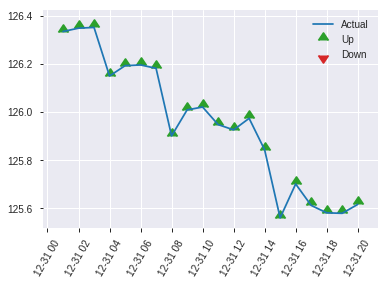


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24982172533521652
RMSE: 0.49982169354202355
LogLoss: 0.6927902197002895
Null degrees of freedom: 616
Residual degrees of freedom: 615
Null deviance: 855.2856750512815
Residual deviance: 854.9031311101573
AIC: 858.9031311101573
AUC: 0.5206354044055826
pr_auc: 0.5374233280926081
Gini: 0.041270808811165294
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5027824236177081: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    303  0.9967   (303.0/304.0)
1      0    313  0        (0.0/313.0)
Total  1    616  0.4911   (303.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.502782     0.673843  398
max f2                       0.502782     0.837794  398
max f0point5                 0.502782     0.563558  398
max accuracy                 0.518954     0.539708  70
max precision                0.519448     0.6625    58
max recall                   0.502782     1         398
max specificity              0.523265     0.993421  0
max absolute_mcc             0.519238     0.122553  64
max min_per_class_accuracy   0.512791     0.507987  201
max mean_per_class_accuracy  0.518954     0.544623  70

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.522546           0.84482   0.84482            0.428571         0.522927  0.428571                    0.522927            0.00958466      0.00958466                 -15.518   -15.518
    2        0.0210697                   0.52213            0.985623  0.909806           0.5              0.522332  0.461538                    0.522652            0.00958466      0.0191693                  -1.4377   -9.01942
    3        0.0307942                   0.521765           0.985623  0.933748           0.5              0.521964  0.473684                    0.522435            0.00958466      0.028754                   -1.4377   -6.62519
    4        0.0405186                   0.521459           1.31416   1.02505            0.666667         0.521615  0.52                        0.522238            0.0127796       0.0415335                  31.4164   2.50479
    5        0.0502431                   0.521183           1.64271   1.14459            0.833333         0.521301  0.580645                    0.522057            0.0159744       0.057508                   64.2705   14.4594
    6        0.100486                    0.520056           1.33536   1.23998            0.677419         0.52063   0.629032                    0.521343            0.0670927       0.124601                   33.536    23.9977
    7        0.150729                    0.519103           1.27177   1.25058            0.645161         0.519516  0.634409                    0.520734            0.0638978       0.188498                   27.1772   25.0575
    8        0.200972                    0.517966           0.826652  1.14459            0.419355         0.518601  0.580645                    0.520201            0.0415335       0.230032                   -17.3348  14.4594
    9        0.299838                    0.516622           1.00178   1.0975             0.508197         0.517294  0.556757                    0.519242            0.0990415       0.329073                   0.178076  9.75045
    10       0.400324                    0.514558           0.953829  1.06144            0.483871         0.515545  0.538462                    0.518314            0.0958466       0.42492                    -4.61713  6.14402
    11       0.50081                     0.512694           0.826652  1.01433            0.419355         0.513696  0.514563                    0.517388            0.0830671       0.507987                   -17.3348  1.43305
    12       0.599676                    0.511243           0.840203  0.985623           0.42623          0.512041  0.5                         0.516506            0.0830671       0.591054                   -15.9797  -1.4377
    13       0.700162                    0.509296           1.08101   0.999312           0.548387         0.510386  0.506944                    0.515628            0.108626        0.699681                   8.10059   -0.0687788
    14       0.799028                    0.507552           0.969465  0.995619           0.491803         0.508372  0.505071                    0.51473             0.0958466       0.795527                   -3.05348  -0.438082
    15       0.899514                    0.505771           0.985623  0.994502           0.5              0.506646  0.504505                    0.513827            0.0990415       0.894569                   -1.4377   -0.549751
    16       1                           0.502668           1.04921   1                  0.532258         0.504636  0.507293                    0.512904

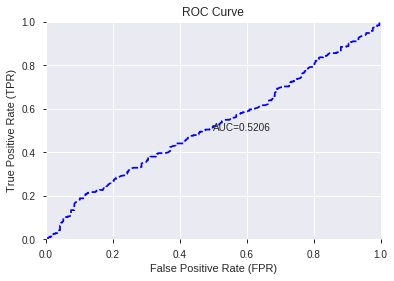

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


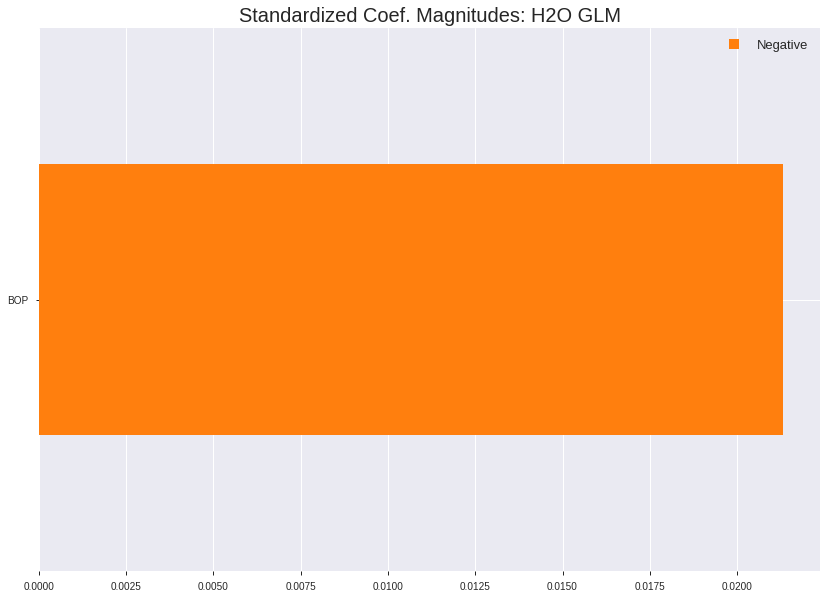

'log_likelihood'
--2019-08-24 14:28:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_142828_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_142828_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP']

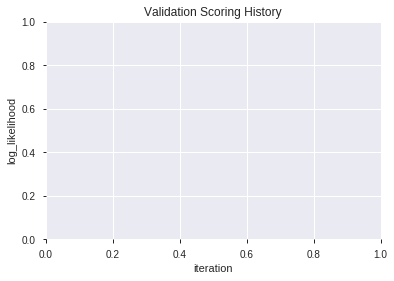

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190824_142935  0.549347  0.694721              0.500000  0.500579  0.250579
1  XGBoost_grid_1_AutoML_20190824_142935_model_7  0.548811  0.695409              0.500000  0.500894  0.250895
2  XGBoost_grid_1_AutoML_20190824_142935_model_1  0.543982  0.692861              0.500000  0.499774  0.249774
3               XGBoost_3_AutoML_20190824_142935  0.539447  0.693330              0.496663  0.500017  0.250017
4  XGBoost_grid_1_AutoML_20190824_142935_model_5  0.538060  0.702643              0.471708  0.504113  0.254129
5  XGBoost_grid_1_AutoML_20190824_142935_model_6  0.535696  0.692464              0.495066  0.499621  0.249621
6  XGBoost_grid_1_AutoML_20190824_142935_model_3  0.533410  0.694739              0.496663  0.500716  0.250717
7  XGBoost_grid_1_AutoML_20190824_142935_model_2  0.532375  0.692599              0.500000  0.499705  0.249705
8               XGBoost_2_AutoML_20190824_142935  0.520546  0.700526              0.490037  0.503484  0.253497
9  XGBoost_grid_1_AutoML_20190824_142935_model_4  0.520268  0.694872              0.500000  0.500829  0.250830

variable  relative_importance  scaled_importance  percentage
0      BOP          3271.769287                1.0         1.0

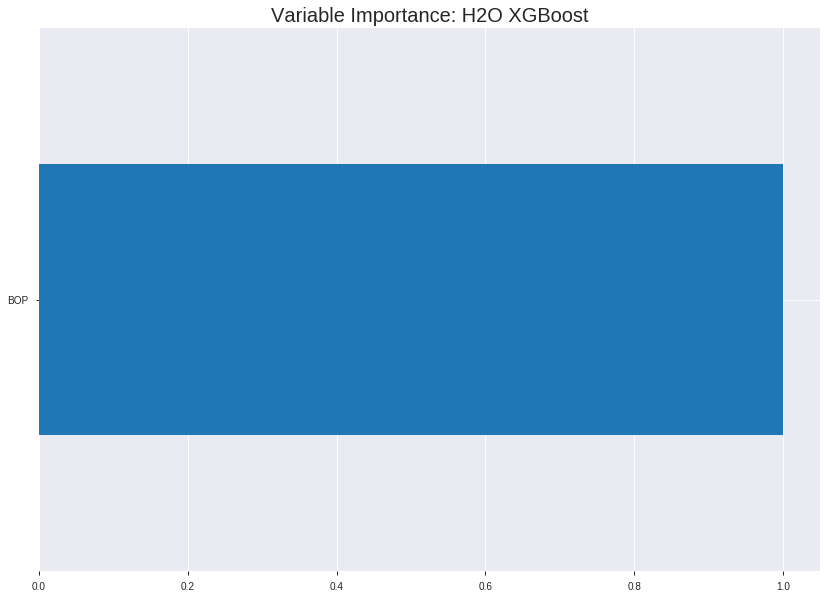

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190824_142935


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.23779448984816423
RMSE: 0.4876417638473598
LogLoss: 0.6683080402857207
Mean Per-Class Error: 0.40254900203891797
AUC: 0.6313198346604887
pr_auc: 0.6249412577520371
Gini: 0.2626396693209774
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40135863423347473: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      238  1865  0.8868   (1865.0/2103.0)
1      102  2111  0.0461   (102.0/2213.0)
Total  340  3976  0.4557   (1967.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.401359     0.682178  231
max f2                       0.319618     0.840295  251
max f0point5                 0.504363     0.608744  134
max accuracy                 0.504363     0.598007  134
max precision                0.708238     0.823529  0
max recall                   0.319618     1         251
max specificity              0.708238     0.998573  0
max absolute_mcc             0.51301      0.194895  120
max min_per_class_accuracy   0.51047      0.59534   124
max mean_per_class_accuracy  0.51301      0.597451  120

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0115848                   0.693018           1.48222   1.48222            0.76             0.701632  0.76                        0.701632            0.0171713       0.0171713                  48.2223   48.2223
    2        0.0234013                   0.672214           1.45316   1.46755            0.745098         0.677278  0.752475                    0.689335            0.0171713       0.0343425                  45.316    46.7548
    3        0.031279                    0.664519           1.37668   1.44466            0.705882         0.664773  0.740741                    0.683149            0.010845        0.0451875                  37.6678   44.4662
    4        0.0430955                   0.652963           1.45316   1.44699            0.745098         0.656223  0.741935                    0.675766            0.0171713       0.0623588                  45.316    44.6992
    5        0.0512048                   0.643698           1.50451   1.4561             0.771429         0.647542  0.746606                    0.671296            0.0122006       0.0745594                  50.4512   45.6102
    6        0.102178                    0.626444           1.25883   1.35769            0.645455         0.634741  0.696145                    0.65306             0.0641663       0.138726                   25.8826   35.7687
    7        0.152688                    0.604722           1.34195   1.35248            0.688073         0.612154  0.693475                    0.639528            0.0677813       0.206507                   34.1945   35.248
    8        0.200417                    0.588727           1.1929    1.31448            0.61165          0.595587  0.673988                    0.629064            0.0569363       0.263443                   19.2898   31.4475
    9        0.302132                    0.55227            1.15951   1.26231            0.594533         0.569043  0.647239                    0.608857            0.117939        0.381383                   15.9514   26.2307
    10       0.403614                    0.528722           1.11318   1.22481            0.570776         0.538288  0.628014                    0.591114            0.112969        0.494352                   11.3181   22.4811
    11       0.503707                    0.51047            1.03384   1.18686            0.530093         0.519442  0.608556                    0.576872            0.103479        0.597831                   3.38363   18.6862
    12       0.600324                    0.489187           0.926039  1.14488            0.47482          0.499851  0.587032                    0.564476            0.0894713       0.687302                   -7.39613  14.4885
    13       0.703661                    0.468735           0.900808  1.10904            0.461883         0.479576  0.568653                    0.552008            0.0930863       0.780389                   -9.91917  10.9041
    14       0.803522                    0.444266           0.837133  1.07525            0.429234         0.457014  0.551326                    0.540202            0.0835969       0.863986                   -16.2867  7.52484
    15       0.901993                    0.406397           0.761762  1.04103            0.390588         0.423957  0.533779                    0.527511            0.0750113       0.938997                   -23.8238  4.1025
    16       1                           0.319618           0.622434  1                  0.319149         0.369449  0.512743                    0.51202            



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25672947466464313
RMSE: 0.5066847882704227
LogLoss: 0.7070504512310996
Mean Per-Class Error: 0.4854656822762362
AUC: 0.49893834228791845
pr_auc: 0.5018758605234981
Gini: -0.002123315424163108
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31961822509765625: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    619   1        (619.0/619.0)
1      0    614   0        (0.0/614.0)
Total  0    1233  0.502    (619.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.319618     0.664862   248
max f2                       0.319618     0.832204   248
max f0point5                 0.37216      0.557743   237
max accuracy                 0.594193     0.515815   43
max precision                0.703767     0.636364   1
max recall                   0.319618     1          248
max specificity              0.708238     0.996769   0
max absolute_mcc             0.37216      0.0591219  237
max min_per_class_accuracy   0.517539     0.490228   114
max mean_per_class_accuracy  0.594193     0.514534   43

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 51.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113544                   0.693018           1.14751   1.14751            0.571429         0.702422  0.571429                    0.702422            0.0130293       0.0130293                  14.751    14.751
    2        0.0243309                   0.678297           0.878563  1.00407            0.4375           0.679999  0.5                         0.690463            0.0114007       0.02443                    -12.1437  0.407166
    3        0.0348743                   0.665027           1.23578   1.07412            0.615385         0.668344  0.534884                    0.683776            0.0130293       0.0374593                  23.5781   7.41232
    4        0.0421736                   0.65868            0.892508  1.04269            0.444444         0.661275  0.519231                    0.679881            0.00651466      0.0439739                  -10.7492  4.26898
    5        0.052717                    0.643698           1.08131   1.05041            0.538462         0.649124  0.523077                    0.67373             0.0114007       0.0553746                  8.13079   5.04134
    6        0.101379                    0.628416           1.00407   1.02817            0.5              0.635512  0.512                       0.655385            0.0488599       0.104235                   0.407166  2.81694
    7        0.152474                    0.602904           1.17939   1.07884            0.587302         0.611988  0.537234                    0.640843            0.0602606       0.164495                   17.9386   7.8843
    8        0.203569                    0.591093           0.956259  1.04807            0.47619          0.595433  0.521912                    0.629445            0.0488599       0.213355                   -4.37413  4.80748
    9        0.300081                    0.558273           0.945009  1.01493            0.470588         0.571861  0.505405                    0.610925            0.0912052       0.30456                    -5.49914  1.49265
    10       0.400649                    0.533761           0.955488  1.00001            0.475806         0.542447  0.497976                    0.593736            0.0960912       0.400651                   -4.45125  0.000659378
    11       0.50365                     0.517277           0.917105  0.983052           0.456693         0.524606  0.489533                    0.579598            0.0944625       0.495114                   -8.28952  -1.69476
    12       0.602595                    0.494538           1.08637   1.00002            0.540984         0.507109  0.497981                    0.567696            0.107492        0.602606                   8.63726   0.00175361
    13       0.70073                     0.473254           0.912792  0.987802           0.454545         0.484145  0.491898                    0.555995            0.0895765       0.692182                   -8.72076  -1.2198
    14       0.799676                    0.444641           0.987611  0.987778           0.491803         0.457747  0.491886                    0.543838            0.0977199       0.789902                   -1.23885  -1.22216
    15       0.903487                    0.402745           1.12958   1.00407            0.5625           0.425752  0.5                         0.53027             0.117264        0.907166                   12.9581   0.407166
    16       1                           0.319618           0.961884  1                  0.478992         0.370448  0.497972                    0.514845


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:29:36  0.007 sec   0                  0.5              0.693147            0.5             0                  1                0.487257                         0.5                0.693147              0.5               0                    1                  0.502028
    2019-08-24 14:29:36  0.098 sec   5                  0.496334         0.685831            0.616166        0.605643           1.32473          0.464319                         0.500722           0.694596              0.495634          0.494595             0.826883           0.502028
    2019-08-24 14:29:36  0.175 sec   10                 0.494093         0.681362            0.620104        0.612607           1.37668          0.465014                         0.501251           0.695664              0.496128          0.500894             1.07101            0.502028
    2019-08-24 14:29:36  0.267 sec   15                 0.492222         0.677616            0.622628        0.612294           1.48222          0.465014                         0.502232           0.697658              0.496608          0.502127             1.14751            0.500406
    2019-08-24 14:29:36  0.354 sec   20                 0.491003         0.675166            0.623949        0.613955           1.48222          0.463855                         0.50283            0.698887              0.499463          0.501754             1.14751            0.500406
    2019-08-24 14:29:36  0.435 sec   25                 0.4901           0.673336            0.625144        0.614534           1.48222          0.458526                         0.503442           0.700171              0.50285           0.50353              1.14751            0.500406
    2019-08-24 14:29:36  0.525 sec   30                 0.489375         0.671857            0.626521        0.620636           1.52964          0.455514                         0.504395           0.702157              0.499933          0.503154             0.845534           0.502028
    2019-08-24 14:29:36  0.608 sec   35                 0.488837         0.670756            0.627354        0.621324           1.56023          0.456905                         0.505416           0.704303              0.498407          0.502471             1.2272             0.502028
    2019-08-24 14:29:36  0.700 sec   40                 0.488348         0.669749            0.629107        0.622841           1.56023          0.458526                         0.505831           0.705232              0.499872          0.50175              1.2272             0.502028
    2019-08-24 14:29:36  0.788 sec   45                 0.487998         0.669039            0.630192        0.623979           1.48222          0.463855                         0.506161           0.70593               0.499136          0.501491             1.14751            0.502028
    2019-08-24 14:29:37  0.884 sec   50                 0.487642         0.668308            0.63132         0.624941           1.48222          0.455746                         0.506685           0.70705               0.498938          0.501876             1.14751            0.502028

Variable Importances: 


variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
BOP         3271.77                1                    1

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5656401944894651)

('F1', 0.6731182795698925)

('auc', 0.5493473600134522)

('logloss', 0.6947208955704552)

('mean_per_class_error', 0.437006053472339)

('rmse', 0.5005787107662776)

('mse', 0.25057904567242856)

xgboost prediction progress: |████████████████████████████████████████████| 100%


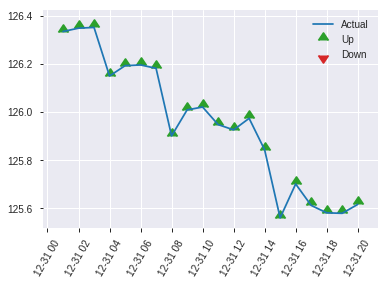


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25057904567242856
RMSE: 0.5005787107662776
LogLoss: 0.6947208955704552
Mean Per-Class Error: 0.437006053472339
AUC: 0.5493473600134522
pr_auc: 0.5210456812278591
Gini: 0.09869472002690438
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31961822509765625: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    304  1        (304.0/304.0)
1      0    313  0        (0.0/313.0)
Total  0    617  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.319618     0.673118  230
max f2                       0.319618     0.837346  230
max f0point5                 0.46368      0.585132  164
max accuracy                 0.475569     0.56564   153
max precision                0.533761     0.561404  84
max recall                   0.319618     1         230
max specificity              0.708238     0.993421  0
max absolute_mcc             0.46368      0.138823  164
max min_per_class_accuracy   0.508709     0.536741  113
max mean_per_class_accuracy  0.475569     0.562994  153

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 51.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.677324           0.563213  0.563213           0.285714         0.691787  0.285714                    0.691787            0.00638978      0.00638978                 -43.6787  -43.6787
    2        0.0243112                   0.665027           0.492812  0.525666           0.25             0.668621  0.266667                    0.679432            0.00638978      0.0127796                  -50.7188  -47.4334
    3        0.0324149                   0.65868            1.18275   0.689936           0.6              0.662184  0.35                        0.67512             0.00958466      0.0223642                  18.2748   -31.0064
    4        0.0453809                   0.651173           1.23203   0.84482            0.625            0.653083  0.428571                    0.668823            0.0159744       0.0383387                  23.2029   -15.518
    5        0.0567261                   0.640791           1.12643   0.901141           0.571429         0.641588  0.457143                    0.663376            0.0127796       0.0511182                  12.6426   -9.8859
    6        0.100486                    0.616185           1.09514   0.985623           0.555556         0.631142  0.5                         0.649339            0.0479233       0.0990415                  9.51367   -1.4377
    7        0.15235                     0.605685           0.924022  0.964652           0.46875          0.611119  0.489362                    0.636328            0.0479233       0.146965                   -7.59784  -3.53477
    8        0.202593                    0.592711           1.08101   0.993508           0.548387         0.597982  0.504                       0.626818            0.0543131       0.201278                   8.10059   -0.649201
    9        0.299838                    0.55879            1.2156    1.06554            0.616667         0.572678  0.540541                    0.609259            0.118211        0.319489                   21.5602   6.55384
    10       0.401945                    0.523144           1.18901   1.0969             0.603175         0.538645  0.556452                    0.591321            0.121406        0.440895                   18.9006   9.6903
    11       0.504052                    0.508514           1.00127   1.07753            0.507937         0.515831  0.546624                    0.576029            0.102236        0.543131                   0.126781  7.753
    12       0.602917                    0.488988           1.06641   1.07571            0.540984         0.496495  0.545699                    0.562987            0.105431        0.648562                   6.64118   7.57068
    13       0.700162                    0.468565           1.11704   1.08145            0.566667         0.48002   0.548611                    0.551464            0.108626        0.757188                   11.7039   8.14475
    14       0.80389                     0.442638           0.770018  1.04126            0.390625         0.45471   0.528226                    0.53898             0.0798722       0.837061                   -22.9982  4.1263
    15       0.899514                    0.402608           0.835274  1.01937            0.423729         0.419899  0.517117                    0.526321            0.0798722       0.916933                   -16.4726  1.93651
    16       1                           0.319618           0.826652  1                  0.419355         0.367131  0.507293                    0.510324       

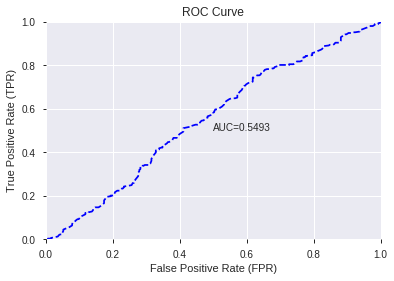

This function is available for GLM models only


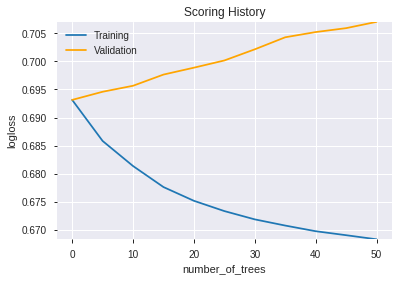

--2019-08-24 14:29:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190824_142935',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190824_142935',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_805c',
   'type

['BOP']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

242

['BBANDS_upperband_8_2_5',
 'BBANDS_middleband_8_2_5',
 'BBANDS_lowerband_8_2_5',
 'MA_8_3',
 'T3_8_3',
 'BBANDS_upperband_8_3_2',
 'BBANDS_lowerband_8_3_4',
 'BBANDS_upperband_8_3_5',
 'BBANDS_lowerband_8_3_5',
 'T3_8_4',
 'BBANDS_lowerband_8_4_2',
 'BBANDS_upperband_8_4_3',
 'BBANDS_lowerband_8_4_3',
 'T3_8_5',
 'BBANDS_upperband_8_5_5',
 'BBANDS_upperband_8_6_5',
 'BBANDS_upperband_8_7_2',
 'BBANDS_upperband_8_7_5',
 'BBANDS_lowerband_8_7_5',
 'BBANDS_upperband_8_8_4',
 'BBANDS_upperband_8_8_5',
 'SAR_0.12',
 'MAVP_12_0',
 'BBANDS_upperband_12_0_4',
 'BBANDS_upperband_12_0_5',
 'BBANDS_upperband_12_1_5',
 'BBANDS_lowerband_12_2_5',
 'MA_12_4',
 'BBANDS_upperband_12_4_4',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_upperband_12_5_3',
 'BBANDS_lowerband_12_6_4',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_lowerband_12_7_4',
 'BBANDS_lowerband_12_7_5',
 'SAR_0.14',
 'MA_14_0',
 'BBANDS_upperband_14_1_2',
 'BBANDS_lowerband_14_1_5',
 'MAVP_14_2',
 'BBANDS_lowerband_14_2_3',
 'BBANDS_upperband_14_2_4'

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_143533_model_6  0.540167  0.691293              0.471567  0.499073  0.249074
1  DeepLearning_grid_1_AutoML_20190824_143533_model_5  0.535512  0.692661              0.493421  0.499757  0.249757
2  DeepLearning_grid_1_AutoML_20190824_143533_model_9  0.527551  0.693942              0.496663  0.500396  0.250396
3               DeepLearning_1_AutoML_20190824_143533  0.525911  0.700926              0.491634  0.502851  0.252860
4  DeepLearning_grid_1_AutoML_20190824_143533_model_7  0.519085  0.704275              0.500000  0.505417  0.255446
5  DeepLearning_grid_1_AutoML_20190824_143533_model_2  0.517798  0.898478              0.500000  0.556701  0.309915
6  DeepLearning_grid_1_AutoML_20190824_143533_model_4  0.514881  0.806687              0.488250  0.540325  0.291951
7  DeepLearning_grid_1_AutoML_20190824_143533_model_8  0.500000  0.694007              0.500000  0.500430  0.250430
8  DeepLearning_grid_1_AutoML_20190824_143533_model_1  0.496705  1.201826              0.495018  0.609426  0.371400
9  DeepLearning_grid_1_AutoML_20190824_143533_model_3  0.492591  0.734648              0.493374  0.518875  0.269232

variable  relative_importance  scaled_importance  percentage
0               HT_TRENDMODE             1.000000           1.000000    0.004900
1                     ADX_14             0.962044           0.962044    0.004714
2                AROONOSC_24             0.955459           0.955459    0.004682
3                        OBV             0.942487           0.942487    0.004618
4                    ADXR_14             0.937358           0.937358    0.004593
..                       ...                  ...                ...         ...
237  BBANDS_lowerband_14_2_3             0.769780           0.769780    0.003772
238              CDLBELTHOLD             0.767778           0.767778    0.003762
239               ROCR100_12             0.761453           0.761453    0.003731
240                CDLHARAMI             0.726724           0.726724    0.003561
241             CDLENGULFING             0.715174           0.715174    0.003504

[242 rows x 4 columns]

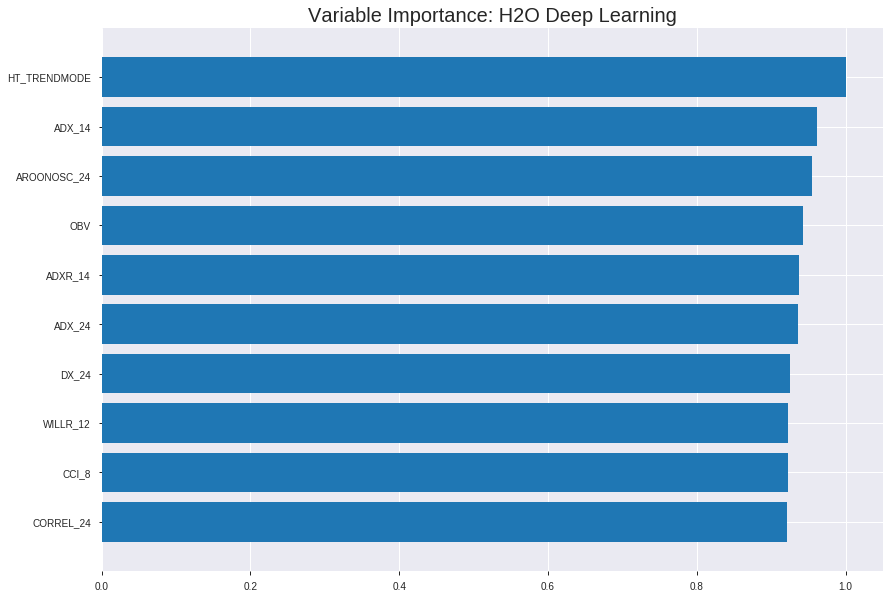

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_143533_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24733159492639525
RMSE: 0.49732443628520334
LogLoss: 0.687760526336697
Mean Per-Class Error: 0.46447890700759076
AUC: 0.5503551937401844
pr_auc: 0.5587765929536955
Gini: 0.10071038748036876
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3878646793349265: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      36   2067  0.9829   (2067.0/2103.0)
1      13   2200  0.0059   (13.0/2213.0)
Total  49   4267  0.4819   (2080.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.387865     0.679012   372
max f2                       0.317009     0.84055    395
max f0point5                 0.466386     0.577819   289
max accuracy                 0.47701      0.540547   267
max precision                0.628231     0.727273   5
max recall                   0.317009     1          395
max specificity              0.637533     0.999049   0
max absolute_mcc             0.466386     0.0912578  289
max min_per_class_accuracy   0.506522     0.526435   193
max mean_per_class_accuracy  0.515426     0.535521   167

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 50.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.608481           1.15245   1.15245            0.590909         0.619762  0.590909                    0.619762            0.0117488       0.0117488                  15.2446   15.2446
    2        0.0201576                   0.598951           1.45138   1.3002             0.744186         0.603244  0.666667                    0.611598            0.01446         0.0262088                  45.1381   30.0196
    3        0.0301205                   0.592608           1.2246    1.27519            0.627907         0.595701  0.653846                    0.60634             0.0122006       0.0384094                  22.4603   27.5192
    4        0.0400834                   0.586651           1.17925   1.25134            0.604651         0.589377  0.641618                    0.602123            0.0117488       0.0501582                  17.9247   25.1345
    5        0.0500463                   0.583006           1.31531   1.26408            0.674419         0.584723  0.648148                    0.598659            0.0131044       0.0632625                  31.5314   26.4079
    6        0.100093                    0.559647           1.15573   1.2099             0.592593         0.571595  0.62037                     0.585127            0.05784         0.121103                   15.573    20.9904
    7        0.150139                    0.543303           1.07447   1.16476            0.550926         0.550839  0.597222                    0.573698            0.0537732       0.174876                   7.44674   16.4759
    8        0.200185                    0.530926           1.10155   1.14896            0.564815         0.536503  0.58912                     0.564399            0.0551288       0.230005                   10.1555   14.8958
    9        0.300046                    0.519281           1.02266   1.10692            0.524362         0.523987  0.567568                    0.550949            0.102124        0.332128                   2.26598   10.6923
    10       0.400139                    0.511799           0.988691  1.07735            0.506944         0.515452  0.552403                    0.54207             0.0989607       0.431089                   -1.13094  7.73481
    11       0.5                         0.506415           0.954784  1.05287            0.489559         0.508896  0.539852                    0.535444            0.0953457       0.526435                   -4.52158  5.28694
    12       0.600093                    0.499934           0.975147  1.03991            0.5              0.503448  0.533205                    0.530107            0.0976051       0.62404                    -2.48531  3.99056
    13       0.699954                    0.491124           1.01813   1.0368             0.522042         0.495987  0.531612                    0.52524             0.101672        0.725712                   1.81348   3.67996
    14       0.800046                    0.479231           1.03384   1.03643            0.530093         0.485877  0.531422                    0.520315            0.103479        0.829191                   3.38363   3.64289
    15       0.899907                    0.460788           0.954784  1.02737            0.489559         0.47099   0.526777                    0.514841            0.0953457       0.924537                   -4.52158  2.73689
    16       1                           0.269594           0.753933  1                  0.386574         0.427832  0.512743                    0.506132         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25132045000554887
RMSE: 0.5013187110068293
LogLoss: 0.6958765295324939
Mean Per-Class Error: 0.4817150179179406
AUC: 0.508478790525856
pr_auc: 0.5055459362573682
Gini: 0.016957581051711967
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28848601691768233: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    619   1        (619.0/619.0)
1      0    614   0        (0.0/614.0)
Total  0    1233  0.502    (619.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.288486     0.664862   399
max f2                       0.288486     0.832204   399
max f0point5                 0.333581     0.554044   392
max accuracy                 0.510295     0.519059   129
max precision                0.585843     1          0
max recall                   0.288486     1          399
max specificity              0.585843     1          0
max absolute_mcc             0.43386      0.0488243  344
max min_per_class_accuracy   0.503753     0.495961   166
max mean_per_class_accuracy  0.510295     0.518285   129

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 49.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.564875           0.772363  0.772363           0.384615         0.573566  0.384615                    0.573566            0.00814332      0.00814332                 -22.7637  -22.7637
    2        0.0202758                   0.553599           0.836726  0.803257           0.416667         0.560768  0.4                         0.567423            0.00814332      0.0162866                  -16.3274  -19.6743
    3        0.0300081                   0.547495           0.836726  0.814112           0.416667         0.551297  0.405405                    0.562193            0.00814332      0.02443                    -16.3274  -18.5888
    4        0.0405515                   0.53982            1.23578   0.923746           0.615385         0.542605  0.46                        0.5571              0.0130293       0.0374593                  23.5781   -7.62541
    5        0.0502839                   0.535463           1.33876   1.00407            0.666667         0.537401  0.5                         0.553287            0.0130293       0.0504886                  33.8762   0.407166
    6        0.100568                    0.525106           1.13363   1.06885            0.564516         0.529603  0.532258                    0.541445            0.0570033       0.107492                   13.3629   6.88505
    7        0.150041                    0.519581           1.08637   1.07463            0.540984         0.52196   0.535135                    0.53502             0.0537459       0.161238                   8.63726   7.4628
    8        0.200324                    0.515316           1.00407   1.05692            0.5              0.517486  0.526316                    0.530619            0.0504886       0.211726                   0.407166  5.69175
    9        0.300081                    0.510477           1.04489   1.05292            0.520325         0.512567  0.524324                    0.524618            0.104235        0.315961                   4.48876   5.29184
    10       0.399838                    0.507554           0.930603  1.0224             0.463415         0.509092  0.509128                    0.520744            0.0928339       0.408795                   -6.9397   2.24016
    11       0.500406                    0.503747           0.890709  0.995935           0.443548         0.505534  0.495948                    0.517687            0.0895765       0.498371                   -10.9291  -0.406506
    12       0.600162                    0.498513           1.06121   1.00679            0.528455         0.501405  0.501351                    0.514981            0.105863        0.604235                   6.1214    0.678537
    13       0.699919                    0.488701           1.04489   1.01222            0.520325         0.493928  0.504056                    0.51198             0.104235        0.708469                   4.48876   1.22159
    14       0.799676                    0.47917            0.946929  1.00407            0.471545         0.4844    0.5                         0.50854             0.0944625       0.802932                   -5.30706  0.407166
    15       0.899432                    0.46479            0.963256  0.999545           0.479675         0.473669  0.497746                    0.504672            0.0960912       0.899023                   -3.67443  -0.0455262
    16       1                           0.288486           1.00407   1                  0.5              0.419325  0.497972                    0.4960


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 14:46:00  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 14:46:03  5 min  5.106 sec  684 obs/sec       0.397359  1             1715       0.598044         1.12066             -0.431558      0.517433        0.531473           1.19677          0.487257                         0.593304           1.11035               -0.408062        0.51321           0.514397             1.54473            0.502028
    2019-08-24 14:46:26  5 min 28.098 sec  1384 obs/sec      7.45436   19            32173      0.497324         0.687761            0.0100306      0.550355        0.558777           1.15245          0.481928                         0.501319           0.695877              -0.00529833      0.508479          0.505546             0.772363           0.502028
    2019-08-24 14:46:49  5 min 51.419 sec  1560 obs/sec      16.0373   41            69217      0.494773         0.682531            0.0201611      0.578136        0.578482           1.50705          0.473123                         0.503085           0.69961               -0.0123947       0.534077          0.521565             1.08131            0.501217
    2019-08-24 14:47:12  6 min 14.050 sec  1643 obs/sec      24.6682   63            106468     0.493622         0.679929            0.0247158      0.589488        0.608165           1.59569          0.470806                         0.502657           0.698862              -0.0106713       0.517464          0.504602             0.308945           0.502028
    2019-08-24 14:47:34  6 min 36.995 sec  1739 obs/sec      34.465    88            148751     0.488533         0.669069            0.0447196      0.611749        0.635107           1.86164          0.45899                          0.50454            0.703439              -0.0182609       0.513256          0.50226              0.463418           0.502028
    2019-08-24 14:47:57  6 min 59.935 sec  1814 obs/sec      44.6481   114           192701     0.485183         0.661505            0.0577788      0.633419        0.656166           1.90597          0.436515                         0.507331           0.709516              -0.0295559       0.487146          0.48321              0.772363           0.502028
    2019-08-24 14:48:20  7 min 23.049 sec  1876 obs/sec      55.2342   141           238391     0.479915         0.650358            0.0781291      0.660715        0.683413           1.86164          0.418906                         0.510071           0.717652              -0.0407059       0.509313          0.500695             0.772363           0.499594
    2019-08-24 14:48:23  7 min 25.356 sec  1876 obs/sec      55.2342   141           238391     0.497324         0.687761            0.0100306      0.550355        0.558777           1.15245          0.481928                         0.501319           0.695877              -0.00529833      0.508479          0.505546             0.772363           0.502028

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
HT_TRENDMODE             1.0                    1.0                  0.0048999548456150985
ADX_14                   0.9620435237884521     0.9620435237884521   0.0047139698260798505
AROONOSC_24              0.9554592967033386     0.9554592967033386   0.004681707410669519
OBV                      0.9424867033958435     0.9424867033958435   0.004618142289232264
ADXR_14                  0.9373583793640137     0.9373583793640137   0.004593013733042614
---                      ---                    ---                  ---
BBANDS_lowerband_14_2_3  0.769779622554779      0.769779622554779    0.0037718853915930514
CDLBELTHOLD              0.767778217792511      0.767778217792511    0.003762078598630139
ROCR100_12               0.7614529132843018     0.7614529132843018   0.003731084892155148
CDLHARAMI                0.7267244458198547     0.7267244458198547   0.0035609169697219446
CDLENGULFING             0.7151743173599243     0.7151743173599243   0.0035043218618072314


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5494327390599676)

('F1', 0.6786114221724524)

('auc', 0.5401673112493693)

('logloss', 0.6912927174889866)

('mean_per_class_error', 0.4549667899781402)

('rmse', 0.4990730821838927)

('mse', 0.24907394136053052)

deeplearning prediction progress: |███████████████████████████████████████| 100%


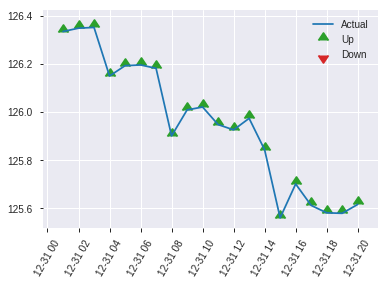


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24907394136053052
RMSE: 0.4990730821838927
LogLoss: 0.6912927174889866
Mean Per-Class Error: 0.4549667899781402
AUC: 0.5401673112493693
pr_auc: 0.5302200634204169
Gini: 0.08033462249873868
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47289566235275143: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      27   277  0.9112   (277.0/304.0)
1      10   303  0.0319   (10.0/313.0)
Total  37   580  0.4652   (287.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472896     0.678611  364
max f2                       0.459474     0.837794  398
max f0point5                 0.482539     0.578119  318
max accuracy                 0.486744     0.549433  292
max precision                0.546498     1         0
max recall                   0.459474     1         398
max specificity              0.546498     1         0
max absolute_mcc             0.472896     0.119744  364
max min_per_class_accuracy   0.503262     0.527157  166
max mean_per_class_accuracy  0.486744     0.545033  292

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 49.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.527234           0.84482   0.84482            0.428571         0.534583  0.428571                    0.534583            0.00958466      0.00958466                 -15.518   -15.518
    2        0.0210697                   0.519347           1.64271   1.21307            0.833333         0.522248  0.615385                    0.52889             0.0159744       0.0255591                  64.2705   21.3074
    3        0.0307942                   0.517749           0.657082  1.0375             0.333333         0.51834   0.526316                    0.525558            0.00638978      0.0319489                  -34.2918  3.74979
    4        0.0405186                   0.515369           0.328541  0.867348           0.166667         0.516664  0.44                        0.523424            0.00319489      0.0351438                  -67.1459  -13.2652
    5        0.0502431                   0.514148           0.657082  0.826652           0.333333         0.514717  0.419355                    0.521739            0.00638978      0.0415335                  -34.2918  -17.3348
    6        0.100486                    0.511266           1.39895   1.1128             0.709677         0.512367  0.564516                    0.517053            0.0702875       0.111821                   39.8949   11.28
    7        0.150729                    0.510085           1.01742   1.08101            0.516129         0.510545  0.548387                    0.514884            0.0511182       0.162939                   1.74173   8.10059
    8        0.200972                    0.50914            1.14459   1.0969             0.580645         0.50957   0.556452                    0.513555            0.057508        0.220447                   14.4594   9.6903
    9        0.299838                    0.506947           0.904834  1.03357            0.459016         0.507927  0.524324                    0.511699            0.0894569       0.309904                   -9.51658  3.35722
    10       0.400324                    0.505015           1.08101   1.04548            0.548387         0.506049  0.530364                    0.510281            0.108626        0.41853                    8.10059   4.54787
    11       0.50081                     0.503219           1.08101   1.05261            0.548387         0.504184  0.533981                    0.509058            0.108626        0.527157                   8.10059   5.26071
    12       0.599676                    0.499375           0.969465  1.0389             0.491803         0.500998  0.527027                    0.507729            0.0958466       0.623003                   -3.05348  3.88999
    13       0.700162                    0.493938           0.922034  1.02213            0.467742         0.497464  0.518519                    0.506256            0.0926518       0.715655                   -7.79656  2.21276
    14       0.799028                    0.486894           1.2603    1.0516             0.639344         0.490342  0.533469                    0.504287            0.124601        0.840256                   26.0305   5.15978
    15       0.899514                    0.477622           0.826652  1.02647            0.419355         0.482619  0.520721                    0.501866            0.0830671       0.923323                   -17.3348  2.64686
    16       1                           0.449175           0.763063  1                  0.387097         0.470422  0.507293                    0.498706          

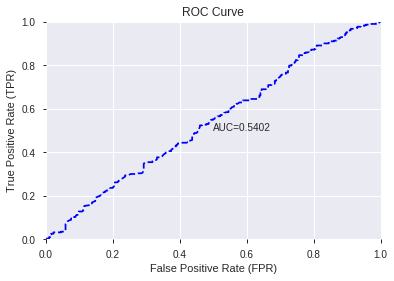

This function is available for GLM models only


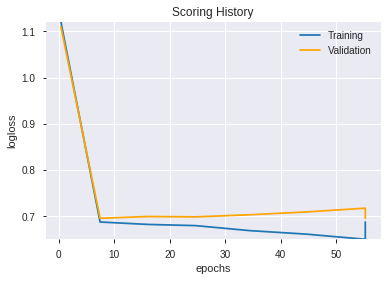

--2019-08-24 15:02:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_143533_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_143533_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_TRENDMODE',
 'ADX_14',
 'AROONOSC_24',
 'OBV',
 'ADXR_14',
 'ADX_24',
 'DX_24',
 'WILLR_12',
 'CCI_8',
 'CORREL_24',
 'DX_12',
 'CORREL_20',
 'STOCHRSI_fastk',
 'aroonup_20',
 'aroondown_24',
 'BBANDS_lowerband_14_1_5',
 'BETA_20',
 'BBANDS_lowerband_14_4_5',
 'BBANDS_upperband_24_3_4',
 'STDDEV_20',
 'AROONOSC_30',
 'aroonup_30',
 'BETA_24',
 'BBANDS_lowerband_12_7_4',
 'DX_14',
 'STDDEV_12',
 'ADX_20',
 'BBANDS_upperband_8_8_5',
 'aroondown_14',
 'RSI_8',
 'aroonup_14',
 'BBANDS_lowerband_8_3_4',
 'ULTOSC',
 'ADXR_12',
 'WILLR_14',
 'aroondown_12',
 'STDDEV_24',
 'VAR_12',
 'aroonup_8',
 'STDDEV_14',
 'CCI_24',
 'BBANDS_middleband_30_5_3',
 'STOCHF_fastk',
 'VAR_24',
 'BBANDS_lowerband_8_4_2',
 'LINEARREG_INTERCEPT_12',
 'aroonup_12',
 'MINUS_DM_20',
 'TRANGE',
 'aroondown_8',
 'PLUS_DI_30',
 'RSI_12',
 'MAVP_14_2',
 'ROCR100_8',
 'MACDFIX_hist_24',
 'DX_8',
 'BBANDS_middleband_20_2_2',
 'CORREL_8',
 'STOCH_slowk',
 'HT_PHASOR_quadrature',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_lo

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190824_150315_model_1  0.524676  0.692703              0.496711  0.49978  0.24978

variable  relative_importance  scaled_importance  percentage
0                CDLLONGLINE             0.013388           1.000000    0.023064
1                  CDLHARAMI             0.012918           0.964913    0.022254
2               aroondown_12             0.011826           0.883343    0.020373
3                CDLHIGHWAVE             0.010494           0.783875    0.018079
4                        OBV             0.010422           0.778460    0.017954
..                       ...                  ...                ...         ...
237             LINEARREG_30             0.000028           0.002097    0.000048
238  BBANDS_lowerband_20_5_4             0.000022           0.001660    0.000038
239                 SAR_0.12             0.000019           0.001434    0.000033
240                   RSI_30             0.000009           0.000676    0.000016
241       LINEARREG_SLOPE_14             0.000009           0.000636    0.000015

[242 rows x 4 columns]

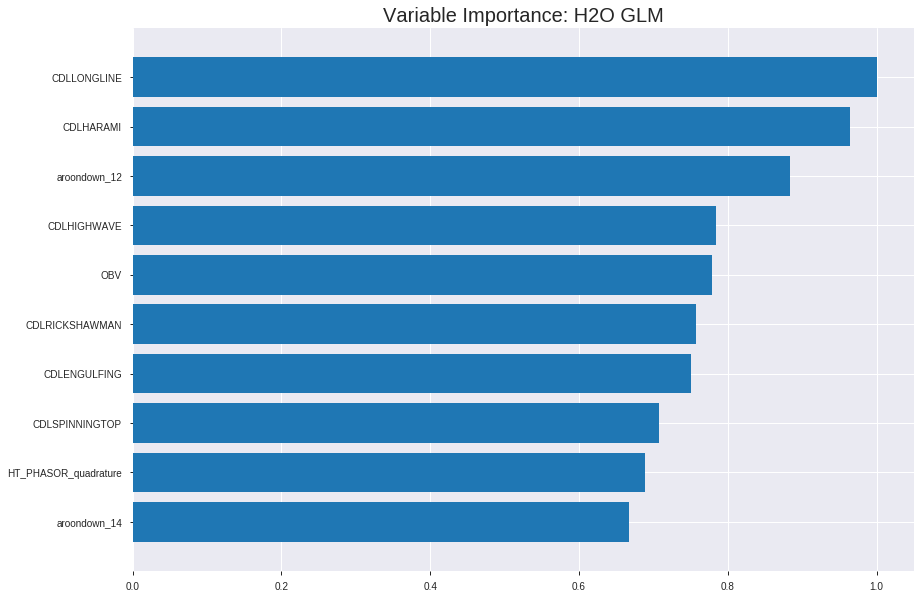

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_150315_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24753288953817099
RMSE: 0.49752677268481843
LogLoss: 0.6881971497067404
Null degrees of freedom: 4315
Residual degrees of freedom: 4073
Null deviance: 5980.442637223593
Residual deviance: 5940.517796268583
AIC: 6426.517796268583
AUC: 0.5628250606636658
pr_auc: 0.5667655922798366
Gini: 0.12565012132733155
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4466160990338997: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      37   2066  0.9824   (2066.0/2103.0)
1      13   2200  0.0059   (13.0/2213.0)
Total  50   4266  0.4817   (2079.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446616     0.679117  376
max f2                       0.405041     0.840422  397
max f0point5                 0.475236     0.572698  318
max accuracy                 0.508107     0.552132  216
max precision                0.575922     0.714286  23
max recall                   0.405041     1         397
max specificity              0.605664     0.999524  0
max absolute_mcc             0.508107     0.10149   216
max min_per_class_accuracy   0.513923     0.547221  195
max mean_per_class_accuracy  0.508107     0.550074  216

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.575442           1.32975   1.32975            0.681818         0.585073  0.681818                    0.585073            0.0135563       0.0135563                  32.9746   32.9746
    2        0.0201576                   0.56856            1.04318   1.18811            0.534884         0.571732  0.609195                    0.578479            0.0103931       0.0239494                  4.31804   18.811
    3        0.0301205                   0.56377            1.31531   1.23019            0.674419         0.566487  0.630769                    0.574512            0.0131044       0.0370538                  31.5314   23.0185
    4        0.0400834                   0.560244           1.40603   1.27389            0.72093          0.56195   0.653179                    0.57139             0.0140081       0.0510619                  40.6026   27.3891
    5        0.0500463                   0.557992           1.2246    1.26408            0.627907         0.559182  0.648148                    0.56896             0.0122006       0.0632625                  22.4603   26.4079
    6        0.100093                    0.547761           1.06544   1.16476            0.546296         0.552523  0.597222                    0.560741            0.0533213       0.116584                   6.54382   16.4759
    7        0.150139                    0.541035           1.17379   1.16777            0.601852         0.544262  0.598765                    0.555248            0.0587438       0.175328                   17.3788   16.7768
    8        0.200185                    0.535875           1.16476   1.16702            0.597222         0.538377  0.59838                     0.55103             0.0582919       0.23362                    16.4759   16.7016
    9        0.300046                    0.527648           1.05434   1.12951            0.540603         0.531605  0.579151                    0.544565            0.105287        0.338906                   5.43351   12.9514
    10       0.400139                    0.520661           1.05189   1.1101             0.539352         0.524078  0.569195                    0.539441            0.105287        0.444193                   5.18945   11.0098
    11       0.5                         0.513897           1.02266   1.09263            0.524362         0.517256  0.560241                    0.53501             0.102124        0.546317                   2.26598   9.26344
    12       0.600093                    0.506455           0.975147  1.07304            0.5              0.510283  0.550193                    0.530886            0.0976051       0.643922                   -2.48531  7.3038
    13       0.699954                    0.498604           0.886909  1.04648            0.454756         0.502702  0.536577                    0.526865            0.0885676       0.73249                    -11.3091  4.64833
    14       0.800046                    0.489722           0.93903   1.03304            0.481481         0.494324  0.529684                    0.522794            0.0939901       0.82648                    -6.09697  3.304
    15       0.899907                    0.476302           0.905009  1.01883            0.464037         0.483563  0.5224                      0.51844             0.0903751       0.916855                   -9.49913  1.88326
    16       1                           0.389367           0.830681  1                  0.425926         0.461524  0.512743                    0.512743            0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24948303437266803
RMSE: 0.49948276684252885
LogLoss: 0.6921192963394021
Null degrees of freedom: 1232
Residual degrees of freedom: 990
Null deviance: 1710.357041745574
Residual deviance: 1706.766184772965
AIC: 2192.766184772965
AUC: 0.5381749485615656
pr_auc: 0.5280522308110515
Gini: 0.07634989712313112
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3906265639524723: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    619   1        (619.0/619.0)
1      0    614   0        (0.0/614.0)
Total  0    1233  0.502    (619.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.390627     0.664862   399
max f2                       0.390627     0.832204   399
max f0point5                 0.494007     0.558733   273
max accuracy                 0.521497     0.532847   159
max precision                0.562238     0.628571   24
max recall                   0.390627     1          399
max specificity              0.578757     0.998384   0
max absolute_mcc             0.494007     0.0746099  273
max min_per_class_accuracy   0.515281     0.521809   185
max mean_per_class_accuracy  0.508126     0.533326   217

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 51.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.570853           0.61789   0.61789            0.307692         0.574542  0.307692                    0.574542            0.00651466      0.00651466                 -38.211   -38.211
    2        0.0202758                   0.565776           1.50611   1.04423            0.75             0.567678  0.52                        0.571247            0.014658        0.0211726                  50.6107   4.42345
    3        0.0300081                   0.561769           1.50611   1.19403            0.75             0.563598  0.594595                    0.568767            0.014658        0.0358306                  50.6107   19.4031
    4        0.0405515                   0.558488           1.23578   1.20489            0.615385         0.560465  0.6                         0.566608            0.0130293       0.0488599                  23.5781   20.4886
    5        0.0502839                   0.555278           1.17142   1.19841            0.583333         0.557182  0.596774                    0.564784            0.0114007       0.0602606                  17.1417   19.8408
    6        0.100568                    0.548501           1.10124   1.14982            0.548387         0.551565  0.572581                    0.558174            0.0553746       0.115635                   10.124    14.9824
    7        0.150041                    0.542635           1.05345   1.11805            0.52459          0.545322  0.556757                    0.553937            0.0521173       0.167752                   5.34522   11.8047
    8        0.200324                    0.537994           0.971682  1.08131            0.483871         0.540299  0.538462                    0.550513            0.0488599       0.216612                   -2.83177  8.13079
    9        0.300081                    0.529133           1.06121   1.07463            0.528455         0.533721  0.535135                    0.544931            0.105863        0.322476                   6.1214    7.4628
    10       0.399838                    0.521806           1.09387   1.07943            0.544715         0.525631  0.537525                    0.540116            0.109121        0.431596                   9.38667   7.9428
    11       0.500406                    0.515277           0.923098  1.04801            0.459677         0.518288  0.52188                     0.535729            0.0928339       0.52443                    -7.69019  4.801
    12       0.600162                    0.509385           1.06121   1.0502             0.528455         0.512741  0.522973                    0.531908            0.105863        0.630293                   6.1214    5.02047
    13       0.699919                    0.502048           0.963256  1.03781            0.479675         0.505713  0.516802                    0.528175            0.0960912       0.726384                   -3.67443  3.78122
    14       0.799676                    0.493719           1.02856   1.03666            0.512195         0.498106  0.516227                    0.524424            0.102606        0.82899                    2.85612   3.66582
    15       0.899432                    0.479085           0.767339  1.00679            0.382114         0.48723   0.501353                    0.520298            0.0765472       0.905537                   -23.2661  0.678782
    16       1                           0.390627           0.939293  1                  0.467742         0.455244  0.497972                    0.513756            


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 15:03:16  0.000 sec   2            2.6       243           1.37978           1.38479
    2019-08-24 15:03:16  0.284 sec   4            1.6       243           1.37819           1.38445
    2019-08-24 15:03:17  0.573 sec   6            0.99      243           1.37639           1.38424
    2019-08-24 15:03:17  0.859 sec   8            0.61      243           1.37443           1.38433
    2019-08-24 15:03:17  1.155 sec   10           0.38      243           1.3724            1.38484
    2019-08-24 15:03:18  1.444 sec   12           0.24      243           1.37036           1.38578
    2019-08-24 15:03:18  1.726 sec   14           0.15      243           1.36835           1.38715
    2019-08-24 15:03:18  2.022 sec   16           0.091     243           1.36634           1.38885

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5364667747163695)

('F1', 0.6745689655172414)

('auc', 0.5246763073818732)

('logloss', 0.6927028653815239)

('mean_per_class_error', 0.46755717168320166)

('rmse', 0.4997795733458433)

('mse', 0.24977962193375314)

glm prediction progress: |████████████████████████████████████████████████| 100%


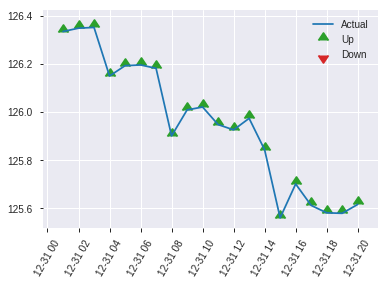


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24977962193375314
RMSE: 0.4997795733458433
LogLoss: 0.6927028653815239
Null degrees of freedom: 616
Residual degrees of freedom: 374
Null deviance: 855.2856750512815
Residual deviance: 854.7953358808005
AIC: 1340.7953358808004
AUC: 0.5246763073818732
pr_auc: 0.5360810514719431
Gini: 0.049352614763746416
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44440086810601614: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    302  0.9934   (302.0/304.0)
1      0    313  0        (0.0/313.0)
Total  2    615  0.4895   (302.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.444401     0.674569   397
max f2                       0.444401     0.838243   397
max f0point5                 0.502592     0.569296   316
max accuracy                 0.506632     0.536467   297
max precision                0.605125     1          0
max recall                   0.444401     1          397
max specificity              0.605125     1          0
max absolute_mcc             0.563412     0.0976644  20
max min_per_class_accuracy   0.526844     0.516447   194
max mean_per_class_accuracy  0.506632     0.532443   297

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 52.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.572167           1.12643   1.12643            0.571429         0.58749   0.571429                    0.58749             0.0127796       0.0127796                  12.6426   12.6426
    2        0.0210697                   0.567314           1.64271   1.36471            0.833333         0.569682  0.692308                    0.579271            0.0159744       0.028754                   64.2705   36.4709
    3        0.0307942                   0.564354           1.31416   1.34875            0.666667         0.565762  0.684211                    0.575005            0.0127796       0.0415335                  31.4164   34.8747
    4        0.0405186                   0.563013           1.64271   1.4193             0.833333         0.563802  0.72                        0.572316            0.0159744       0.057508                   64.2705   41.9297
    5        0.0502431                   0.561501           0.657082  1.27177            0.333333         0.562481  0.645161                    0.570412            0.00638978      0.0638978                  -34.2918  27.1772
    6        0.100486                    0.555755           1.01742   1.14459            0.516129         0.558365  0.580645                    0.564389            0.0511182       0.115016                   1.74173   14.4594
    7        0.150729                    0.549927           0.953829  1.08101            0.483871         0.552629  0.548387                    0.560469            0.0479233       0.162939                   -4.61713  8.10059
    8        0.200972                    0.545427           1.08101   1.08101            0.548387         0.548027  0.548387                    0.557358            0.0543131       0.217252                   8.10059   8.10059
    9        0.299838                    0.538791           0.904834  1.02292            0.459016         0.542098  0.518919                    0.552327            0.0894569       0.306709                   -9.51658  2.29168
    10       0.400324                    0.532389           1.04921   1.02952            0.532258         0.535864  0.522267                    0.548194            0.105431        0.412141                   4.92116   2.95171
    11       0.50081                     0.526833           1.04921   1.03347            0.532258         0.529781  0.524272                    0.5445              0.105431        0.517572                   4.92116   3.34688
    12       0.599676                    0.519357           0.840203  1.00161            0.42623          0.523345  0.508108                    0.541012            0.0830671       0.600639                   -15.9797  0.160608
    13       0.700162                    0.513465           1.14459   1.02213            0.580645         0.516008  0.518519                    0.537424            0.115016        0.715655                   14.4594   2.21276
    14       0.799028                    0.505529           1.13104   1.0356             0.57377          0.509048  0.525355                    0.533913            0.111821        0.827476                   13.1043   3.56039
    15       0.899514                    0.494404           0.858446  1.01581            0.435484         0.500012  0.515315                    0.530126            0.086262        0.913738                   -14.1554  1.58133
    16       1                           0.440883           0.858446  1                  0.435484         0.479806  0.507293                    0.525069        

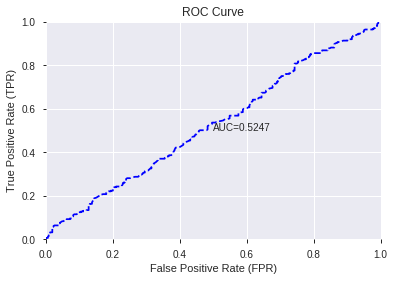

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


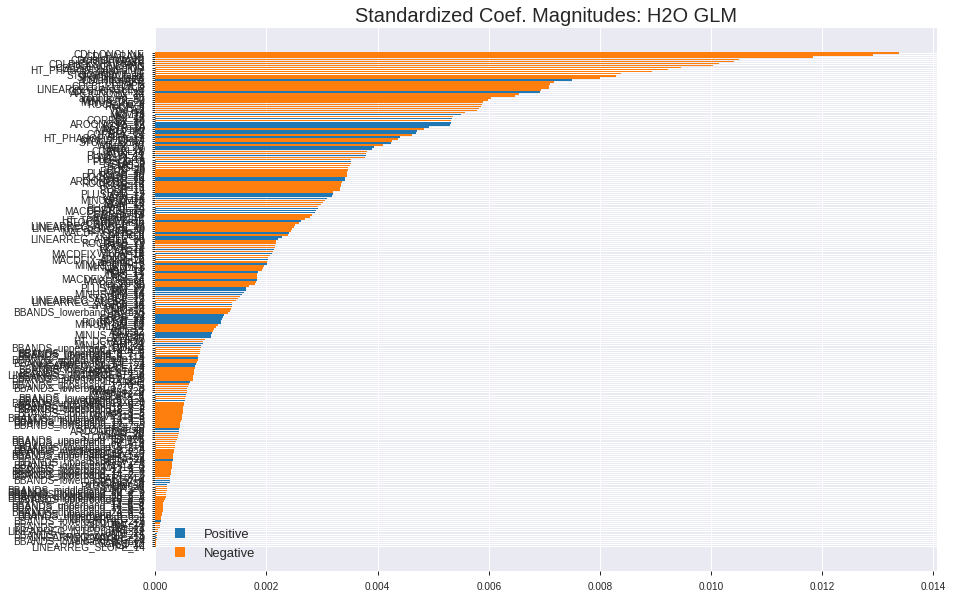

'log_likelihood'
--2019-08-24 15:03:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.168
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.168|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_150315_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_150315_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLLONGLINE',
 'CDLHARAMI',
 'aroondown_12',
 'CDLHIGHWAVE',
 'OBV',
 'CDLRICKSHAWMAN',
 'CDLENGULFING',
 'CDLSPINNINGTOP',
 'HT_PHASOR_quadrature',
 'aroondown_14',
 'STOCHRSI_fastk',
 'STOCHF_fastk',
 'aroondown_24',
 'CDLHIKKAKE',
 'ULTOSC',
 'DX_8',
 'CDLBELTHOLD',
 'LINEARREG_ANGLE_8',
 'CDLSHORTLINE',
 'AROONOSC_24',
 'DX_24',
 'aroondown_20',
 'MINUS_DI_30',
 'MINUS_DI_24',
 'ROCR100_8',
 'ROCR_8',
 'ROC_8',
 'AD',
 'DX_14',
 'MOM_8',
 'MFI_24',
 'DX_12',
 'CORREL_30',
 'DX_30',
 'AROONOSC_12',
 'BETA_14',
 'NATR_30',
 'MACD_hist',
 'ATR_30',
 'CORREL_24',
 'ADX_14',
 'HT_PHASOR_inphase',
 'MINUS_DI_14',
 'STOCH_slowd',
 'WILLR_30',
 'ADX_20',
 'NATR_20',
 'CORREL_8',
 'ADX_24',
 'PLUS_DI_12',
 'WILLR_24',
 'PLUS_DI_14',
 'PLUS_DI_8',
 'BETA_30',
 'CMO_8',
 'RSI_8',
 'ROC_20',
 'ROCP_20',
 'PLUS_DI_20',
 'ROCR_20',
 'ROCR100_20',
 'NATR_14',
 'AROONOSC_20',
 'ROCR100_14',
 'ROCR_14',
 'MFI_8',
 'ROCP_14',
 'ROC_14',
 'PLUS_DM_12',
 'NATR_12',
 'ATR_14',
 'MINUS_DM_8',
 'MOM_20

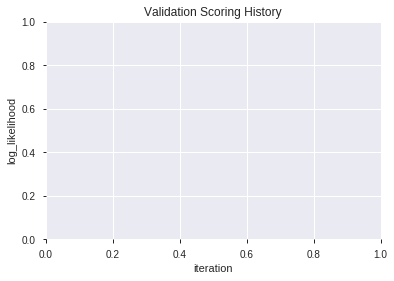

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_150428_model_3  0.549852  0.692030              0.500000  0.499408  0.249408
1  XGBoost_grid_1_AutoML_20190824_150428_model_2  0.538580  0.696297              0.491540  0.501509  0.251511
2               XGBoost_3_AutoML_20190824_150428  0.522869  0.698444              0.500000  0.502560  0.252566
3  XGBoost_grid_1_AutoML_20190824_150428_model_6  0.508649  0.702242              0.498355  0.504408  0.254427
4  XGBoost_grid_1_AutoML_20190824_150428_model_7  0.505176  0.715088              0.500000  0.510178  0.260282
5               XGBoost_2_AutoML_20190824_150428  0.501876  0.714319              0.498355  0.509843  0.259940
6  XGBoost_grid_1_AutoML_20190824_150428_model_5  0.498408  0.731797              0.498355  0.517100  0.267393
7  XGBoost_grid_1_AutoML_20190824_150428_model_1  0.497840  0.706597              0.500000  0.506457  0.256499
8               XGBoost_1_AutoML_20190824_150428  0.496936  0.714383              0.496616  0.509965  0.260064
9  XGBoost_grid_1_AutoML_20190824_150428_model_4  0.488781  0.701909              0.495018  0.504302  0.254321

variable  relative_importance  scaled_importance  percentage
0       HT_PHASOR_quadrature           212.498535           1.000000    0.028628
1               STOCHF_fastk           180.275467           0.848361    0.024287
2                        OBV           168.507416           0.792982    0.022701
3                    BETA_14           133.419052           0.627859    0.017974
4                    BETA_30           129.686005           0.610291    0.017471
..                       ...                  ...                ...         ...
201                   RSI_14             5.326929           0.025068    0.000718
202  BBANDS_upperband_12_1_5             3.798800           0.017877    0.000512
203  BBANDS_upperband_12_0_5             3.071510           0.014454    0.000414
204   BBANDS_lowerband_8_7_5             2.771917           0.013044    0.000373
205  BBANDS_lowerband_14_7_4             2.417961           0.011379    0.000326

[206 rows x 4 columns]

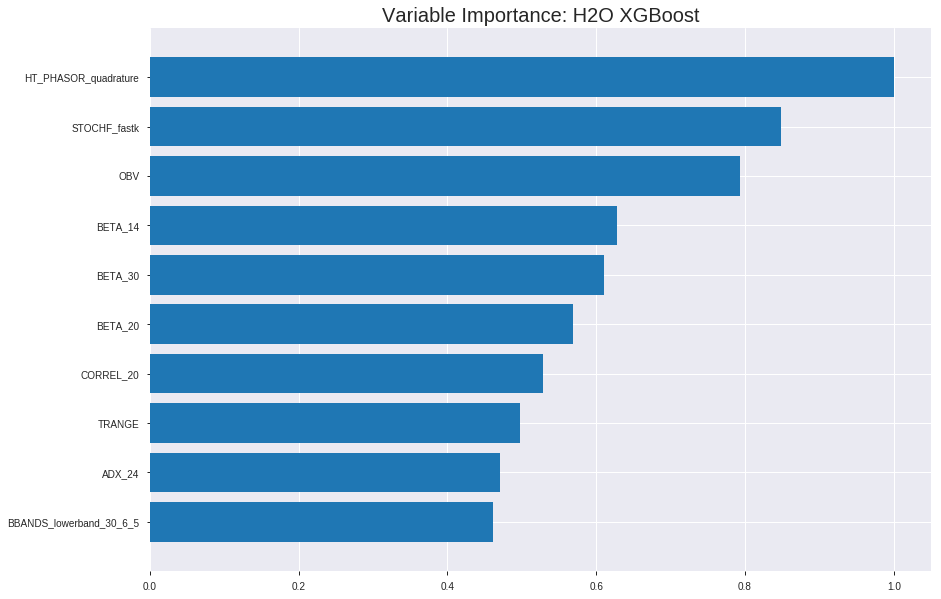

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_150428_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21245917179094412
RMSE: 0.4609329363269066
LogLoss: 0.6167729875165573
Mean Per-Class Error: 0.22421340288302016
AUC: 0.8587081824665085
pr_auc: 0.8623686369218967
Gini: 0.717416364933017
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49101789374100535: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1324  779   0.3704   (779.0/2103.0)
1      256   1957  0.1157   (256.0/2213.0)
Total  1580  2736  0.2398   (1035.0/4316.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491018     0.790867  226
max f2                       0.460036     0.872568  269
max f0point5                 0.528645     0.803638  170
max accuracy                 0.512573     0.77595   194
max precision                0.781257     1         0
max recall                   0.300933     1         385
max specificity              0.781257     1         0
max absolute_mcc             0.527454     0.55509   172
max min_per_class_accuracy   0.5131       0.773181  193
max mean_per_class_accuracy  0.512573     0.775787  194

Gains/Lift Table: Avg response rate: 51.27 %, avg score: 51.31 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101946                   0.683311           1.95029    1.95029            1                0.714431  1                           0.714431            0.0198825       0.0198825                  95.0294   95.0294
    2        0.0201576                   0.660892           1.90494    1.92788            0.976744         0.671247  0.988506                    0.693087            0.0189788       0.0388613                  90.4938   92.7877
    3        0.0301205                   0.646577           1.90494    1.92029            0.976744         0.652096  0.984615                    0.679528            0.0189788       0.05784                    90.4938   92.0289
    4        0.0400834                   0.636676           1.90494    1.91647            0.976744         0.640513  0.982659                    0.669831            0.0189788       0.0768188                  90.4938   91.6474
    5        0.0500463                   0.628942           1.76887    1.88709            0.906977         0.632304  0.967593                    0.66236             0.0176231       0.0944419                  76.8871   88.709
    6        0.100093                    0.602343           1.84194    1.86452            0.944444         0.615167  0.956019                    0.638764            0.0921826       0.186624                   84.1944   86.4517
    7        0.150139                    0.584434           1.80583    1.84495            0.925926         0.59367   0.945988                    0.623732            0.0903751       0.277                      80.5828   84.4954
    8        0.200185                    0.569681           1.69748    1.80808            0.87037          0.577163  0.927083                    0.61209             0.0849526       0.361952                   69.7478   80.8085
    9        0.300046                    0.548686           1.57472    1.73042            0.807425         0.558856  0.887259                    0.594373            0.157253        0.519205                   57.4715   73.0415
    10       0.400139                    0.53102            1.41306    1.65103            0.724537         0.540026  0.846555                    0.580778            0.141437        0.660642                   41.306    65.103
    11       0.5                         0.514531           1.06339    1.53366            0.545244         0.522759  0.786376                    0.56919             0.106191        0.766832                   6.33852   53.3665
    12       0.600093                    0.497443           0.880341   1.42469            0.451389         0.505973  0.730502                    0.558646            0.0881157       0.854948                   -11.9659  42.4693
    13       0.699954                    0.478946           0.647081   1.31375            0.331787         0.487983  0.673618                    0.548565            0.0646182       0.919566                   -35.2919  31.3753
    14       0.800046                    0.455182           0.501117   1.21209            0.256944         0.468     0.621489                    0.538485            0.0501582       0.969724                   -49.8883  21.2085
    15       0.899907                    0.423285           0.221727   1.10219            0.113689         0.440567  0.565139                    0.52762             0.0221419       0.991866                   -77.8273  10.2187
    16       1                           0.178411           0.0812622  1                  0.0416667        0.382745  0.512743                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25277368962059044
RMSE: 0.5027660386507729
LogLoss: 0.6991319645745403
Mean Per-Class Error: 0.4686199239079528
AUC: 0.5221211579041535
pr_auc: 0.5168543247692928
Gini: 0.04424231580830695
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20143993198871613: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    618   0.9984   (618.0/619.0)
1      0    614   0        (0.0/614.0)
Total  1    1232  0.5012   (618.0/1233.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.20144      0.665222   398
max f2                       0.20144      0.83243    398
max f0point5                 0.259389     0.554849   390
max accuracy                 0.543177     0.532036   130
max precision                0.696217     1          0
max recall                   0.20144      1          398
max specificity              0.696217     1          0
max absolute_mcc             0.543177     0.0685559  130
max min_per_class_accuracy   0.513407     0.516287   187
max mean_per_class_accuracy  0.537081     0.53138    141

Gains/Lift Table: Avg response rate: 49.80 %, avg score: 50.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105434                   0.634851           1.39025   1.39025            0.692308         0.658324  0.692308                    0.658324            0.014658        0.014658                   39.0253   39.0253
    2        0.0202758                   0.622598           1.33876   1.36554            0.666667         0.627857  0.68                        0.6437              0.0130293       0.0276873                  33.8762   36.5537
    3        0.0300081                   0.6142             0.502036  1.08548            0.25             0.617659  0.540541                    0.635254            0.00488599      0.0325733                  -49.7964  8.54829
    4        0.0405515                   0.604069           0.926835  1.04423            0.461538         0.60879   0.52                        0.628373            0.00977199      0.0423453                  -7.31646  4.42345
    5        0.0502839                   0.599786           0.669381  0.971682           0.333333         0.602085  0.483871                    0.623285            0.00651466      0.0488599                  -33.0619  -2.83177
    6        0.100568                    0.582365           1.06885   1.02027            0.532258         0.590223  0.508065                    0.606754            0.0537459       0.102606                   6.88505   2.02664
    7        0.150041                    0.568345           0.954691  0.998644           0.47541          0.575348  0.497297                    0.596399            0.0472313       0.149837                   -4.53089  -0.135575
    8        0.200324                    0.557398           1.16602   1.04066            0.580645         0.56305   0.518219                    0.588028            0.0586319       0.208469                   16.6019   4.06573
    9        0.300081                    0.541236           1.22448   1.10177            0.609756         0.549732  0.548649                    0.575297            0.12215         0.330619                   22.4478   10.1765
    10       0.399838                    0.527695           0.979582  1.07128            0.487805         0.534785  0.533469                    0.56519             0.0977199       0.428339                   -2.04179  7.12813
    11       0.500406                    0.513251           0.890709  1.03499            0.443548         0.520715  0.515397                    0.556251            0.0895765       0.517915                   -10.9291  3.49912
    12       0.600162                    0.500464           0.881624  1.0095             0.439024         0.50738   0.502703                    0.548128            0.0879479       0.605863                   -11.8376  0.949908
    13       0.699919                    0.485436           1.06121   1.01687            0.528455         0.492918  0.506373                    0.540259            0.105863        0.711726                   6.1214    1.68698
    14       0.799676                    0.464354           0.89795   1.00204            0.447154         0.476716  0.498986                    0.532332            0.0895765       0.801303                   -10.205   0.2035
    15       0.899432                    0.435297           1.01223   1.00317            0.504065         0.451225  0.499549                    0.523337            0.100977        0.90228                    1.22348   0.316628
    16       1                           0.184506           0.971682  1                  0.483871         0.378574  0.497972                    0.508778     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 15:04:43  3.480 sec   0                  0.5              0.693147            0.5             0                  1                0.487257                         0.5                0.693147              0.5               0                    1                  0.502028
    2019-08-24 15:04:43  3.796 sec   5                  0.494934         0.683051            0.675448        0.682532           1.77299          0.433272                         0.500397           0.693942              0.489114          0.487225             1.23578            0.502028
    2019-08-24 15:04:44  3.976 sec   10                 0.490673         0.674604            0.715943        0.72274            1.90597          0.372567                         0.500363           0.693872              0.502457          0.502937             1.29095            0.499594
    2019-08-24 15:04:44  4.173 sec   15                 0.485852         0.6651              0.747831        0.754982           1.90597          0.362604                         0.499956           0.693056              0.516479          0.522486             1.85367            0.500406
    2019-08-24 15:04:44  4.384 sec   20                 0.481148         0.655888            0.781515        0.78657            1.86164          0.31696                          0.500196           0.693544              0.518063          0.521721             1.6992             0.493917
    2019-08-24 15:04:44  4.585 sec   25                 0.477384         0.648533            0.799878        0.805277           1.90597          0.291242                         0.501157           0.695505              0.510067          0.507564             1.23578            0.502028
    2019-08-24 15:04:44  4.799 sec   30                 0.47301          0.640033            0.815067        0.821415           1.86164          0.283364                         0.501361           0.695942              0.513598          0.510429             1.08131            0.502028
    2019-08-24 15:04:45  5.002 sec   35                 0.469617         0.633482            0.830044        0.836526           1.86164          0.261353                         0.501808           0.696883              0.513324          0.50986              1.08131            0.502028
    2019-08-24 15:04:45  5.225 sec   40                 0.465935         0.62636             0.840289        0.845173           1.95029          0.253475                         0.501897           0.697115              0.520437          0.516692             1.23578            0.501217
    2019-08-24 15:04:45  5.443 sec   45                 0.464225         0.623051            0.846099        0.850053           1.95029          0.241427                         0.502414           0.698286              0.521907          0.514596             1.23578            0.501217
    2019-08-24 15:04:45  5.672 sec   50                 0.460933         0.616773            0.858708        0.862369           1.95029          0.239805                         0.502766           0.699132              0.522121          0.516854             1.39025            0.501217

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
HT_PHASOR_quadrature     212.49853515625        1.0                   0.028627638782972045
STOCHF_fastk             180.2754669189453      0.848360986518749     0.024286571879624564
OBV                      168.50741577148438     0.7929815405437078    0.02270118910424997
BETA_14                  133.41905212402344     0.6278586910066016    0.01797411181288665
BETA_30                  129.68600463867188     0.6102912876237658    0.017471198534488065
---                      ---                    ---                   ---
RSI_14                   5.326929092407227      0.02506807441514992   0.0007176397793415752
BBANDS_upperband_12_1_5  3.798799514770508      0.01787682683072264   0.0005117713410956706
BBANDS_upperband_12_0_5  3.0715103149414062     0.014454265826740533  0.0004137915009609848
BBANDS_lowerband_8_7_5   2.7719173431396484     0.013044406828976302  0.00037343056683806743
BBANDS_lowerband_14_7_4  2.4179611206054688     0.011378719005415937  0.00032574585749998644


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5591572123176661)

('F1', 0.6731182795698925)

('auc', 0.5498518160417017)

('logloss', 0.6920304890743847)

('mean_per_class_error', 0.44032180090802076)

('rmse', 0.4994078047896432)

('mse', 0.24940815548481035)

xgboost prediction progress: |████████████████████████████████████████████| 100%


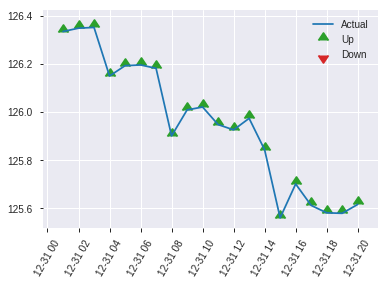


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24940815548481035
RMSE: 0.4994078047896432
LogLoss: 0.6920304890743847
Mean Per-Class Error: 0.44032180090802076
AUC: 0.5498518160417017
pr_auc: 0.5424675750719787
Gini: 0.09970363208340349
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3534255027770996: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    304  1        (304.0/304.0)
1      0    313  0        (0.0/313.0)
Total  0    617  0.4927   (304.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.353426     0.673118  399
max f2                       0.353426     0.837346  399
max f0point5                 0.499244     0.565947  272
max accuracy                 0.533852     0.559157  183
max precision                0.683432     1         0
max recall                   0.353426     1         399
max specificity              0.683432     1         0
max absolute_mcc             0.533852     0.119635  183
max min_per_class_accuracy   0.531325     0.542763  193
max mean_per_class_accuracy  0.533852     0.559678  183

Gains/Lift Table: Avg response rate: 50.73 %, avg score: 52.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.648394           1.12643   1.12643            0.571429         0.660272  0.571429                    0.660272            0.0127796       0.0127796                  12.6426   12.6426
    2        0.0210697                   0.628807           0.985623  1.06144            0.5              0.634514  0.538462                    0.648383            0.00958466      0.0223642                  -1.4377   6.14402
    3        0.0307942                   0.620942           0.985623  1.0375             0.5              0.624031  0.526316                    0.640693            0.00958466      0.0319489                  -1.4377   3.74979
    4        0.0405186                   0.614023           0.657082  0.946198           0.333333         0.617381  0.48                        0.635098            0.00638978      0.0383387                  -34.2918  -5.38019
    5        0.0502431                   0.612197           1.64271   1.08101            0.833333         0.612845  0.548387                    0.630791            0.0159744       0.0543131                  64.2705   8.10059
    6        0.100486                    0.598355           1.08101   1.08101            0.548387         0.606202  0.548387                    0.618496            0.0543131       0.108626                   8.10059   8.10059
    7        0.150729                    0.583516           1.01742   1.05981            0.516129         0.591302  0.537634                    0.609432            0.0511182       0.159744                   1.74173   5.98097
    8        0.200972                    0.573417           1.46254   1.16049            0.741935         0.578362  0.58871                     0.601664            0.0734824       0.233227                   46.2537   16.0492
    9        0.299838                    0.55553            1.0341    1.11882            0.52459          0.563472  0.567568                    0.589071            0.102236        0.335463                   3.40963   11.8815
    10       0.400324                    0.540862           1.14459   1.12529            0.580645         0.548787  0.57085                     0.578959            0.115016        0.450479                   14.4594   12.5286
    11       0.50081                     0.53133            0.922034  1.0845             0.467742         0.535456  0.550162                    0.57023             0.0926518       0.543131                   -7.79656  8.45043
    12       0.599676                    0.516044           0.872519  1.04956            0.442623         0.524844  0.532432                    0.562748            0.086262        0.629393                   -12.7481  4.95553
    13       0.700162                    0.501962           1.01742   1.04494            0.516129         0.509135  0.530093                    0.555053            0.102236        0.731629                   1.74173   4.49429
    14       0.799028                    0.483199           0.904834  1.02761            0.459016         0.493495  0.521298                    0.547437            0.0894569       0.821086                   -9.51658  2.76069
    15       0.899514                    0.453505           0.794857  1.00161            0.403226         0.471211  0.508108                    0.538921            0.0798722       0.900958                   -20.5143  0.160608
    16       1                           0.353426           0.985623  1                  0.5              0.421984  0.507293                    0.527171       

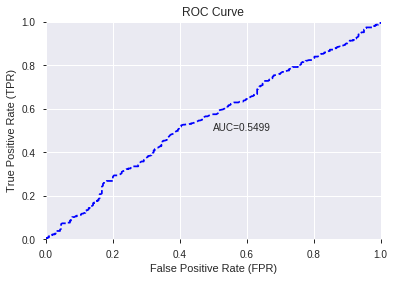

This function is available for GLM models only


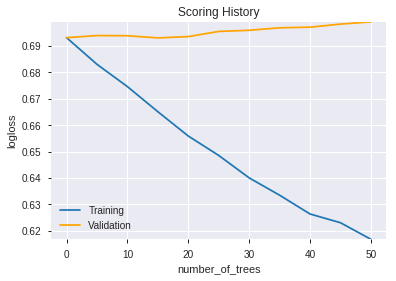

--2019-08-24 15:05:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_150428_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_150428_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_805c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['HT_PHASOR_quadrature',
 'STOCHF_fastk',
 'OBV',
 'BETA_14',
 'BETA_30',
 'BETA_20',
 'CORREL_20',
 'TRANGE',
 'ADX_24',
 'BBANDS_lowerband_30_6_5',
 'CORREL_8',
 'CORREL_12',
 'LINEARREG_ANGLE_8',
 'ADOSC',
 'STOCHRSI_fastd',
 'DX_14',
 'MFI_14',
 'STOCH_slowk',
 'LINEARREG_INTERCEPT_30',
 'PLUS_DI_8',
 'HT_PHASOR_inphase',
 'ULTOSC',
 'DX_12',
 'MOM_30',
 'MFI_8',
 'MOM_20',
 'STOCH_slowd',
 'ADX_20',
 'MOM_12',
 'CDLSPINNINGTOP',
 'ADXR_12',
 'AROONOSC_24',
 'AD',
 'CORREL_14',
 'DX_8',
 'RSI_30',
 'DX_24',
 'BBANDS_upperband_20_1_5',
 'CORREL_30',
 'MINUS_DI_14',
 'CMO_12',
 'MFI_30',
 'MFI_12',
 'STDDEV_24',
 'aroonup_20',
 'STDDEV_8',
 'CCI_12',
 'HT_DCPERIOD',
 'APO',
 'ROC_8',
 'DX_30',
 'BETA_24',
 'PLUS_DM_30',
 'WILLR_14',
 'MACDFIX_signal_14',
 'CCI_30',
 'ATR_8',
 'WILLR_30',
 'CCI_8',
 'ROCP_20',
 'MINUS_DI_30',
 'MINUS_DI_8',
 'ADXR_14',
 'CDLHARAMI',
 'BBANDS_lowerband_20_5_4',
 'RSI_20',
 'CMO_24',
 'PLUS_DI_12',
 'ATR_14',
 'ROC_24',
 'MINUS_DM_24',
 'MOM_24',
 'TRIX

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.562
GLM             0.541
XGBoost         0.566
dtype: float64

DeepLearning    GLM  XGBoost
All          0.562  0.541    0.527
DLF          0.546  0.520    0.520
Fwe          0.541  0.540    0.566
RFE          0.549  0.536    0.559
XGBF         0.535  0.520    0.520





F1


DeepLearning    0.679
GLM             0.675
XGBoost         0.674
dtype: float64

DeepLearning    GLM  XGBoost
All          0.676  0.674    0.674
DLF          0.673  0.673    0.673
Fwe          0.673  0.674    0.673
RFE          0.679  0.675    0.673
XGBF         0.675  0.673    0.673





auc


DeepLearning    0.563
GLM             0.525
XGBoost         0.550
dtype: float64

DeepLearning    GLM  XGBoost
All          0.563  0.525    0.517
DLF          0.531  0.509    0.501
Fwe          0.549  0.521    0.549
RFE          0.540  0.525    0.550
XGBF         0.522  0.509    0.501





logloss


DeepLearning    0.745
GLM             0.693
XGBoost         0.705
dtype: float64

DeepLearning    GLM  XGBoost
All          0.715  0.692    0.702
DLF          0.702  0.693    0.705
Fwe          0.691  0.693    0.695
RFE          0.691  0.693    0.692
XGBF         0.745  0.693    0.705





mean_per_class_error


DeepLearning    0.464
GLM             0.481
XGBoost         0.477
dtype: float64

DeepLearning    GLM  XGBoost
All          0.439  0.464    0.470
DLF          0.458  0.481    0.477
Fwe          0.455  0.455    0.437
RFE          0.455  0.468    0.440
XGBF         0.464  0.481    0.477





rmse


DeepLearning    0.520
GLM             0.500
XGBoost         0.505
dtype: float64

DeepLearning    GLM  XGBoost
All          0.508  0.499    0.504
DLF          0.502  0.500    0.505
Fwe          0.499  0.500    0.501
RFE          0.499  0.500    0.499
XGBF         0.520  0.500    0.505





mse


DeepLearning    0.270
GLM             0.250
XGBoost         0.255
dtype: float64

DeepLearning    GLM  XGBoost
All          0.258  0.249    0.254
DLF          0.252  0.250    0.255
Fwe          0.249  0.250    0.251
RFE          0.249  0.250    0.249
XGBF         0.270  0.250    0.255

{'F1':       DeepLearning    GLM  XGBoost
 All          0.676    NaN      NaN
 DLF          0.673    NaN      NaN
 DLF            NaN  0.673      NaN
 DLF            NaN    NaN    0.673
 All            NaN  0.674      NaN
 All            NaN    NaN    0.674
 XGBF         0.675    NaN      NaN
 XGBF           NaN  0.673      NaN
 XGBF           NaN    NaN    0.673
 Fwe          0.673    NaN      NaN
 Fwe            NaN  0.674      NaN
 Fwe            NaN    NaN    0.673
 RFE          0.679    NaN      NaN
 RFE            NaN  0.675      NaN
 RFE            NaN    NaN    0.673,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.562    NaN      NaN
 DLF          0.546    NaN      NaN
 DLF            NaN  0.520      NaN
 DLF            NaN    NaN    0.520
 All            NaN  0.541      NaN
 All            NaN    NaN    0.527
 XGBF         0.535    NaN      NaN
 XGBF           NaN  0.520      NaN
 XGBF           NaN    NaN    0.520
 Fwe          0.541    NaN      NaN
 Fwe     